# What drives the price of a car?


**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

#### Imports:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px
from scipy.special import exp10

###########
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import set_config
set_config(display="diagram") #setting this will display my pipelines
import warnings

# sklearn version:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

# do not show warnings:
import warnings
warnings.filterwarnings('ignore')

The scikit-learn version is 1.3.2.


Functions to be used:

In [2]:
# creating a histogram_plotting function with fixed options:
def histogram_plotting(dataset, feature, xlabels_rotation = 360, size1 = (10,5), size2 = [6.5, 4.5], kde = False):
    #showing a histogram to better understand the data for users who accepted the coupon:
    plt.figure(figsize=size1)
    fig = sns.displot(dataset[feature], color = 'green', edgecolor = 'white', kde = kde)
    fig.figure.set_size_inches(size2[0], size2[1])
    plt.xticks(rotation = xlabels_rotation) # fixing rotation of the x-axis labels
    plt.title('Distribution plot of ' + feature) # title 
    plt.show() # show the plot


# creating a boxplot function with fixed options:
def boxplt(feature, thres = 50000, size = (5,8)):
    """
    :param feature: the feature we want to plot against the target variable (price)
    :param thres: a threshold used for removing price values above the inserted number
    :return: the function returns a boxplot
    """
    threshold = 'price<=' + str(thres)
    plt.figure(figsize= size)
    plt.title('Boxplot of ' + feature + ' according to price')
    sns.boxplot(data= data_und.query(threshold),
                x = feature, y="price", hue = feature,
                palette="vlag", legend = False
                )
    plt.xlabel('Feature Values')
    plt.show()

# creating a function that removes the outliers of a feature
def outliers_removal(data, years_to_check, feature= 'price',upper_q = 0.75, low_q = 0.25):
    """
    :param data: initial dataset
    :param years_to_check: a list of year values that the feature should be checked
    :param feature: feature / variable to clean
    :param upper_q: upper quantile
    :param low_q: lower quantile
    :return: dataset with the outliers removed
    """
    for year in years_to_check:
        # initialising the dataset's quantiles:
        q_low = data[data['year'] == year][feature].quantile(low_q)
        q_up = data[data['year'] == year][feature].quantile(upper_q )
        # calculating the Quartile Range (by default the interquartile range is calculated):
        QR = q_up - q_low
        # calculating the lower and upper limit of price variable:
        lower_limit = q_low - 1*5*QR
        upper_limit = q_up + 1*5*QR
        # indentification of the data indexes that are considered outliers:
        lower_indexes = data[(data['year'] == year) & (data[feature] < lower_limit)].index
        upper_indexes = data[(data['year'] == year) & (data[feature] > upper_limit)].index
        # dropping the outliers from the dataset (in the specific year):
        data.drop(index=lower_indexes, axis=0, errors='ignore', inplace=True)
        data.drop(index=upper_indexes, axis=0, errors='ignore', inplace=True)
    return data

# CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


CRISP-DM stands for the Cross Industry Standard Process for Data Mining. It is a widely used and well-established methodology for guiding data mining and analytics projects. The CRISP-DM process model provides a structured approach to planning, executing, and evaluating data mining projects. It consists of six major phases:

Business Understanding:
- Define the business problem.
- Establish the project objectives.
- Assess the situation to understand the requirements and constraints.
  
Data Understanding:
- Collect and explore the initial data.
- Identify data quality issues.
- Evaluate the data's suitability for analysis.
- Initial transformations of variables as needed for analysis.
  
Data Preparation:
- Clean and preprocess the data.
- Handle missing values and outliers.
- Transform variables as needed for analysis.
  
Modeling:
- Select and apply appropriate modeling techniques.
- Calibrate and optimize model parameters.

Evaluation:
- Evaluate and validate the model's performance.
- Validate the model's robustness and generalizability.
- Assess the model's effectiveness against business objectives.

Deployment:
- Report the analysis to the client


The CRISP-DM methodology is iterative, meaning that it often involves cycling back through the phases as needed. This flexibility allows data scientists and analysts to refine their approach based on insights gained during the process. The methodology is widely used in various industries for data mining, machine learning, and analytics projects to ensure a systematic and well-organized workflow.

The first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).

( Access the online documentation: [IBM CRISP-DM](https://www.ibm.com/docs/en/spss-modeler/saas?topic=guide-introduction-crisp-dm) )

## 1 Business Understanding

From a business perspective, I am tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, I am asked to convert this business framing to a data problem definition.  I should reframe the task as a data task with the appropriate technical vocabulary. 

#### 1.1 Determining Business Objectives
**Objective:**
The primary objective of this project is to conduct a comprehensive analysis of the used car market in the USA. The insights derived from this analysis will empower our client, a group of used car dealerships, to understand the factors influencing the pricing of used cars. By **identifying the key features that drive the pricing of used cars**, our goal is to provide clear and actionable recommendations for our client to enhance their business strategies.

**Background:**
The used car market is dynamic and influenced by various factors, ranging from the vehicle's make and model to its mileage, age, and overall condition. Understanding the nuances of these factors is crucial for our client's success in pricing their inventory competitively. As non-technical individuals, our client relies on our expertise to translate complex data into practical insights that can inform their business decisions.

**Stakeholders:**
Our primary stakeholders are the used car dealerships comprising our client group. Their perspective and understanding of consumer preferences are central to the success of this analysis. It is imperative to bridge the gap between technical insights and practical applications, ensuring that our findings resonate with the goals and challenges faced by our non-technical audience.



#### 1.2 Assesing the situation:

The global market for used cars was valued at USD 1.66 trillion in 2022 and is projected to experience a compound annual growth rate (CAGR) of 6.1% between 2023 and 2030. In 2021 only, the total volume of used car shipments was 120.3 million units. The used car industry has witnessed remarkable progress over recent years due to increased competitiveness among new players in terms of pricing. The rise in sales volume of used cars can be attributed to customers' inability to purchase new cars and investments by market participants to establish their dealership networks. These networks helped to brand and promote viable used car options in the market.


**Risks and Contingencies**
We concluded the following risks:
- The available data used for the analysis cover the period from 1900 to 2022. Throughout these years, we should create market segmentations.
- There are around 400k observations, which are not the most indicative sample of our market. In other words, there is a probability of creating biased models that catch a specific market trend in a particular period. 
- It is worth mentioning that most of the data falls between the years 1998 and 2021. 
- We are restricted to using only regression models such as Lasso, Ridge, ElasticNet, Linear regression, etc. These models are generally categorised as linear-type models. They may only generalise well if the model's features strongly correlate with the variable we want to predict.
- We should not use the car's VIN code in our models as it will give rise to possible data privacy and ethical issues.

We should inform our client of the above risks and provide a plan for how to tackle them. More specifically, in a future engagement with the client, we should train our models with more recent data that is representative of our local market. The above could be achieved by creating a competitive data strategy before conducting ML solutions.

#### 1.3 Determining the data mining goals

Translating the client's business objectives into data mining terms:
- The problem we are asked to solve is a supervised regression task.
- In other words, using a flat type dataset that contains the cars' characteristics as features, we should predict the sale price of used cars. 
- Furthermore, the models that we could use are Linear, Polynomial, Lasso, Ridge and Elastic Net regression models.
- We should choose the best performing models before conducting a regression analysis (interpreting the models).
- The models will be scored based on their R-squared score. In addition, we will consider the MSE and RMSE score and lastly the Adjusted R-squared score.
- In general, we should understand how the input features contribute to the prediction of the target variable (price). In addition, the most significant factors of the models should be addressed. In this way we will provide accurate recommendations to our client.

## 2 Data Understanding and initial transformations

After considering the business understanding, I will get familiar with the data.  I will analyse the dataset and identify any quality issues within. I will explore what information it contains and how this could be used to inform your business understanding. In addition, I will make initial data transformations.

In [3]:
data = pd.read_csv('data/vehicles.csv')
initial_data_shape = data.shape
# used for data understanding
data_und = data

Showing the first 4 observations of the vehicles dataset:

In [4]:
data_und.head(4)

id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         NaN    ar  
2  NaN  NaN         NaN    fl  
3  NaN  NaN         NaN    ma

Understanding the dimensions of the dataset and of the null values.

In [5]:
#initial info of data:
print(data_und.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

The dataset contains 426,880 observations. There are fifteen features (id and VIN attributes are not included) and one target variable (price).

The unique observations of VIN

In [6]:
print('The unique observations of VIN are: '+str(data_und.groupby('VIN').count().shape[0]) )
print('The shape of our dataset is: '+str(data_und.shape))

The unique observations of VIN are: 118246
The shape of our dataset is: (426880, 18)


As noticed above, the car's vehicle identification number (VIN) is the identifying code for a specific automobile. For our analysis, VIN is not useful and will be dropped. Following a similar logic, we could also drop id. Before dropping the variables we could investigate further the duplicate issues.

In [7]:
data["VIN"].value_counts().head(3)

VIN
1FMJU1JT1HEA52352    261
3C6JR6DT3KG560649    235
1FTER1EH1LLA36301    231
Name: count, dtype: int64

As noticed above, there is a car that is sold **261** times. Quite strange.

In [8]:
data_und[data_und["VIN"] == "1FMJU1JT1HEA52352"].head()

id                    region  price    year manufacturer  \
76    7311818189                    auburn  29590  2017.0         ford   
707   7311865995                birmingham  29590  2017.0         ford   
1935  7311801032                    dothan  29590  2017.0         ford   
2201  7311915565  florence / muscle shoals  29590  2017.0         ford   
2377  7311823034          gadsden-anniston  29590  2017.0         ford   

                     model condition    cylinders fuel  odometer title_status  \
76    expedition xlt sport      good  6 cylinders  gas   70760.0        clean   
707   expedition xlt sport      good  6 cylinders  gas   70760.0        clean   
1935  expedition xlt sport      good  6 cylinders  gas   70760.0        clean   
2201  expedition xlt sport      good  6 cylinders  gas   70760.0        clean   
2377  expedition xlt sport      good  6 cylinders  gas   70760.0        clean   

     transmission                VIN drive size type paint_color state  
76          other  1FMJU1JT1HEA52352   4wd  NaN  SUV        blue    al  
707         other  1FMJU1JT1HEA52352   4wd  NaN  SUV        blue    al  
1935        other  1FMJU1JT1HEA52352   4wd  NaN  SUV        blue    al  
2201        other  1FMJU1JT1HEA52352   4wd  NaN  SUV        blue    al  
2377        other  1FMJU1JT1HEA52352   4wd  NaN  SUV        blue    al

The difference here is the region. So, the same advertisement was for multiple regions.

Using the **manufacturer**, **model**, **price**, **year**, and **VIN** as reference values, I will proceed to remove all duplicates I find:

In [9]:
data_und.drop_duplicates(subset=["price", "year", "manufacturer", "model", "VIN"], keep="first", inplace=True)
data_und.shape

(236522, 18)

Also, I could drop VIN and id as they are not any more valuable:

In [10]:
data_und.drop(columns = ['VIN','id'], axis = 'columns',inplace=True)
data_und.shape

(236522, 16)

What is more, I will set aside the data for cars whose condition is salvage or whose legal status (title_status) is not entirely clean. Probably these cars are not suitable for sale, and therefore, we will need to decide what to do with them later.

<Figure size 3000x2000 with 0 Axes>

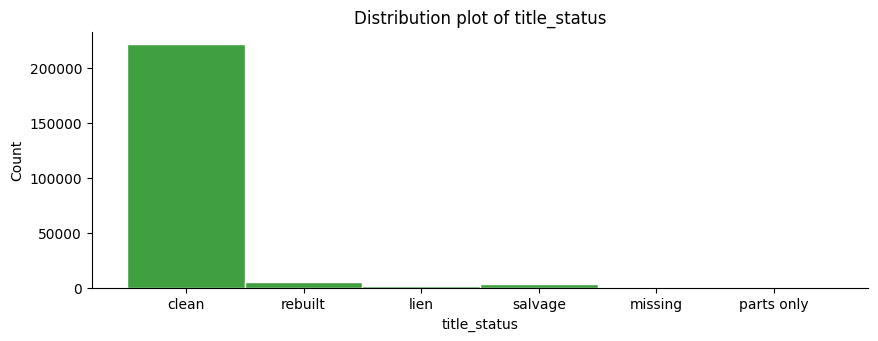

In [11]:
histogram_plotting(data_und, 'title_status', xlabels_rotation=360, size1=(30, 20), size2=[10, 3])

In [12]:
salvage_cars = data_und[data_und["condition"] == "salvage"].index
unclean_cars = data_und[data_und["title_status"] != "clean"].index

data_und.drop(index=salvage_cars, axis=0, inplace=True, errors="ignore")
data_und.drop(index=unclean_cars, axis=0, inplace=True, errors="ignore")
data_und.shape

(221687, 16)



**Price** is the most important variable of the dataset. In the regression model, this would be the target variable to predict. The treatment of errors and outliers in this variable is mandatory. 



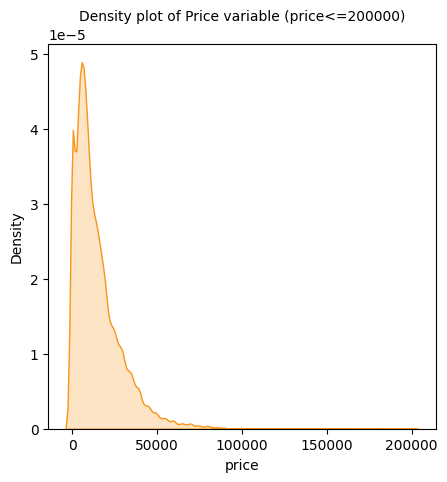

In [13]:
plt.figure(figsize=(5,5))
plt.title('Density plot of Price variable (price<=200000)', fontsize = 10)
sns.kdeplot(data = data_und.query('price<=200000').price, fill = True, color = '#F99417');

As was observed, the price feature is highly skewed. But why? Are there some wrong inserted values in the dataset?

In [14]:
data_und[data_und["price"]>1E5].head(3)

region      price    year manufacturer     model condition  \
280   birmingham  987654321  1960.0    chevrolet       NaN       NaN   
1727  birmingham     130000  2019.0    chevrolet  corvette  like new   
1838      dothan   99999999  1993.0         ford    ranger       NaN   

        cylinders fuel  odometer title_status transmission drive size   type  \
280           NaN  gas  999999.0        clean       manual   NaN  NaN    NaN   
1727  8 cylinders  gas    5000.0        clean    automatic   rwd  NaN  coupe   
1838          NaN  gas   99999.0        clean    automatic   NaN  NaN    NaN   

     paint_color state  
280          NaN    al  
1727        blue    al  
1838         NaN    al

The price of the car with the index 280 is clearly wrong. The same is applied to the car with the index 1838. Furthermore, what about cars with a price less than 100?

In [15]:
data_und[data_und["price"]<100].head(3)

region  price    year manufacturer              model  condition  \
46   auburn      0  2011.0         jeep            compass  excellent   
96   auburn     80  2004.0        honda                NaN  excellent   
126  auburn      0  2018.0    chevrolet  express cargo van   like new   

       cylinders fuel  odometer title_status transmission drive       size  \
46           NaN  gas   99615.0        clean    automatic   NaN  full-size   
96   6 cylinders  gas   94020.0        clean    automatic   NaN        NaN   
126  6 cylinders  gas   68472.0        clean    automatic   rwd  full-size   

    type paint_color state  
46   SUV         NaN    al  
96   NaN         NaN    al  
126  van       white    al

Clearly again these price values seem wrong and should be dropped.

In [16]:
# indentification of extreme price values
# price < 100 $ (keeping the indexes):
min_pr = data_und[data_und["price"] < 100].index
# price < 1000000 $ (keeping the indexes):
max_pr = data_und[data_und["price"] > 1000000].index
#dropping the extreme values:
data_und.drop(index=min_pr, axis=0, errors="ignore", inplace=True)
data_und.drop(index=max_pr, axis=0, errors="ignore", inplace=True)
data_und.shape

(204407, 16)

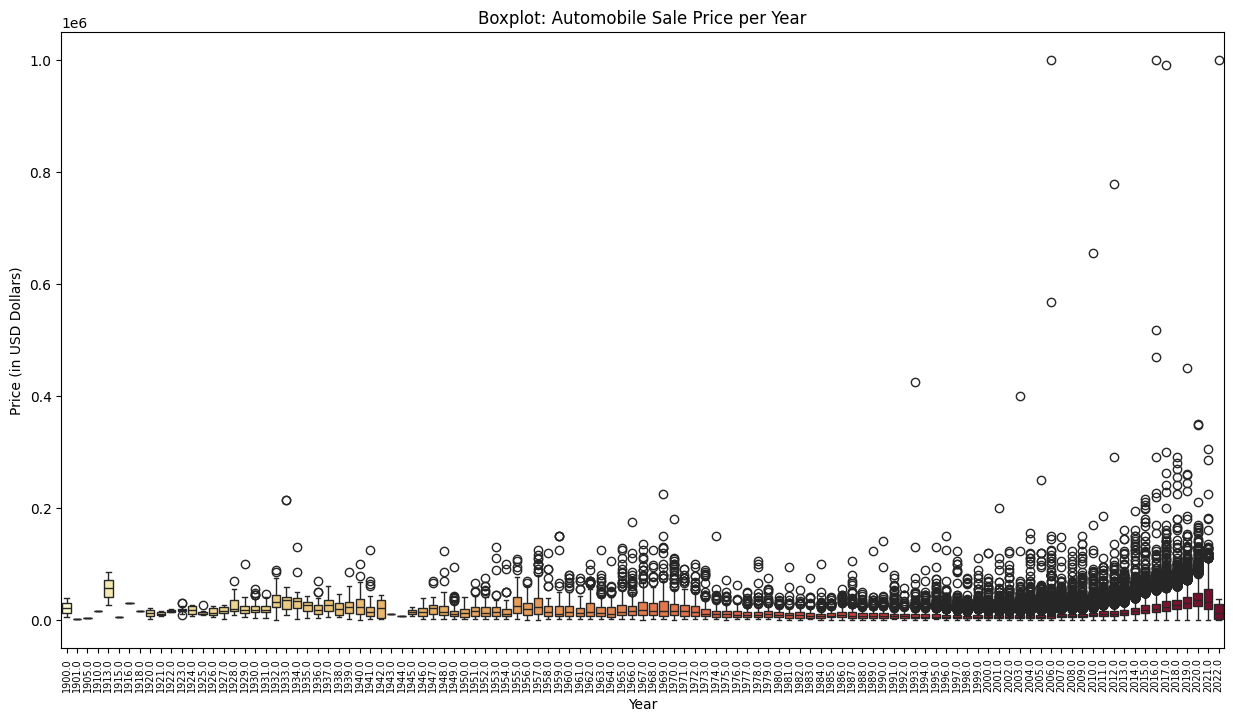

In [17]:
#plotting year vs price, colored by year (boxplot)
plt.figure(figsize=(15, 8))
plt.title('Boxplot: Automobile Sale Price per Year')
sns.boxplot(data=data_und,
            x='year', y='price', hue='year',
            palette = 'YlOrRd', legend=False)
plt.ylabel('Price (in USD Dollars)')
plt.xlabel('Year')
plt.tick_params(axis='x', rotation=90, labelsize= 7)

According to the above graph the presence of outliers is evident. Below I will remove te outliers of price for every year:

In [18]:
data_und = outliers_removal(data = data_und,
                            years_to_check = sorted(data_und["year"].unique()),
                            upper_q = 0.75, low_q = 0.25)
data_und.shape

(203452, 16)

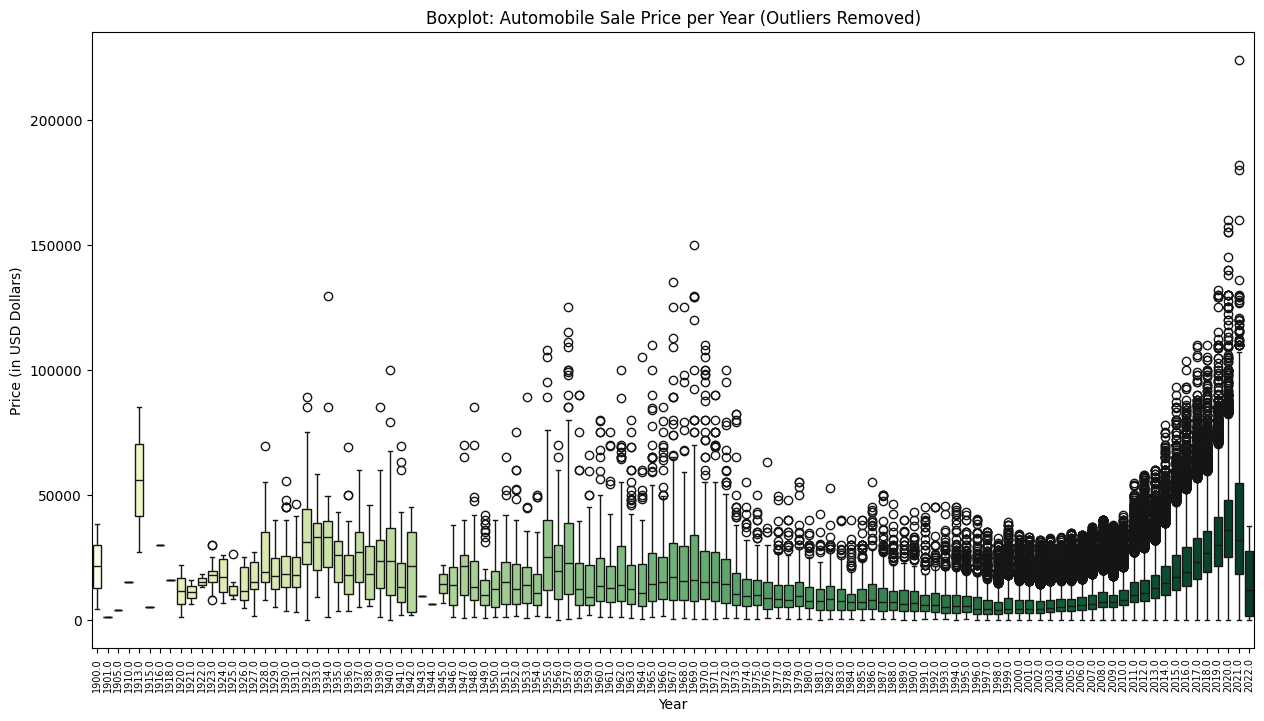

In [19]:
plt.figure(figsize=(15, 8))
plt.title('Boxplot: Automobile Sale Price per Year (Outliers Removed)')
sns.boxplot(data=data_und,
            x='year', y='price', hue='year',
            palette = 'YlGn', legend=False)
plt.ylabel('Price (in USD Dollars)')
plt.xlabel('Year')
plt.tick_params(axis='x', rotation=90, labelsize= 7)

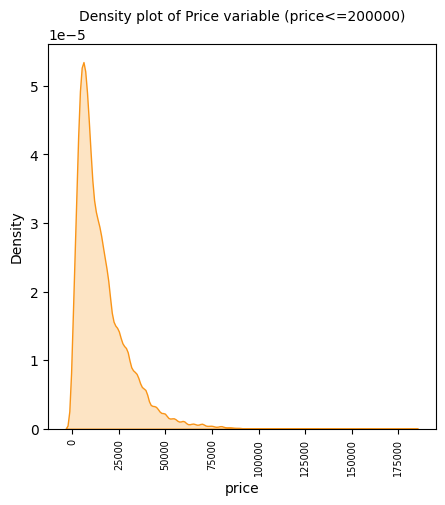

In [20]:
plt.figure(figsize=(5,5))
plt.title('Density plot of Price variable (price<=200000)', fontsize = 10)
sns.kdeplot(data = data_und.query('price<=200000').price, fill = True, color = '#F99417')
plt.tick_params(axis='x', rotation=90, labelsize= 7);

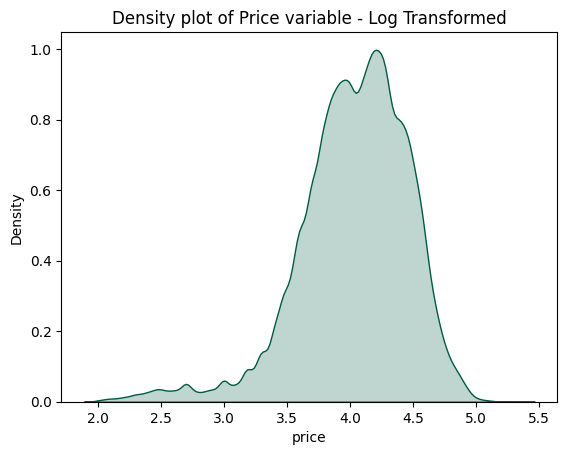

In [21]:
plt.title('Density plot of Price variable - Log Transformed')
sns.kdeplot(data = np.log10(data_und.price), fill = True, color = '#005B41');

As demonstrated above, the Price will log-transformed. In this way, we can tackle the skewness of Price.

In the same logic I will investigate the **odometer** feature:

<Figure size 3000x2000 with 0 Axes>

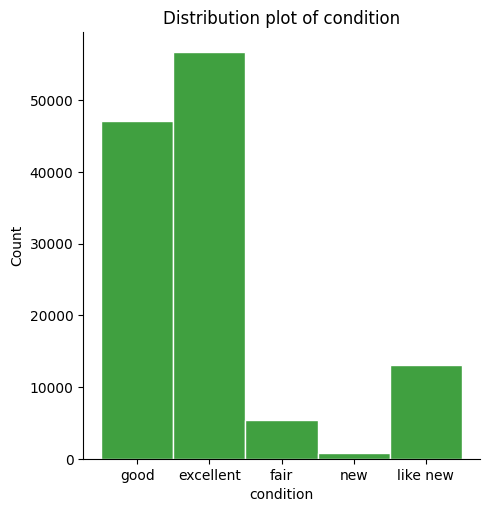

In [22]:
histogram_plotting(data_und, 'condition', xlabels_rotation=360, size1=(30, 20), size2=[5, 5])

In [23]:
# odometer is less than 800 and car condition is not 'new' or 'like new':
low_odom_extremes = data_und[(data_und['odometer'] < 800) & (data_und['condition'] != 'new') & (data_und['condition'] != 'like new')].index
# odometer is more than 380,000:
high_odom_extremes = data_und[(data_und['odometer'] > 380000)].index

data_und.drop(index=low_odom_extremes, axis=0, errors="ignore", inplace=True)
data_und.drop(index=high_odom_extremes, axis=0, errors="ignore", inplace=True)
data_und.shape

(198905, 16)

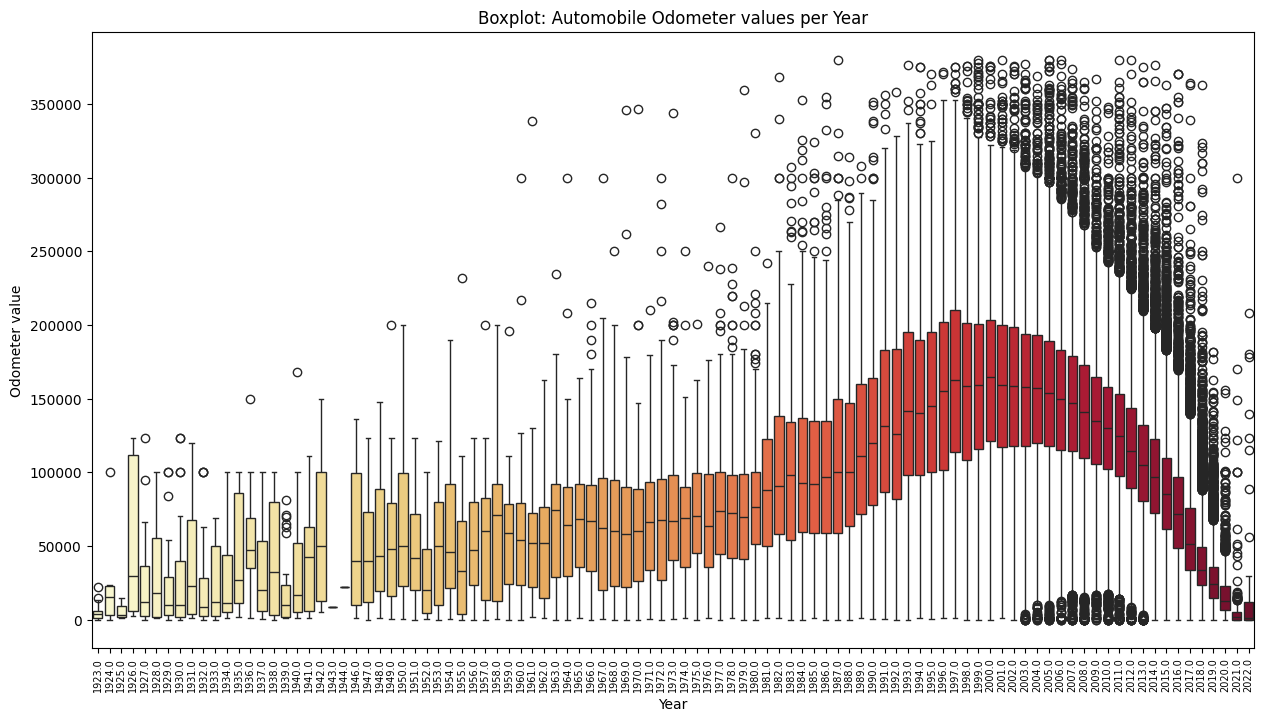

In [24]:
plt.figure(figsize=(15, 8))
plt.title('Boxplot: Automobile Odometer values per Year')
sns.boxplot(data=data_und.query('year>1922'), #there are possibly wrong values that change the presentation of the dataset
            x='year', y='odometer', hue='year',
            palette = 'YlOrRd', legend=False)
plt.ylabel('Odometer value')
plt.xlabel('Year')
plt.tick_params(axis='x', rotation=90, labelsize= 7)

In [25]:
data_und = outliers_removal(data = data_und,
                            feature='odometer',
                            years_to_check = sorted(data_und["year"].unique()),
                            upper_q = 0.75, low_q = 0.25)
data_und.shape

(198819, 16)

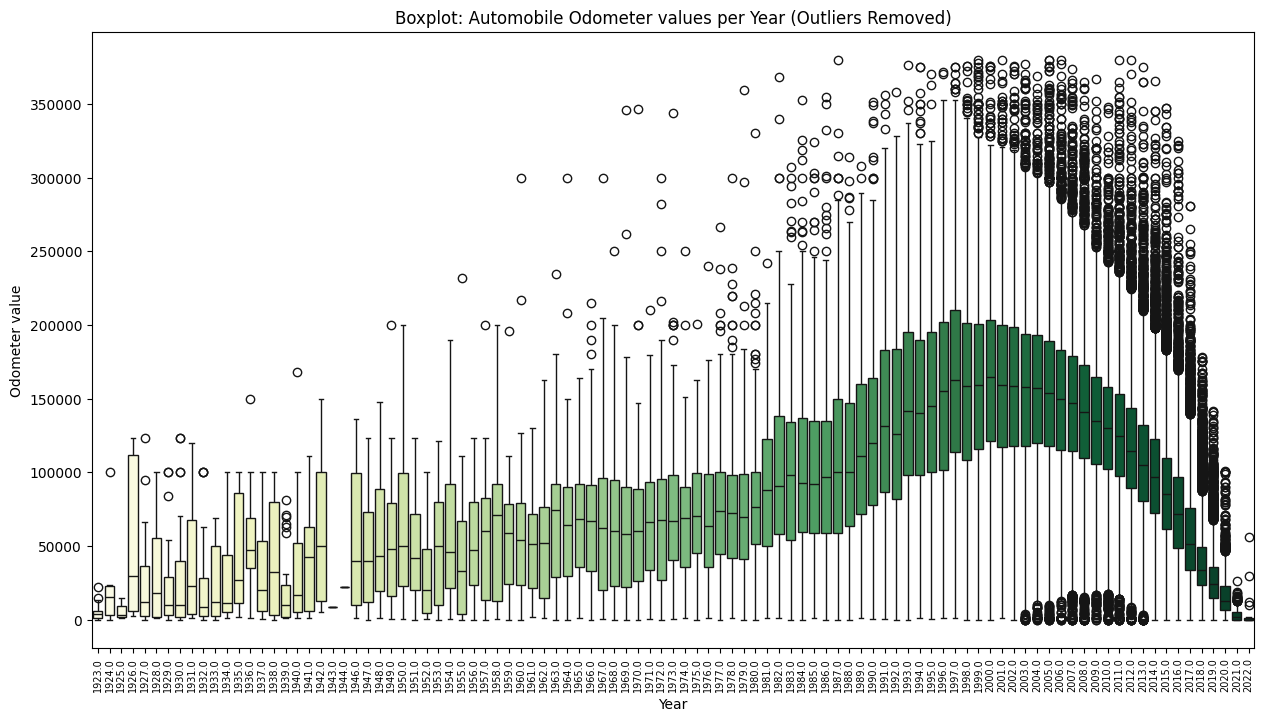

In [26]:
plt.figure(figsize=(15, 8))
plt.title('Boxplot: Automobile Odometer values per Year (Outliers Removed)')
sns.boxplot(data=data_und.query('year>1922'), #there are possibly wrong values that change the presentation of the dataset
            x='year', y='odometer', hue='year',
            palette='YlGn', legend=False)
plt.ylabel('Odometer value')
plt.xlabel('Year')
plt.tick_params(axis='x', rotation=90, labelsize=7)


Now, I will remove the outlier values for the **year** feature. In this case, based on the graph below from the previous graphs, I will make two assumptions.

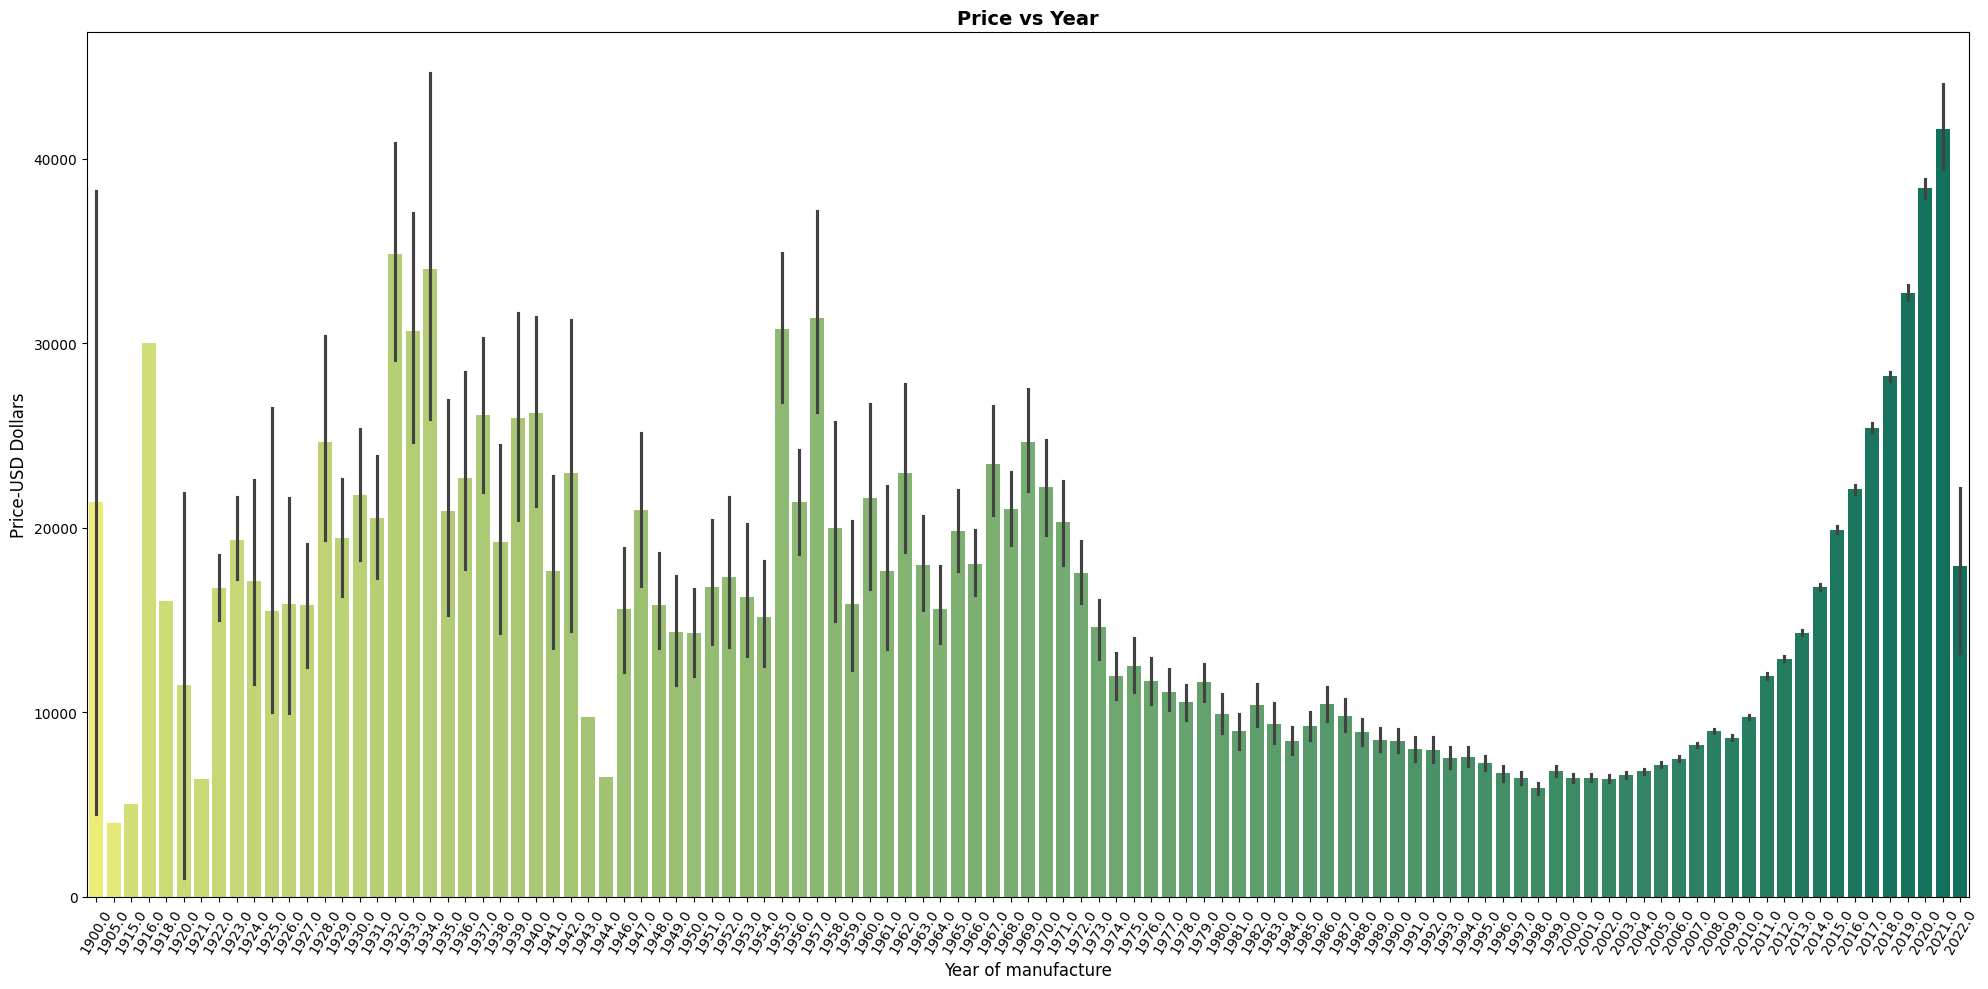

In [27]:
plt.figure(figsize =(20,10))
plt.title('Price vs Year',fontsize=14, fontweight ='bold')
sns.barplot(data=data_und,
            x='year', y='price', hue='year',
            palette='summer_r', legend=False)
plt.xlabel('Year of manufacture',fontsize = 12)
plt.xticks(rotation=60)
plt.ylabel('Price-USD Dollars',fontsize = 12)
plt.tight_layout()

1. As the lower limit: I will only consider cars starting from the year 1908 which is when the [first mass production car was produced](https://en.wikipedia.org/wiki/Ford_Model_T).

In [28]:
year_l = data_und[data_und['year'] < 1908].index
data_und.drop(index=year_l, axis=0, errors='ignore', inplace=True)

2. As the upper limit: I will eliminate the year 2022. It has very few data points, and its statistics will not be representative. The year 2021 is acceptable since it has at least around 500 values. A good sample is the year of 2020.

In [29]:
print('2022 observations: '+str( data_und[data_und['year'] == 2022].shape[0])+'\n' )
print('2021 observations: '+str( data_und[data_und['year'] == 2021].shape[0])+'\n' )
print('2020 observations: '+str( data_und[data_und['year'] == 2020].shape[0])+'\n' )

2022 observations: 30

2021 observations: 571

2020 observations: 5362



In [30]:
# keeping indexes of data with year value > 2021
year_h = data_und[data_und['year'] > 2021].index
# dropping the data with indexes i year_h:
data_und.drop(index=year_h, axis=0, inplace=True, errors='ignore')
data_und.shape

(198786, 16)

**There are two segments according to the year feature.**

The **first**, is the post-1998 in which the price of the car is growing per year.

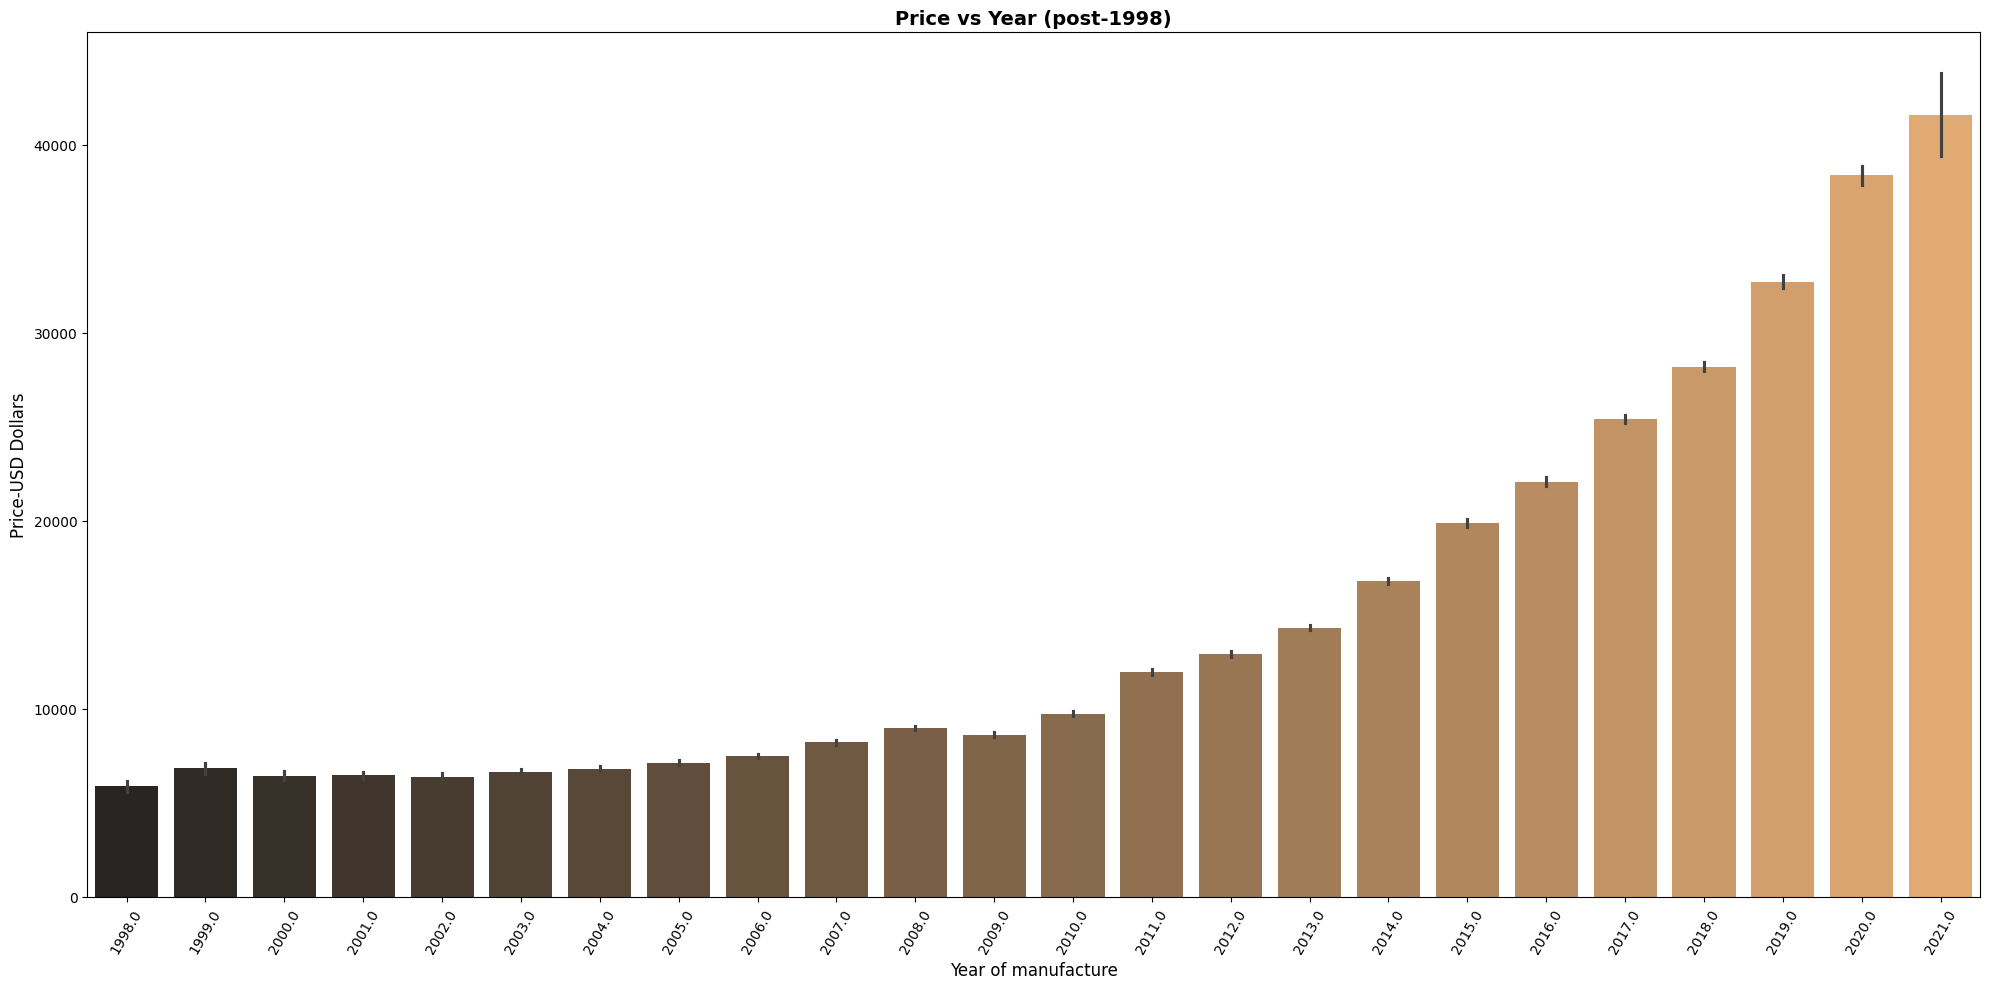

In [31]:
#plotting year vs price
plt.figure(figsize =(20,10))
plt.title('Price vs Year (post-1998)',fontsize=14, fontweight ='bold')
sns.barplot(data=data_und.query('year>=1998'),
            x='year', y='price', hue='year',
            palette='dark:#F3AA60', legend=False)
plt.xlabel('Year of manufacture',fontsize = 12)
plt.xticks(rotation=60)
plt.ylabel('Price-USD Dollars',fontsize = 12)
plt.tight_layout()

The **second**, is the pre-1998 in which the price of the car is slightly reducing per year.

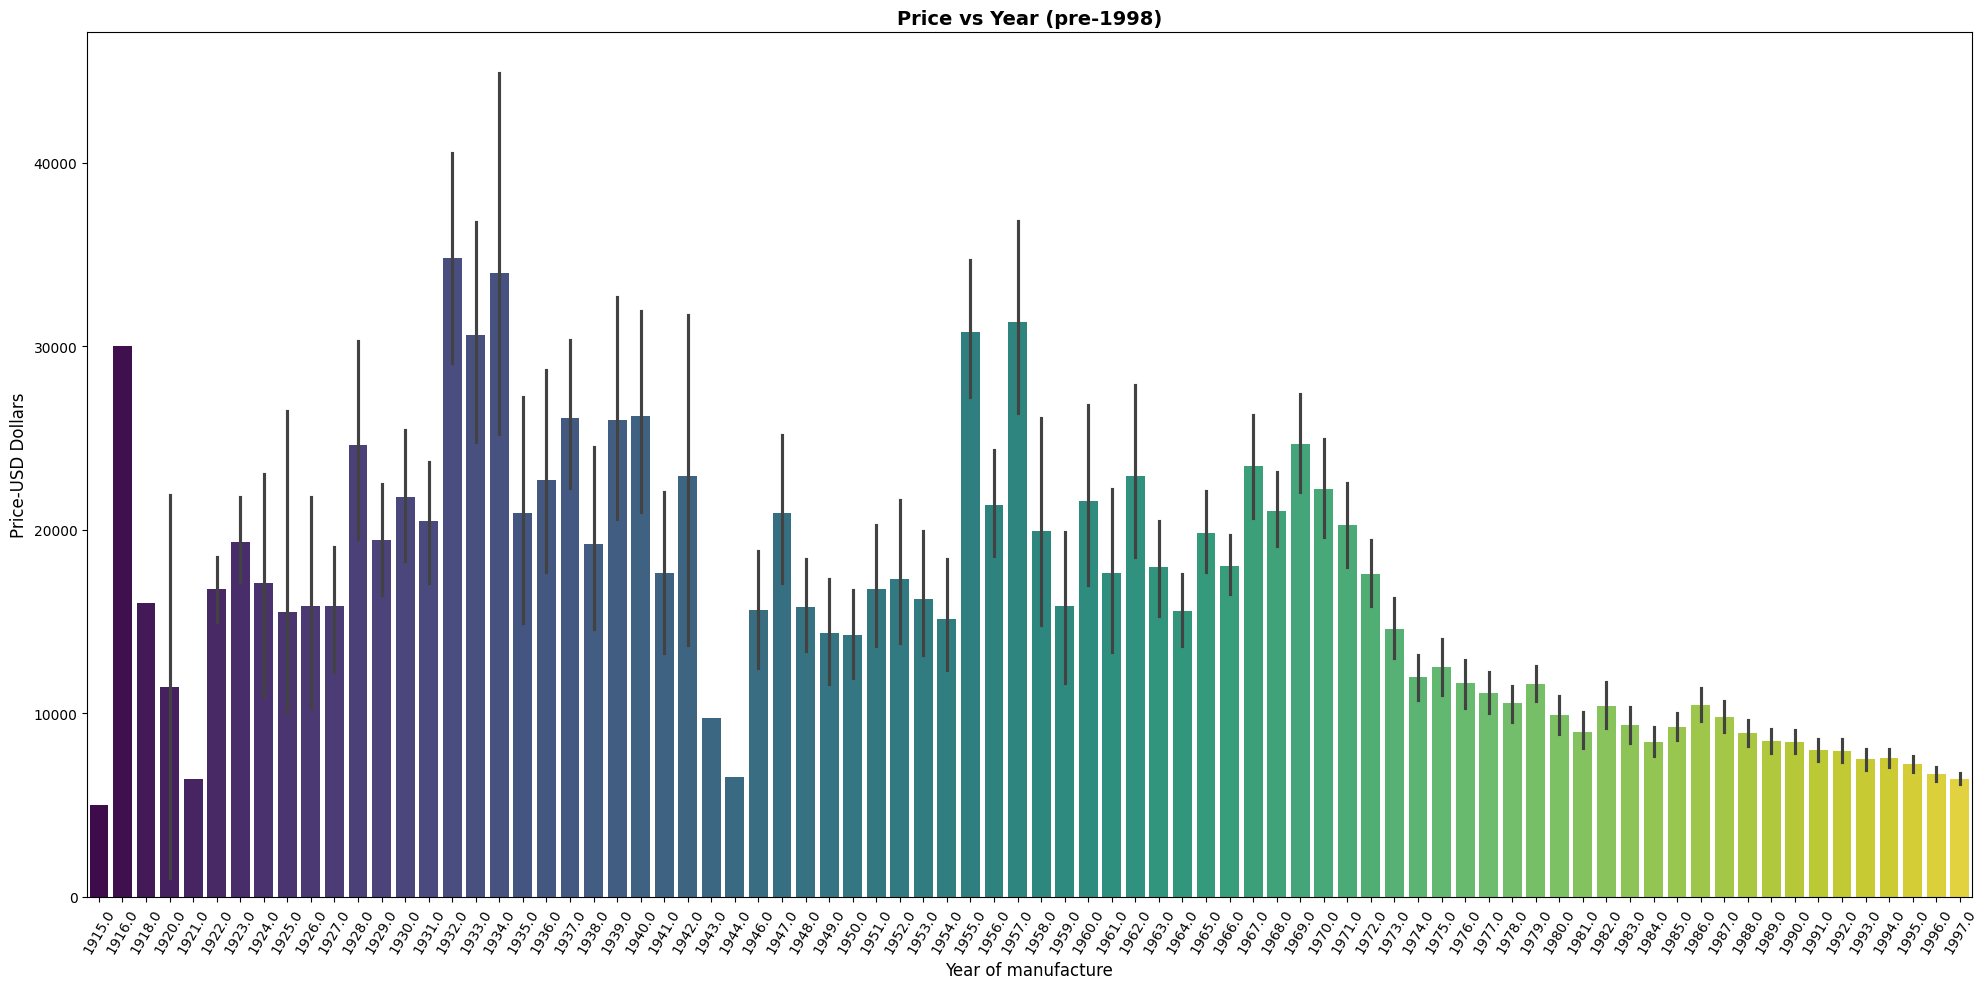

In [32]:
#plotting year vs price

plt.figure(figsize =(20,10))
plt.title('Price vs Year (pre-1998)',fontsize=14, fontweight ='bold')
sns.barplot(data=data_und.query('year<1998'),
            x='year', y='price', hue='year',
            palette='viridis', legend=False)
plt.xlabel('Year of manufacture',fontsize = 12)
plt.xticks(rotation=60)
plt.ylabel('Price-USD Dollars',fontsize = 12)
plt.tight_layout()

Watching the graph above, I could also create a **third market profile**: cars before the year 1969 (antiques).

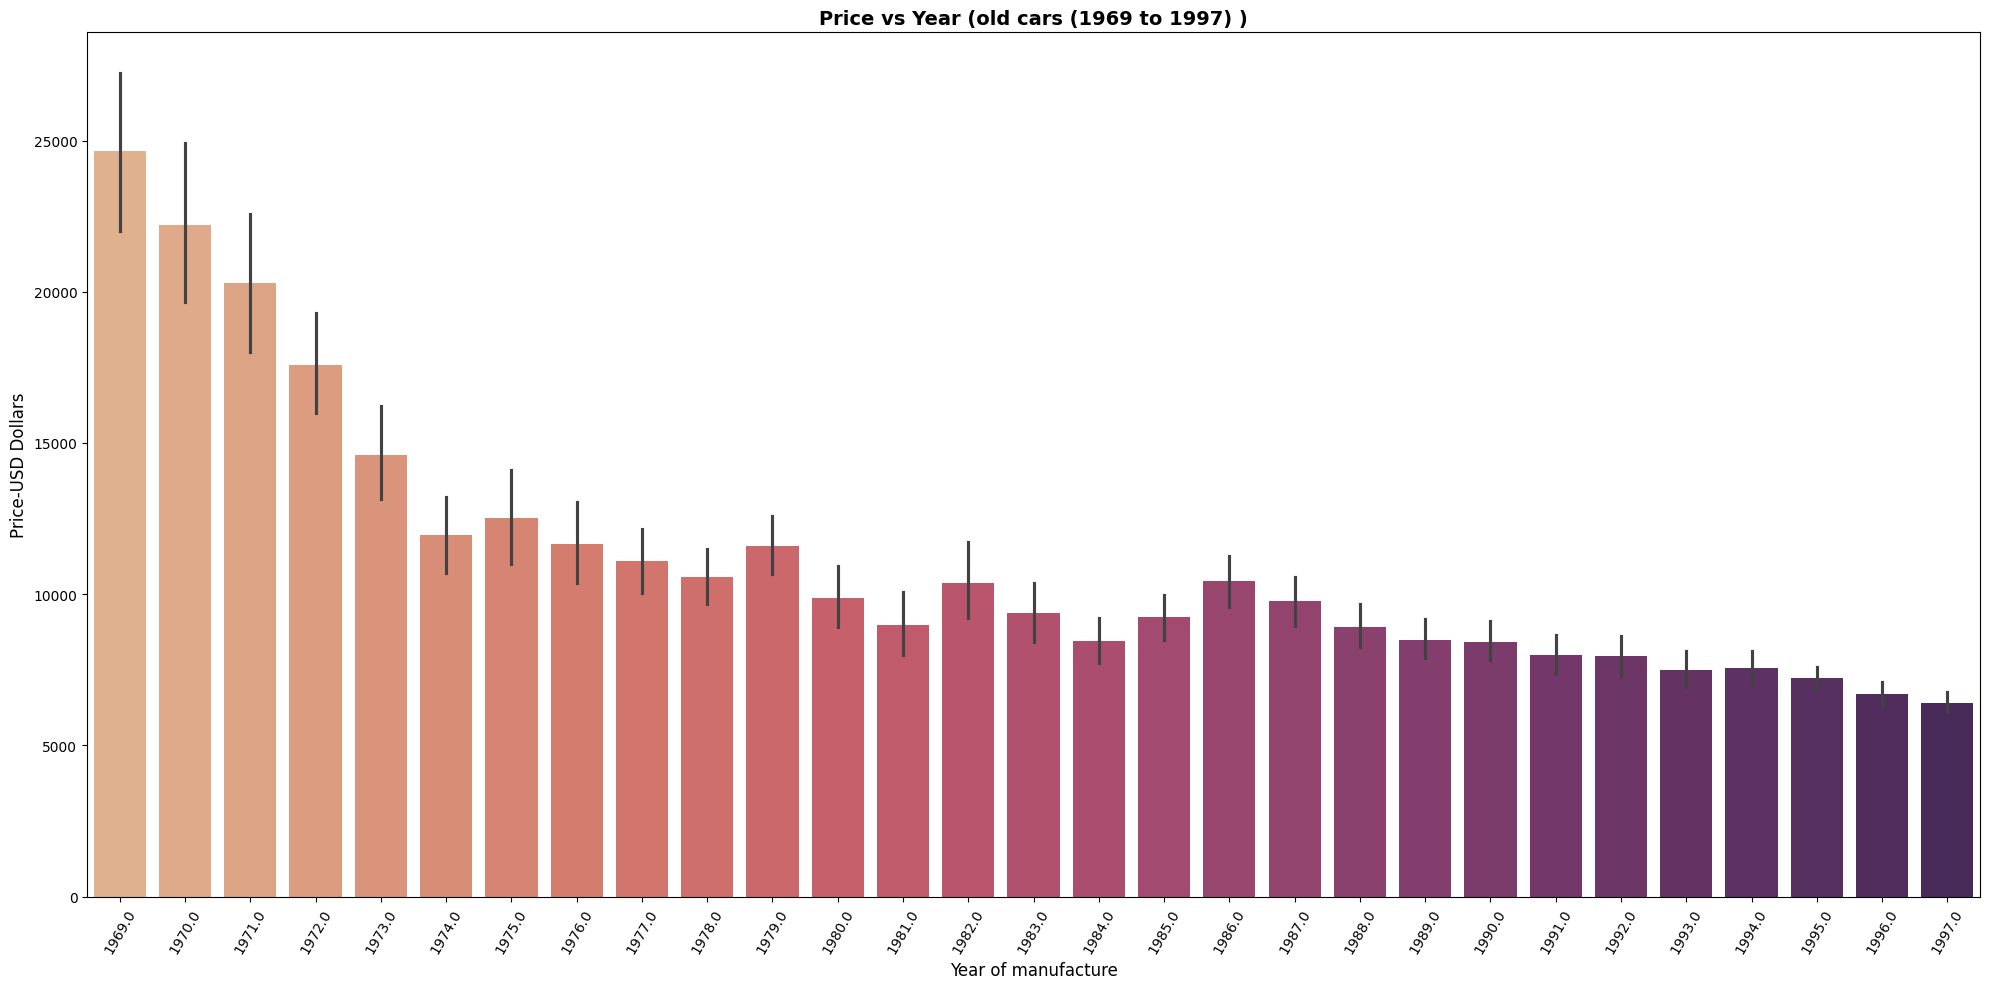

In [33]:
#plotting year vs price
plt.figure(figsize =(20,10))
plt.title('Price vs Year (old cars (1969 to 1997) )',fontsize=14, fontweight ='bold')
sns.barplot(data=data_und.query('year>=1969 and year<1998'),
            x='year', y='price', hue='year',
            palette='flare', legend=False)
plt.xlabel('Year of manufacture',fontsize = 12)
plt.xticks(rotation=60)
plt.ylabel('Price-USD Dollars',fontsize = 12)
plt.tight_layout()

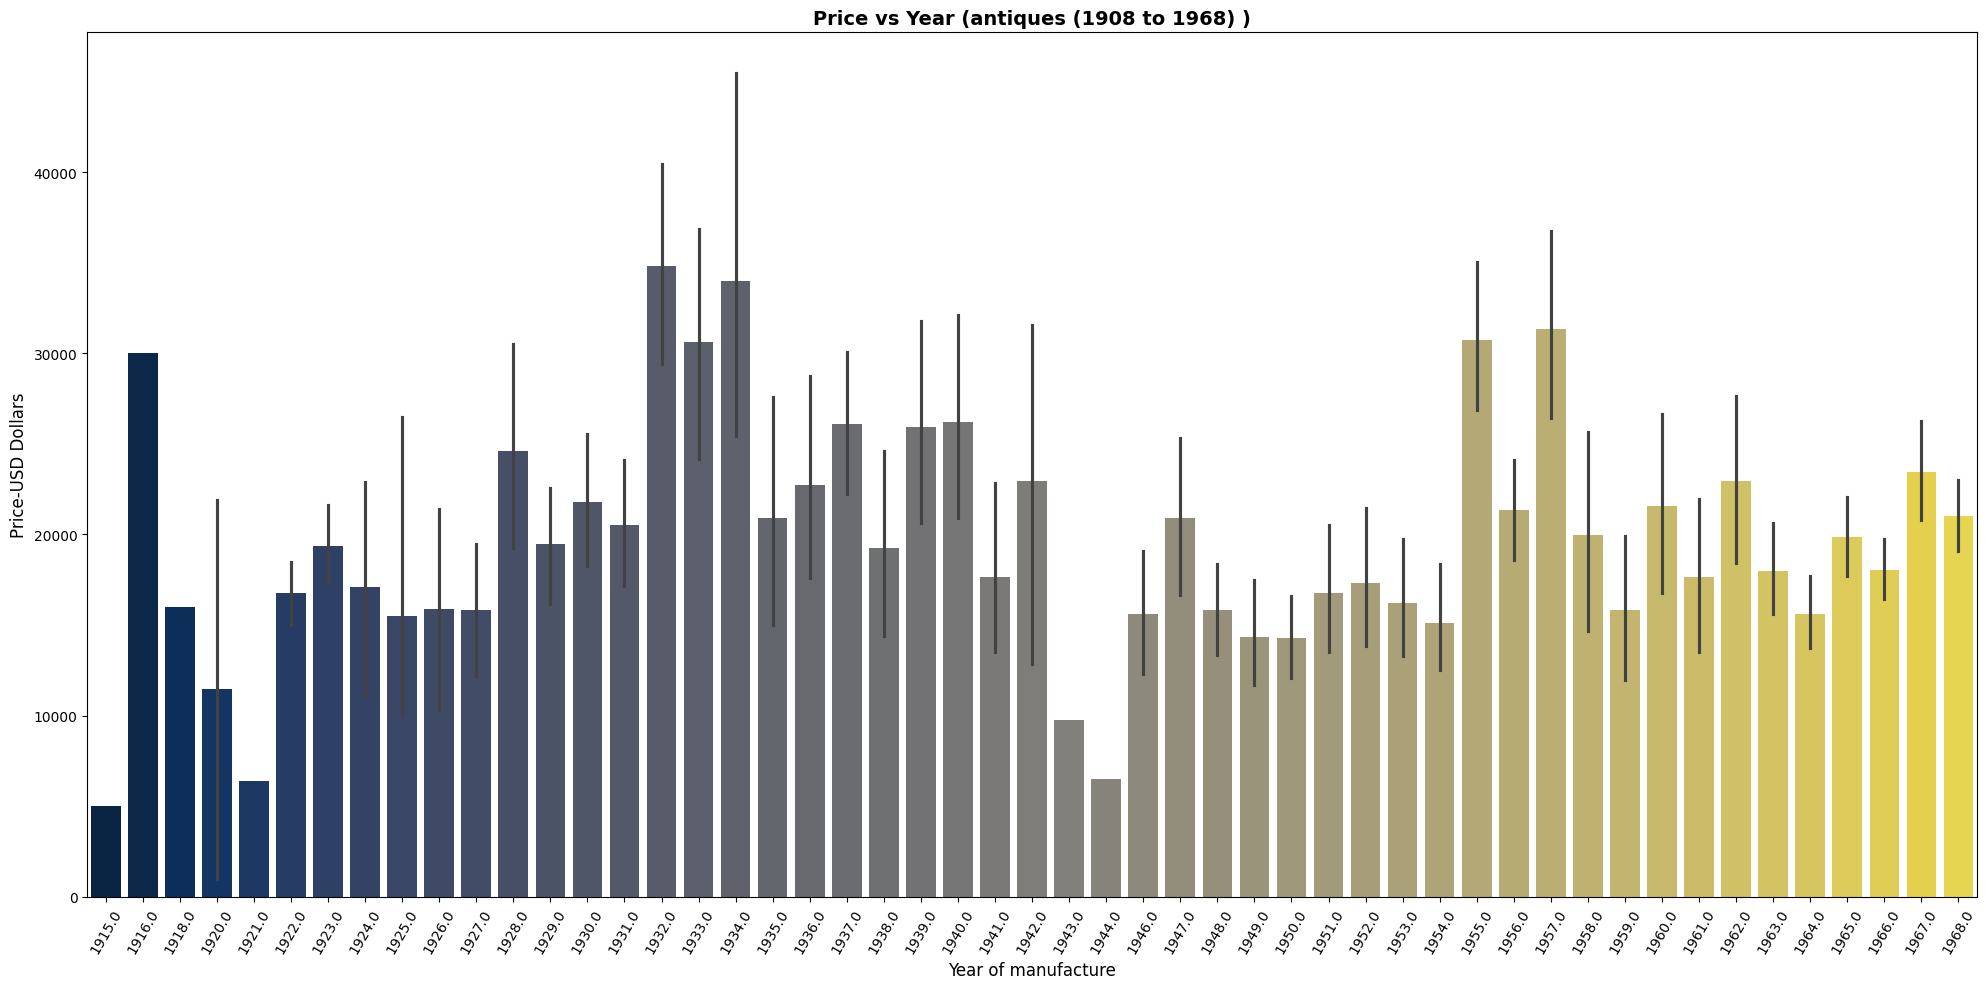

In [34]:
#plotting year vs price
plt.figure(figsize =(20,10))
plt.title('Price vs Year (antiques (1908 to 1968) )',fontsize=14, fontweight ='bold')
sns.barplot(data=data_und.query('year<1969'),
            x='year', y='price', hue='year',
            palette='cividis', legend=False)
plt.xlabel('Year of manufacture',fontsize = 12)
plt.xticks(rotation=60)
plt.ylabel('Price-USD Dollars',fontsize = 12)
plt.tight_layout()

Summing up, I will create **three segments** of the used cars' market price data **according to the variable of the year**:
- The **first** will be the **newer generation cars** (year >= 1998), where the newer cars have higher prices.
- The **second** will be the **old cars** (year >= 1969 and year < 1998), where the newer cars have lower prices.
- The **third** will be the **antiques** (year < 1969), where there is no distinctive trend of price vs year.

In [35]:
data_und['segment'] = None # create a new column in data_und
data_copy = data_und.copy(deep = True) # make a copy of the data_und
#data_copy['year'] = data_copy['year'].astype('object') # convert year values to object type in order to use the .replace()

for i in data_und.query('year<1969')['year'].sort_values().unique().tolist(): 
        data_copy['year'].replace(i, 'antiques', inplace=True)
    
for i in data_und.query('year >= 1969 and year < 1998')['year'].sort_values().unique().tolist():
        data_copy['year'].replace(i, 'old cars', inplace=True)
    
for i in data_und.query('year >= 1998')['year'].sort_values().unique().tolist():
        data_copy['year'].replace(i, 'newer generation cars', inplace=True)
    
data_und['segment']  = data_copy['year']

#check:
print(data_und.columns)

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'segment'],
      dtype='object')


##### Understanding and cleaning Null values
 
Furthermore, many features contain null values, which should be handled accordingly.
The counts of null values per feature are demonstrated below:

<Axes: title={'center': 'Count of Null values per Feature'}, xlabel='Features', ylabel='Count'>

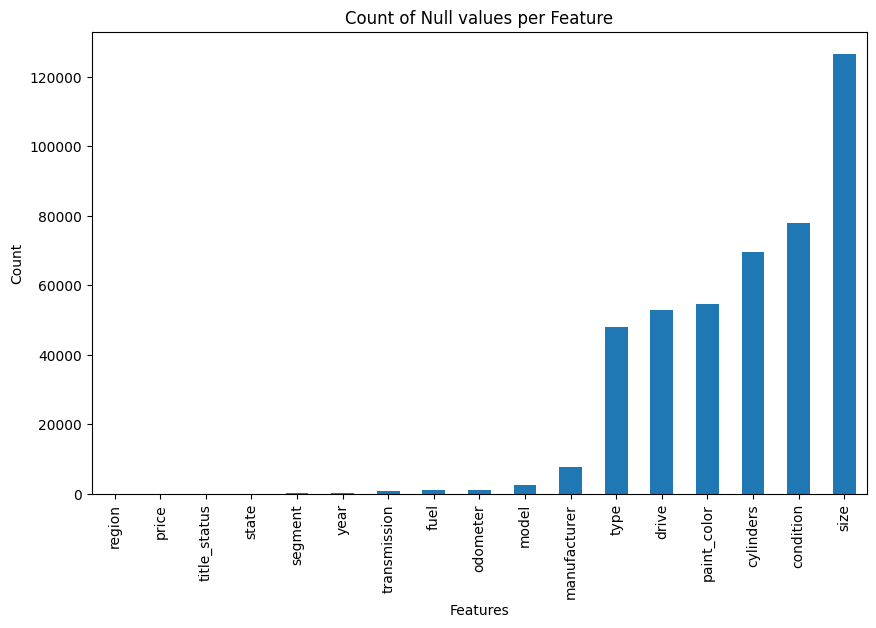

In [36]:
plt.figure(figsize=(10,6))
data_und.isnull().sum().sort_values().plot(kind = 'bar',
                                           title = 'Count of Null values per Feature',
                                           xlabel = 'Features',
                                           ylabel = 'Count',
                                           )

Also, a plot of the percentage of null values per feature is demonstrated below:

<Axes: title={'center': 'Percentage of Null values per Feature'}, xlabel='Features', ylabel='Percentage'>

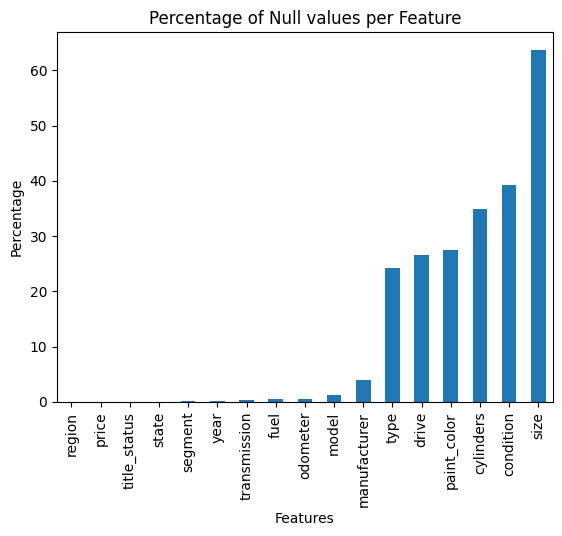

In [37]:
temp = data_und.isna().sum() / data_und.shape[0] * 100
temp.sort_values().plot(kind = 'bar',
      title = 'Percentage of Null values per Feature',
      xlabel = 'Features',
      ylabel = 'Percentage')

I will drop the feature size as around 60% of its data are nulls. Also, I will drop the title_status as all of its values are 'clean'.

In [38]:
data_und.drop(columns=['size', 'title_status'], inplace=True) #dropping size and title_status features
data_und.shape

(198786, 15)

##### The initial data cleansing is completed, so I will drop all the null values (rows that contain nulls) in my dataset:

In [39]:
data_und.dropna(inplace=True) #dropping rows that contain at least one null vale

What are the remaining columns and observations in the dataset?

In [40]:
data_und.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'transmission', 'drive', 'type',
       'paint_color', 'state', 'segment'],
      dtype='object')

In [41]:
# shape of cleaned dataset:
print('Shape of cleaned dataset: '+str(data_und.shape)+'\n')
# percentage of remaining data according to the initial imported dataset:
print('Percentage of remaining data according to the initial imported dataset: '+str(np.round((data_und.shape[0] / initial_data_shape[0]) * 100, 2))+'%\n')
# info of the of cleaned dataset:
data.info(show_counts=False)

Shape of cleaned dataset: (66969, 15)

Percentage of remaining data according to the initial imported dataset: 15.69%

<class 'pandas.core.frame.DataFrame'>
Index: 66969 entries, 31 to 426833
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   region        object 
 1   price         int64  
 2   year          float64
 3   manufacturer  object 
 4   model         object 
 5   condition     object 
 6   cylinders     object 
 7   fuel          object 
 8   odometer      float64
 9   transmission  object 
 10  drive         object 
 11  type          object 
 12  paint_color   object 
 13  state         object 
 14  segment       object 
dtypes: float64(2), int64(1), object(12)
memory usage: 8.2+ MB


I will change the data type of odometer and year to int64

In [42]:
#changing types for odometer and year:
data_und['odometer'] = data_und['odometer'].astype("int64")
data_und['year'] = data_und['year'].astype("int64")

##### Further Analysis of features:

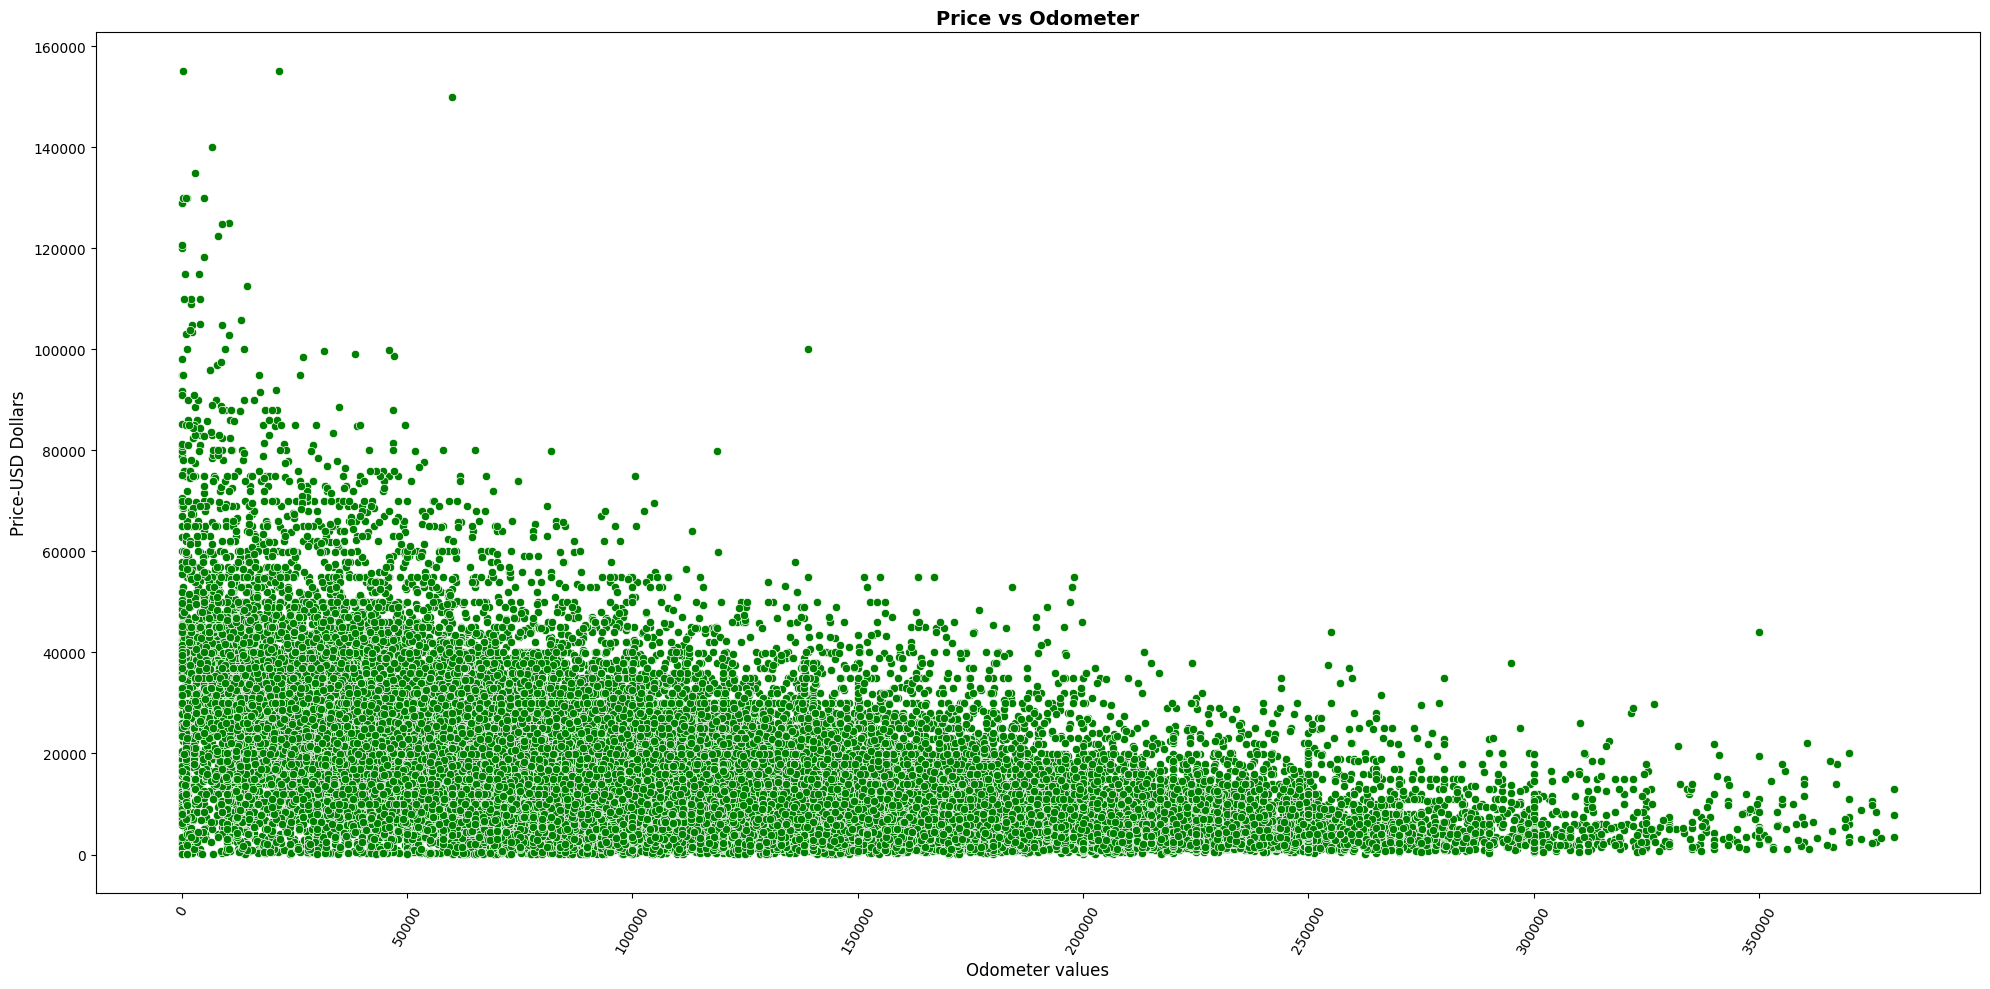

In [43]:
#plot of price vs odometer (scatterplot)
plt.figure(figsize =(20,10))
plt.title("Price vs Odometer", fontsize=14, fontweight ='bold')
sns.scatterplot(data = data_und, y ='price',x ='odometer', color="green")
plt.xlabel('Odometer values',fontsize = 12)
plt.xticks(rotation=60)
plt.ylabel('Price-USD Dollars',fontsize = 12)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Correlations Heatmap (post-1998, new-generation cars)'}>

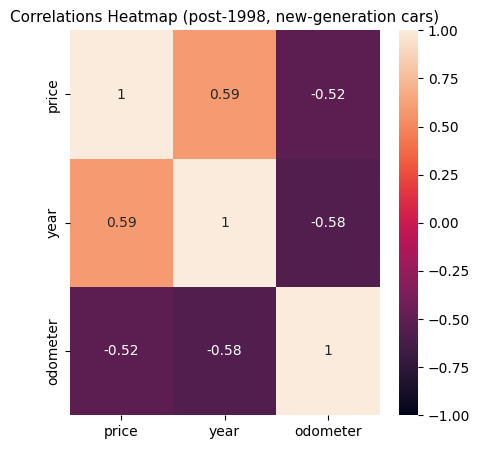

In [44]:
# correlation heatmap plot (new-generation cars)
plt.figure(figsize=(5,5))
plt.title('Correlations Heatmap (post-1998, new-generation cars)', fontsize = 11)
sns.heatmap(data_und.query('year>=1998').corr(numeric_only=True), annot=True, vmin= -1, vmax = 1)

<Axes: title={'center': 'Correlations Heatmap (old cars (year<1998 and year>=1969)'}>

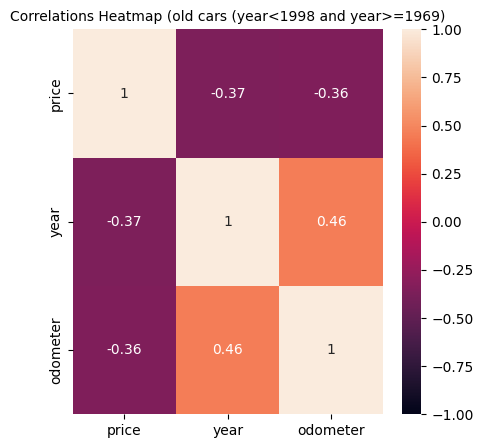

In [45]:
# correlation heatmap plot (old cars)
plt.figure(figsize=(5,5))
plt.title('Correlations Heatmap (old cars (year<1998 and year>=1969)', fontsize = 10)
sns.heatmap(data_und.query('year<1998 and year>=1969').corr(numeric_only=True), annot=True, vmin= -1, vmax = 1)

<Axes: title={'center': 'Correlations Heatmap (antiques (year < 1969) )'}>

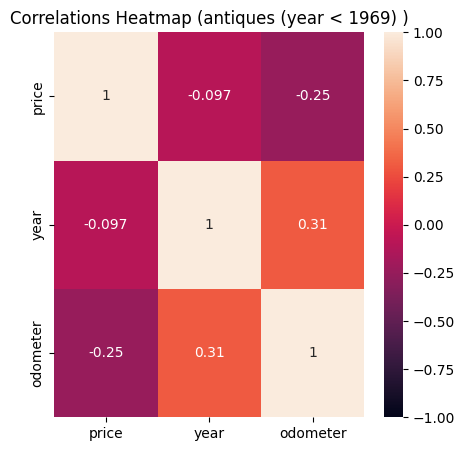

In [46]:
# correlation heatmap plot (antiques)
plt.figure(figsize=(5,5))
plt.title('Correlations Heatmap (antiques (year < 1969) )')
sns.heatmap(data_und.query('year<1969').corr(numeric_only=True), annot=True, vmin= -1, vmax = 1)

From the heatmaps above, I can conclude:
- The **odometer** variable is **correlated / anti-correlated** with the variable **year**. 
- For **old and new-generation cars**, I should **only keep either the year or the odometer** in my modelling phase. In this way, I will mitigate the risk of multicollinearity.
- For antiques, I should **only use the odometer**.

Paiplot of numeric features:

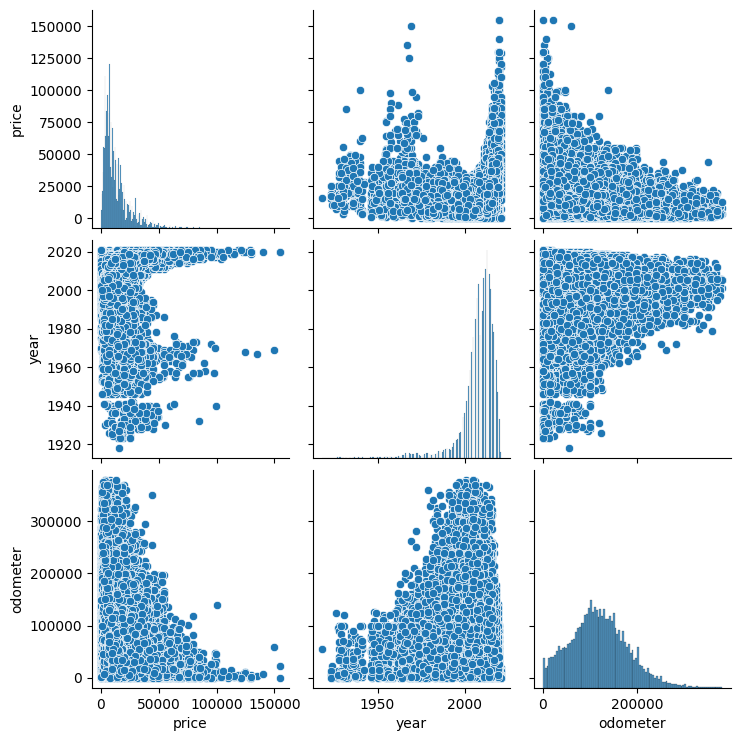

In [47]:
#paiplot:
sns.pairplot(data=data_und)

Price, year and odometer are skewed. I should consider to log-transform the target variable (price).
Below, I apply log-transform to price and box-cox transformation to odometer and year:

In [48]:
# applying box-cox transformation to year and odometer
pt = PowerTransformer(method='box-cox', standardize=False)
year_tr = pt.fit_transform(data_und[['year']],)
odometer_tr = pt.fit_transform(data_und[['odometer']].replace(to_replace=0, value=0.01, inplace = False) ) #Box-cox cannot be applied to zero values, so I replace zeros to 0.01 to apply box-cox.
price_tr = np.array(np.log10(data_und.price))

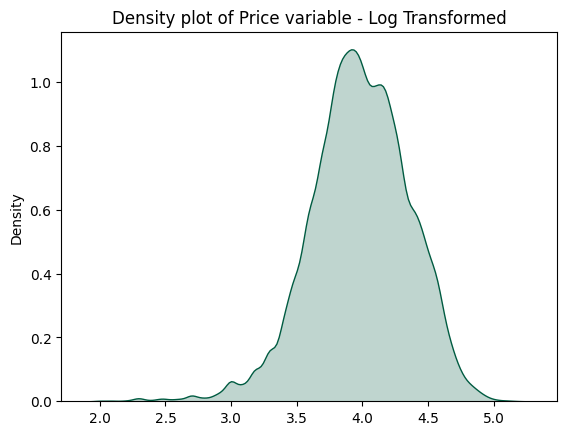

In [49]:
# plotting density plot of log-transformed price:
plt.title('Density plot of Price variable - Log Transformed')
sns.kdeplot(data = price_tr, fill = True, color = '#005B41');

I should **log-transform the target variable (price)** in the data preparation phase. 

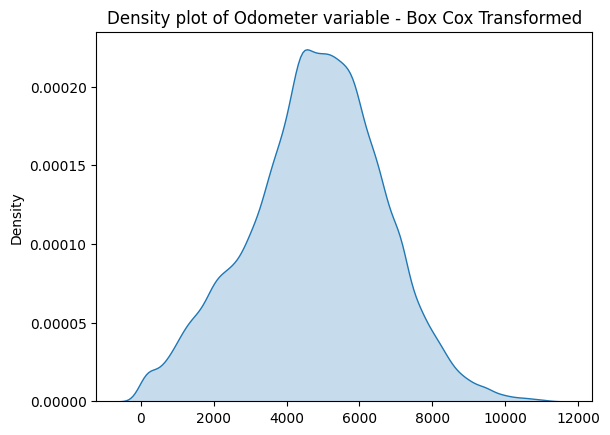

In [50]:
# plotting density plot of transformed Odometer:
plt.title('Density plot of Odometer variable - Box Cox Transformed')
sns.kdeplot(data = odometer_tr, fill = True, color = '#005B41', legend=False);

<Axes: title={'center': 'Density plot of Year variable - Box Cox Transformed'}, ylabel='Density'>

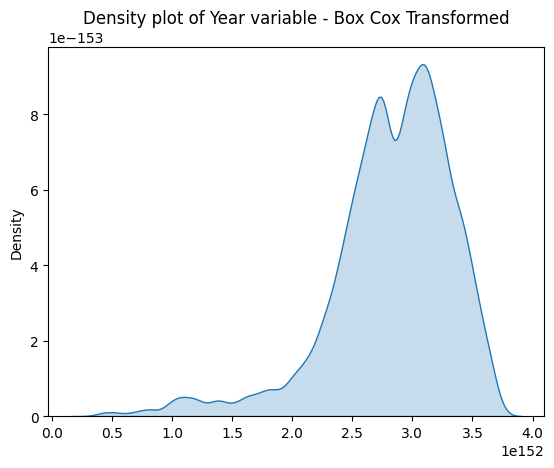

In [51]:
# plotting density plot of transformed Year:
plt.title('Density plot of Year variable - Box Cox Transformed')
sns.kdeplot(data = year_tr, fill = True, color = '#005B41', legend=False)

<Figure size 3000x2000 with 0 Axes>

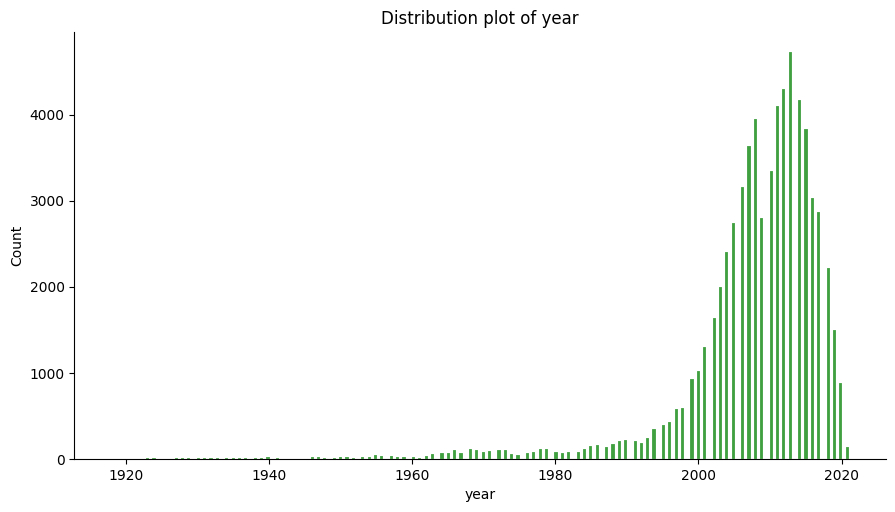

In [52]:
histogram_plotting(data_und, 'year', xlabels_rotation = 360, size1 = (30,20), size2 = [10, 5])

Most of the vehicles fall into the utility car range (1998 to 2021).

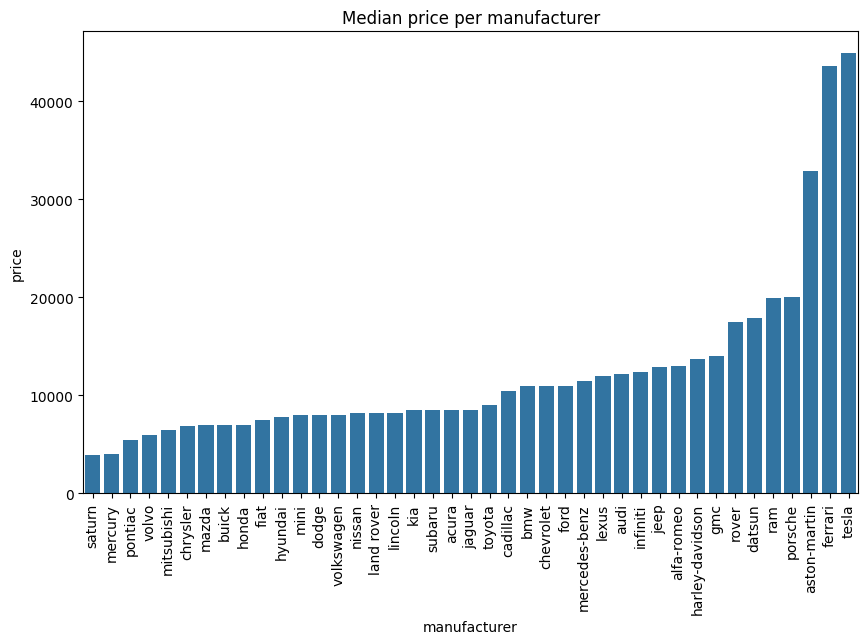

In [53]:
plt.figure(figsize=(10,6))
plt.title('Median price per manufacturer')
sns.barplot(data = data_und.groupby('manufacturer').median('price').reset_index().sort_values(by = 'price')[['manufacturer','price']],
            x = 'manufacturer',
            y = 'price')
plt.xticks(rotation = 90);

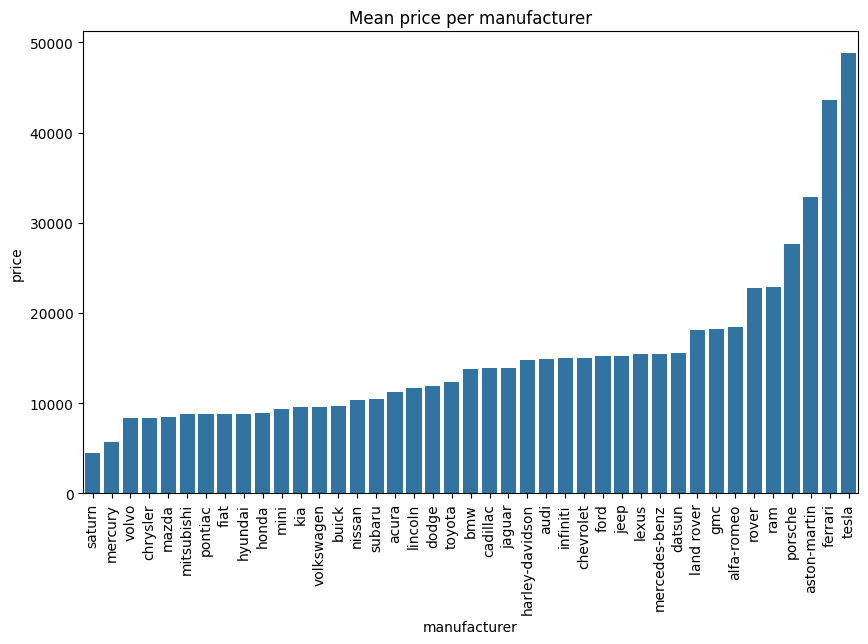

In [54]:
plt.figure(figsize=(10,6))
plt.title('Mean price per manufacturer')
ax2 = sns.barplot(data = data_und.groupby('manufacturer').mean('price').sort_values(by = 'price').reset_index()[['manufacturer','price']],
                  x = 'manufacturer',
                  y = 'price')
plt.xticks(rotation = 90);

According with the median and mean graphs above, I could create a new feature: A column named manufacturer cluster.
This feature will contain the 3 clusters of manufactures ranked by the cars' median sale price. More specifically:
- **Cluster 1**: manufacturers that create cars with a median sale price <=10000
- **Cluster 2**: manufacturers that create cars with a median sale price between 10000 and 19999
- **Cluster 3**: manufacturers that create cars with a median sale price between > 19999

If I use this feature in one hot encoding I could reduce the model's complexity (when transforming the data through One-Hot Encoding)

In [55]:
# Cluster 1: group by manufacturer, calculate the median price per group (manufacturer) and select only the manufacturers with a median sale price <= 10000 
cl1 = data_und.groupby('manufacturer').median('price').reset_index().sort_values(by = 'price').query('price<=10000').manufacturer

# Cluster 2: group by manufacturer, calculate the median price per group (manufacturer) and select only the manufacturers with a median sale price between 10000 and 19999 
cl2 = data_und.groupby('manufacturer').median('price').reset_index().sort_values(by = 'price').query('price>10000 and price<=19999').manufacturer

# Cluster 3: group by manufacturer, calculate the median price per group (manufacturer) and select only the manufacturers with a median sale price >= 19999 
cl3 = data_und.groupby('manufacturer').median('price').reset_index().sort_values(by = 'price').query('price>=19999').manufacturer

# Check:
cl3

32         porsche
2     aston-martin
11         ferrari
37           tesla
Name: manufacturer, dtype: object

Creation of feature in the dataset:

In [56]:
# creating the new manufacturer_cluster feature:
data_und['manufacturer_cluster'] = None 
data_copy = data_und.copy(deep = True)

for i in cl1.tolist(): data_copy['manufacturer'].replace(i, '1', inplace=True)
for i in cl2.tolist(): data_copy['manufacturer'].replace(i, '2', inplace=True)
for i in cl3.tolist(): data_copy['manufacturer'].replace(i, '3', inplace=True)
data_und['manufacturer_cluster']  = data_copy['manufacturer']

#check:
data_und.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'transmission', 'drive', 'type',
       'paint_color', 'state', 'segment', 'manufacturer_cluster'],
      dtype='object')

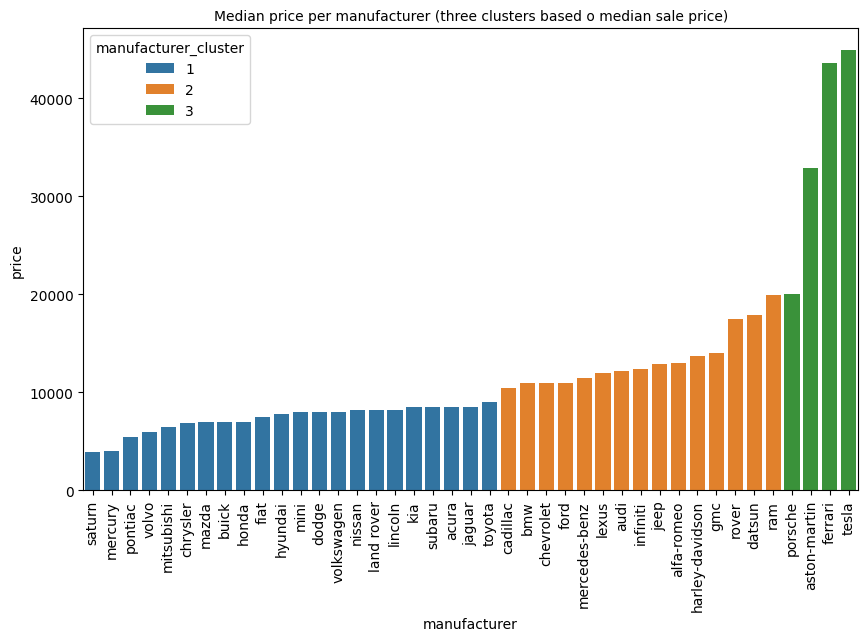

In [57]:
#plot the median price per manufacturer (hued by cluster)
#creating a temp dataframe:
temp = data_und.groupby(['manufacturer','manufacturer_cluster']).median('price').sort_values(by = 'price').reset_index()[['manufacturer','price', 'manufacturer_cluster']]

#plotting:
plt.figure(figsize=(10,6))
plt.title('Median price per manufacturer (three clusters based o median sale price)', fontsize = 10)
sns.barplot(data = temp, x = 'manufacturer', y = 'price', hue = 'manufacturer_cluster')
plt.xticks(rotation = 90);

##### Further analysis of other features:

In [58]:
# reminding myself the features:
print(data_und.columns.values)

['region' 'price' 'year' 'manufacturer' 'model' 'condition' 'cylinders'
 'fuel' 'odometer' 'transmission' 'drive' 'type' 'paint_color' 'state'
 'segment' 'manufacturer_cluster']


Does the state feature play a role in the price of the car?

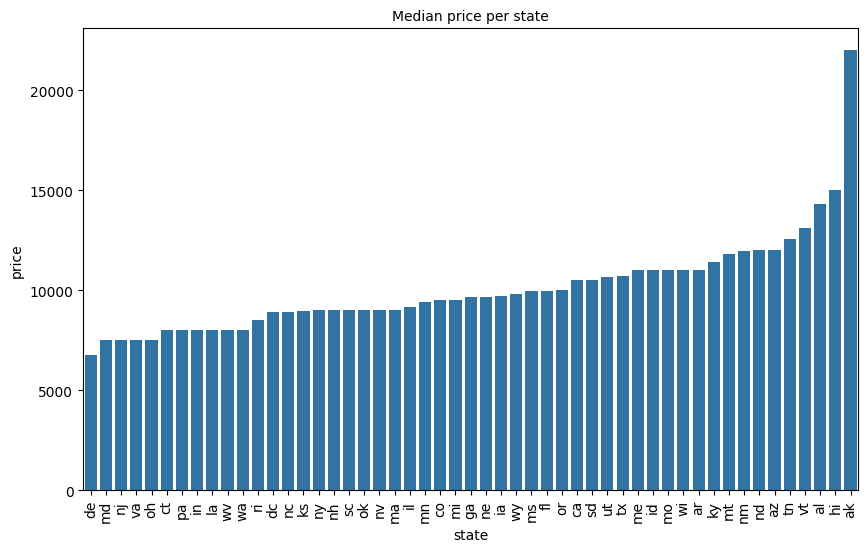

In [59]:
#plot the median price per manufacturer (hued by cluster)
#creating a temp dataframe:
temp = data_und.groupby(['state',]).median('price').sort_values(by = 'price').reset_index()[['state','price']]
#plotting:
plt.figure(figsize=(10,6))
plt.title('Median price per state', fontsize = 10)
sns.barplot(data = temp, x = 'state', y = 'price')
plt.xticks(rotation = 90);

<Figure size 3000x2000 with 0 Axes>

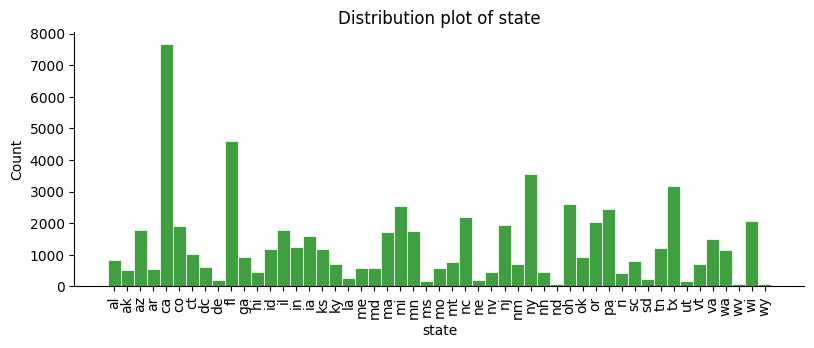

In [60]:
#histogram of state feature:
histogram_plotting(data_und, 'state', xlabels_rotation = 90, size1 = (30,20), size2 = [9, 3])

I decided not to include the state feature in my analysis as it does not provide significant value. Below I will analyse the features per segment (newer generation cars, old cars, antiques)

Below I create a boxplot plotting function to help me in the data analysis:

In [61]:
#creation of boxplot function:
def plot_bplots(feature, labelrotation = 90, palette = 'Pastel2'):
    """
    :param feature: feature/variaple to plot against the price
    :param labelrotation: xticks rotation
    :param palette: coloring palette:
    - Perceptually uniform palettes: 'flare', 'crest', ''mako
    - Qualitative palettes: 'Set3', 'Pastel1', 'Pastel2'
    - Sequential palettes: 'BuGn', 'YlGn', 'YlOrRd'
    :return: box plots of the 3 market segments
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8), sharey=True)
    fig.suptitle('Box-plot of '+feature+' feature per segment', fontsize = 15)

    sns.boxplot(ax = ax1, data = data_und.query('segment == "newer generation cars"').sort_values(by = 'price')
            ,x = feature, y = 'price', hue = feature, palette = palette)
    ax1.set_title('New generation cars')
    ax1.tick_params(labelrotation=labelrotation)
    sns.boxplot(ax = ax2, data = data_und.query('segment == "old cars"').sort_values(by = 'price')
                ,x = feature, y = 'price', hue = feature, palette = palette)
    ax2.set_title('Old cars')
    ax2.tick_params(labelrotation=labelrotation)
    sns.boxplot(ax = ax3, data = data_und.query('segment == "antiques"').sort_values(by = 'price')
                ,x = feature, y = 'price', hue = feature, palette = palette)
    ax3.set_title('Antiques') 
    ax3.tick_params(labelrotation=labelrotation);

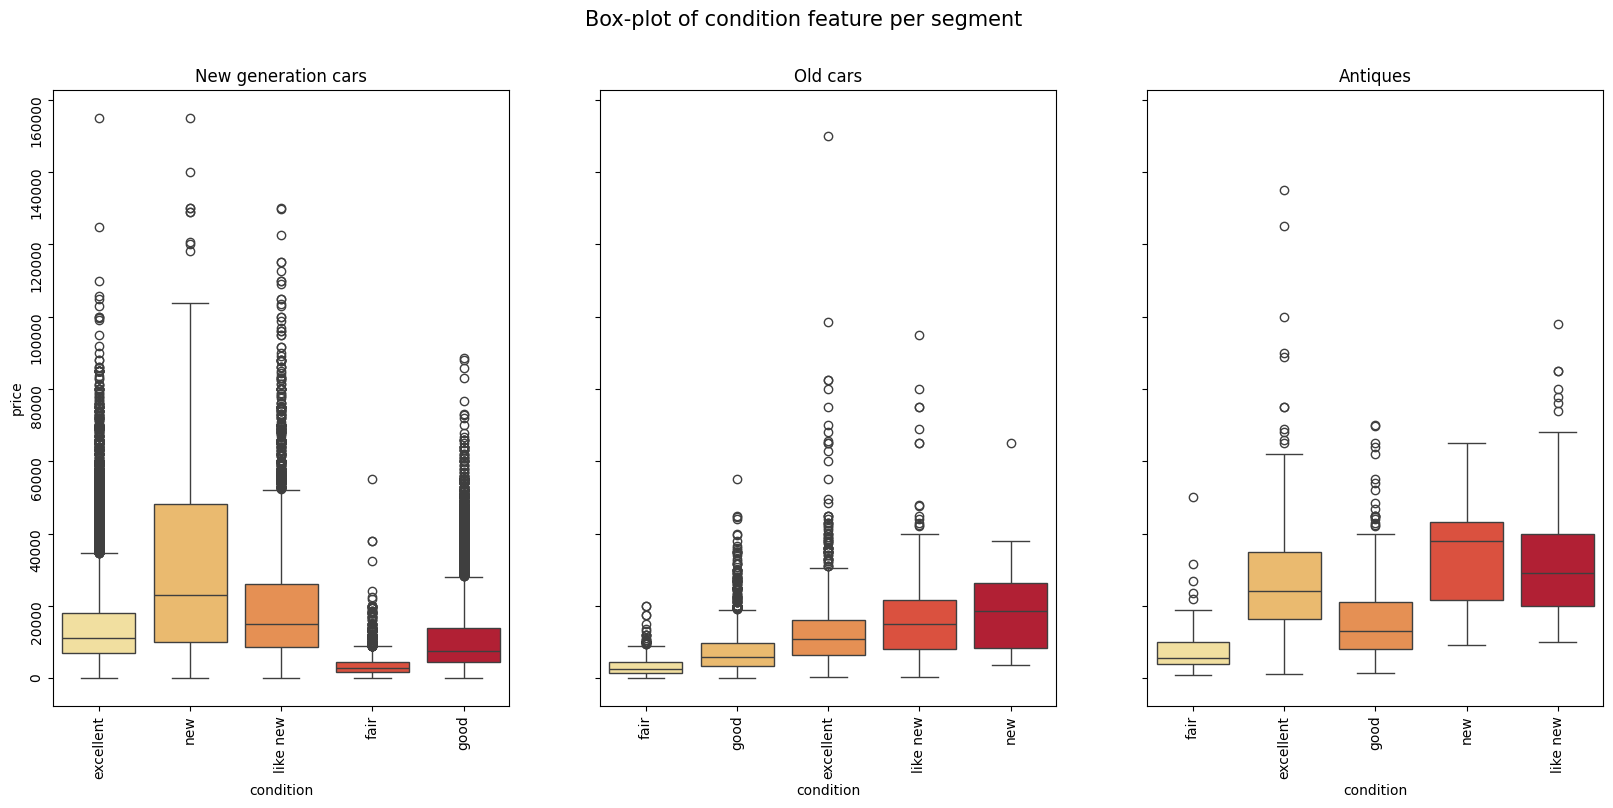

In [62]:
plot_bplots(feature = 'condition', palette='YlOrRd')

The **condition** seems to have a trend in **old cars and antiques**.

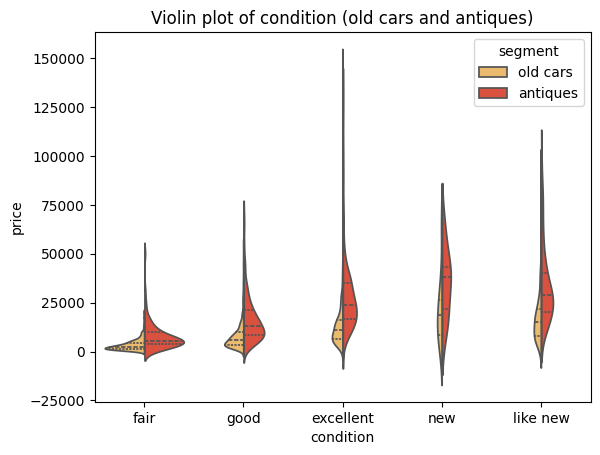

In [63]:
plt.title('Violin plot of condition (old cars and antiques)')
sns.violinplot(data=data_und.query('segment == "antiques" or segment == "old cars"'),
               x="condition", y="price", hue="segment", palette='YlOrRd',
               split=True, gap=.01, inner="quart");

In addition, the distributions for the two segments are similar.

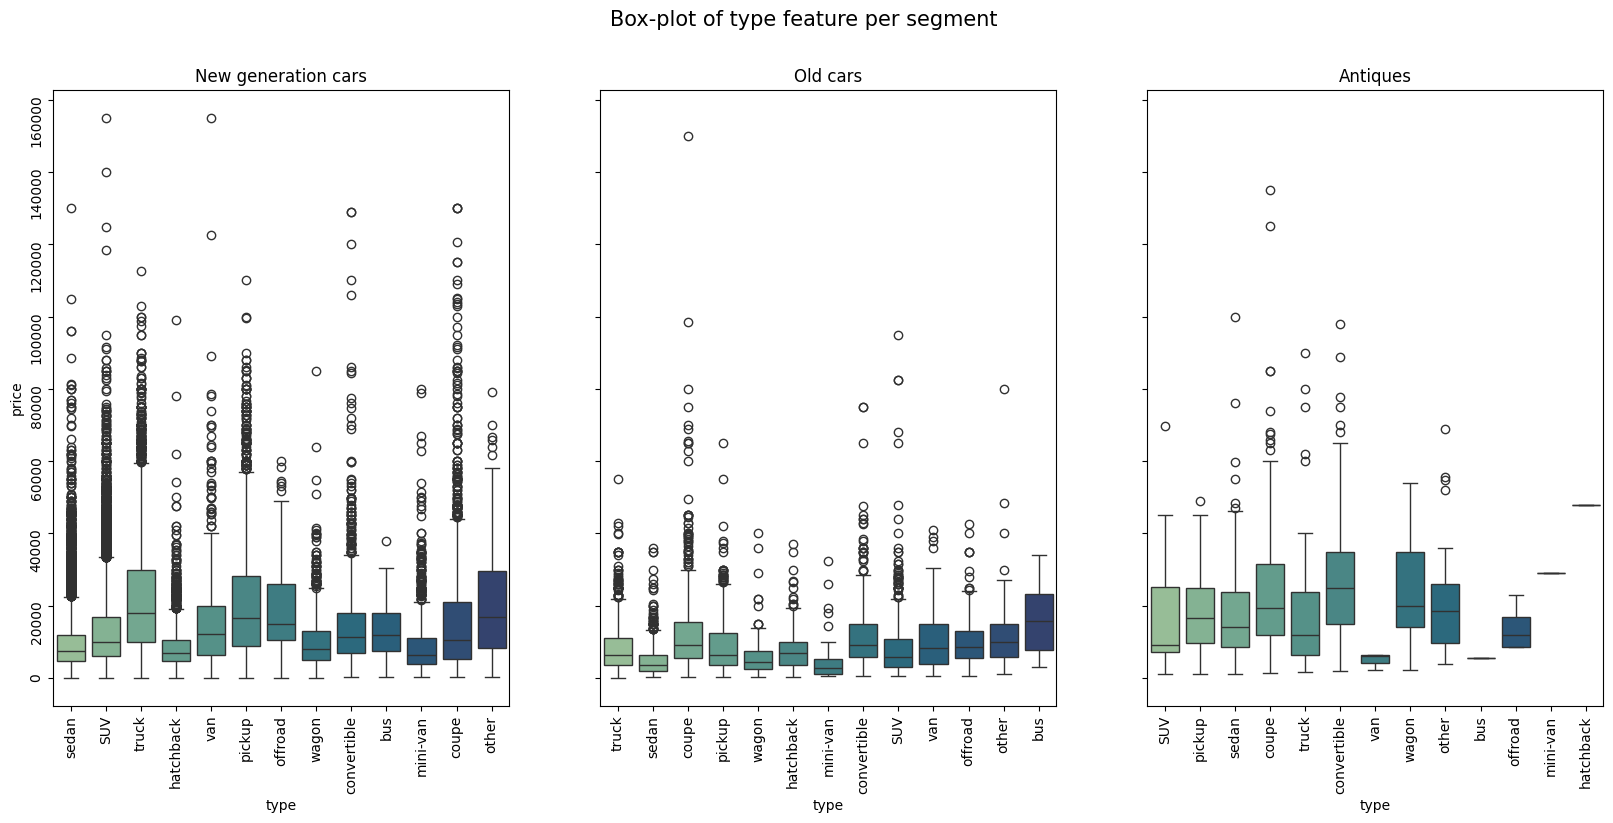

In [64]:
plot_bplots(feature = 'type', palette='crest')

<Figure size 3000x2000 with 0 Axes>

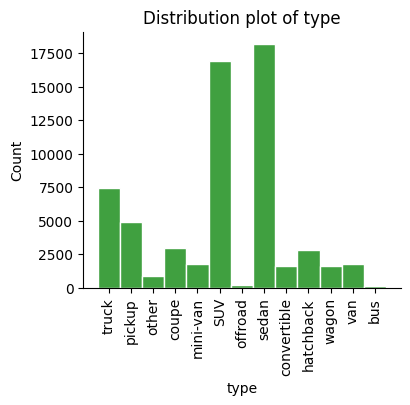

In [65]:
histogram_plotting(data_und.query('segment == "newer generation cars"'),
                   'type', xlabels_rotation = 90, size1 = (30,20), size2 = [4, 3])

<Figure size 3000x2000 with 0 Axes>

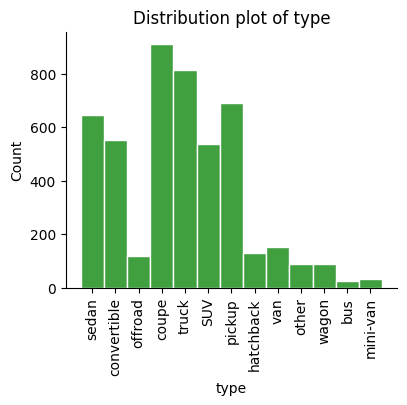

In [66]:
histogram_plotting(data_und.query('segment == "old cars"'),
                   'type', xlabels_rotation = 90, size1 = (30,20), size2 = [4, 3])

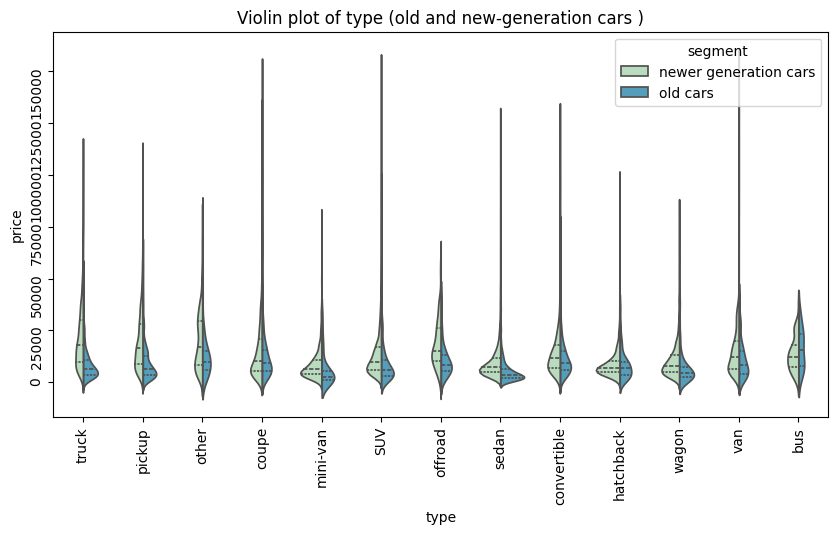

In [67]:
plt.figure(figsize=(10,5))
plt.title('Violin plot of type (old and new-generation cars )')
sns.violinplot(data=data_und.query('segment == "newer generation cars" or segment == "old cars"'),
               x="type", y="price", hue="segment", palette='GnBu',
               split=True, gap=.01, inner="quart",)
plt.tick_params(labelrotation=90);

According to the plots above, **type is not as significant as some other features**. However, I could experiment and use the **type** feature, **only for old and new generation cars** in the modelling phase.

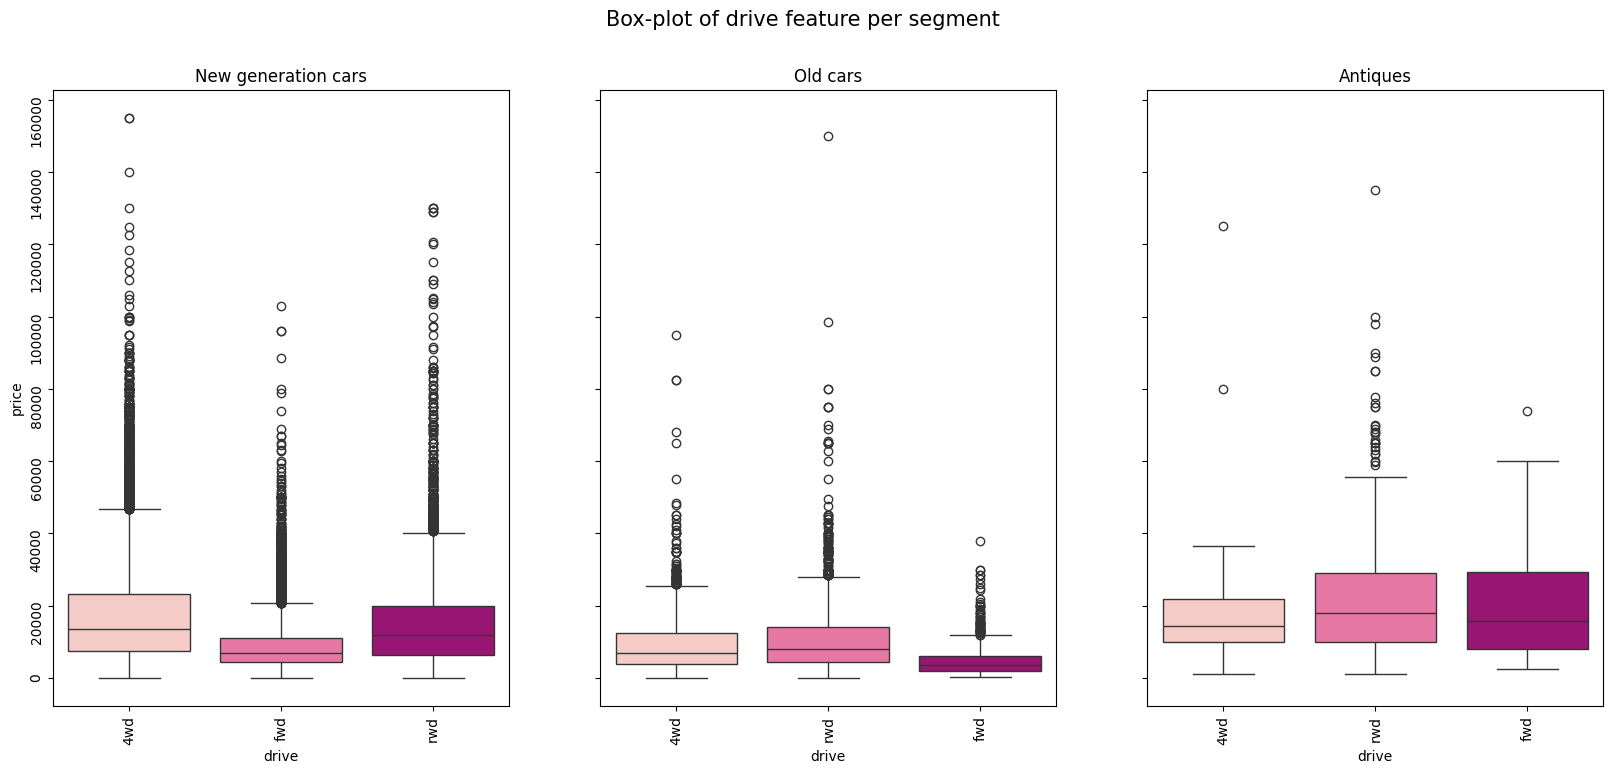

In [68]:
plot_bplots(feature = 'drive', palette='RdPu')

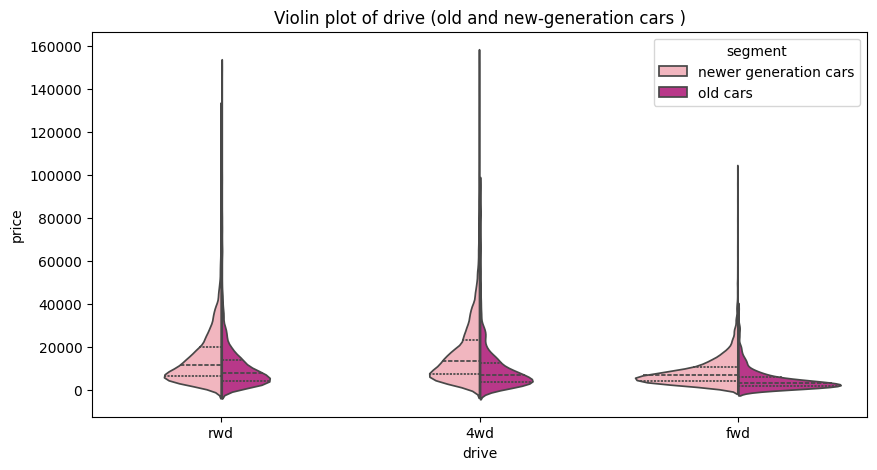

In [69]:
plt.figure(figsize=(10,5))
plt.title('Violin plot of drive (old and new-generation cars )')
sns.violinplot(data=data_und.query('segment == "newer generation cars" or segment == "old cars"'),
               x="drive", y="price", hue="segment", palette='RdPu',
               split=True, gap=.01, inner="quart",);
#plt.tick_params(labelrotation=90);

Using the **same logic as on the type** feature, I could keep the **drive** variable **only for old and new generation cars**.

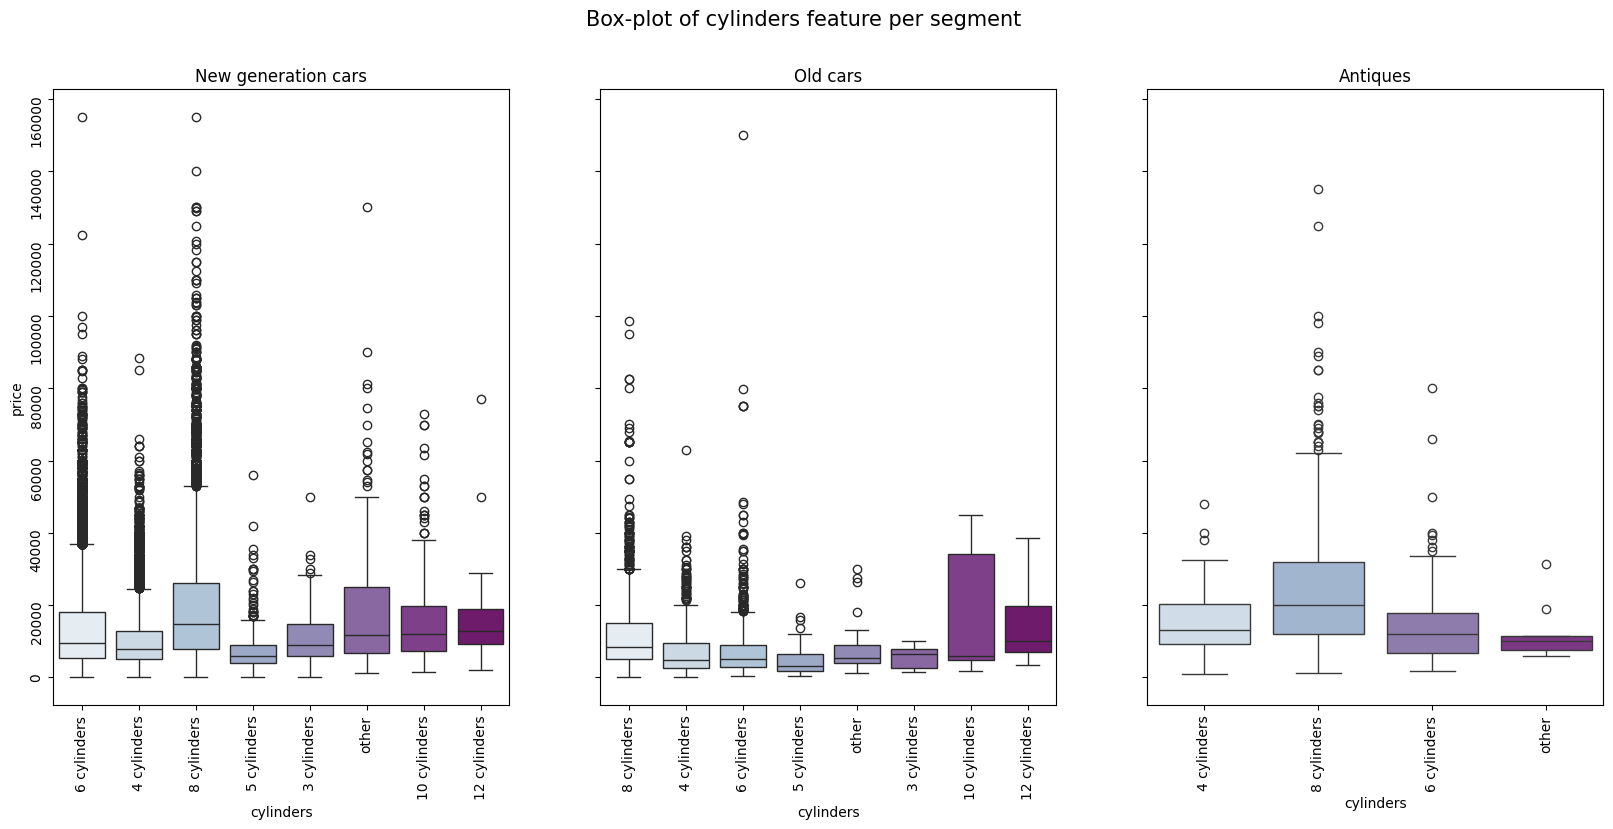

In [70]:
plot_bplots(feature = 'cylinders', palette='BuPu')

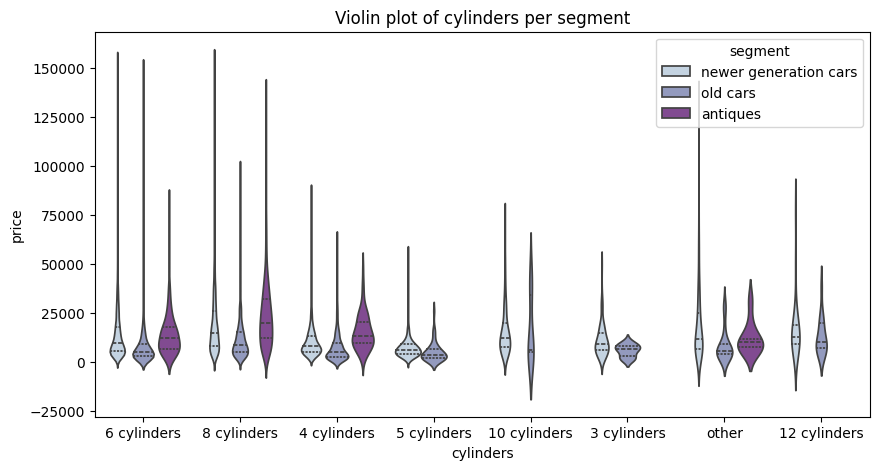

In [71]:
plt.figure(figsize=(10,5))
plt.title('Violin plot of cylinders per segment')
sns.violinplot(data=data_und,
               x="cylinders", y="price", hue="segment", palette='BuPu', gap=.01, inner="quart",);

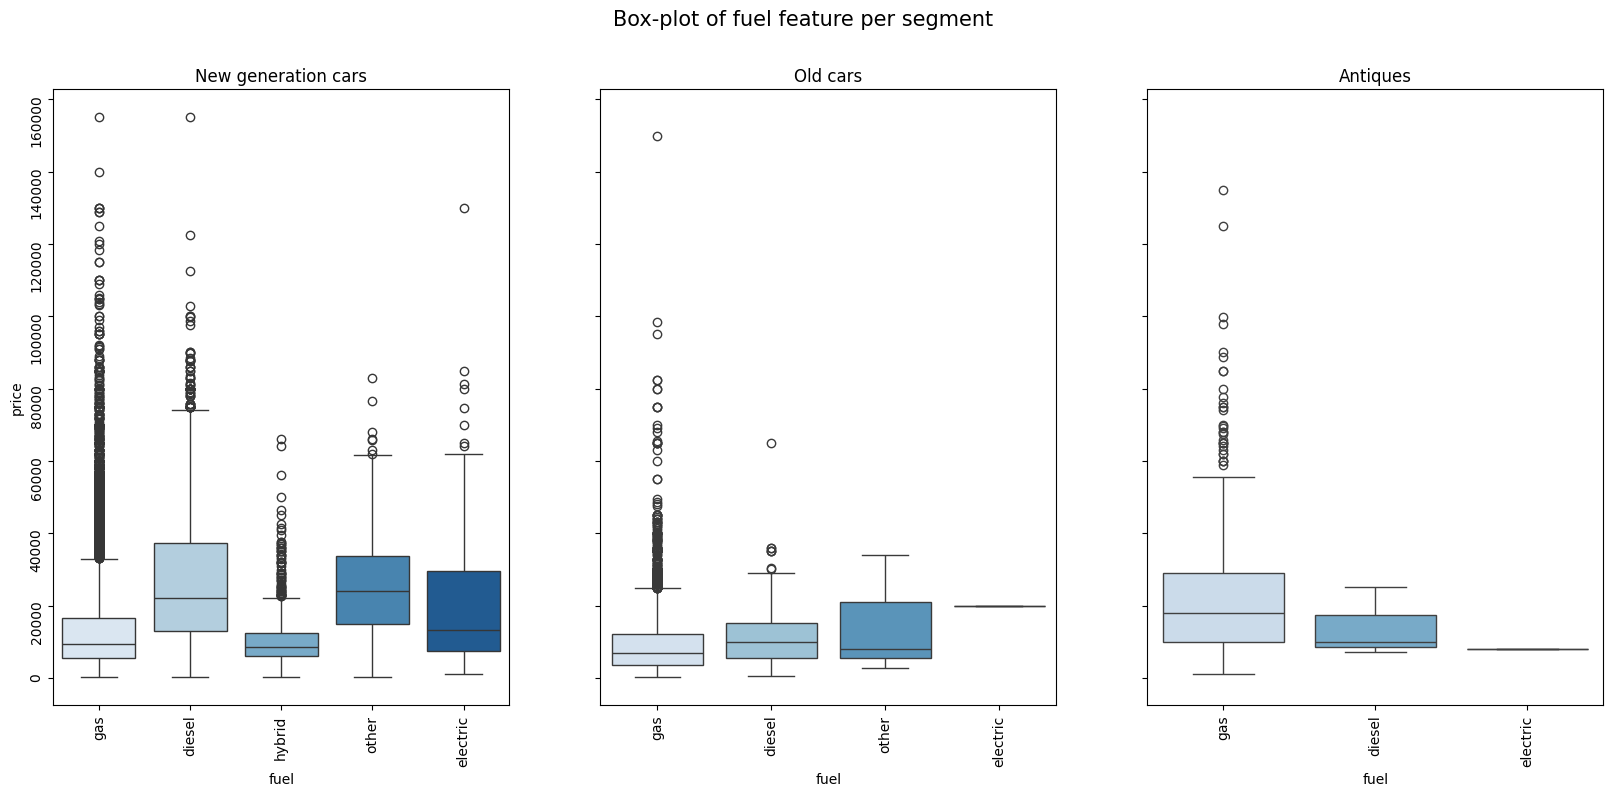

In [72]:
plot_bplots(feature = 'fuel', palette='Blues')

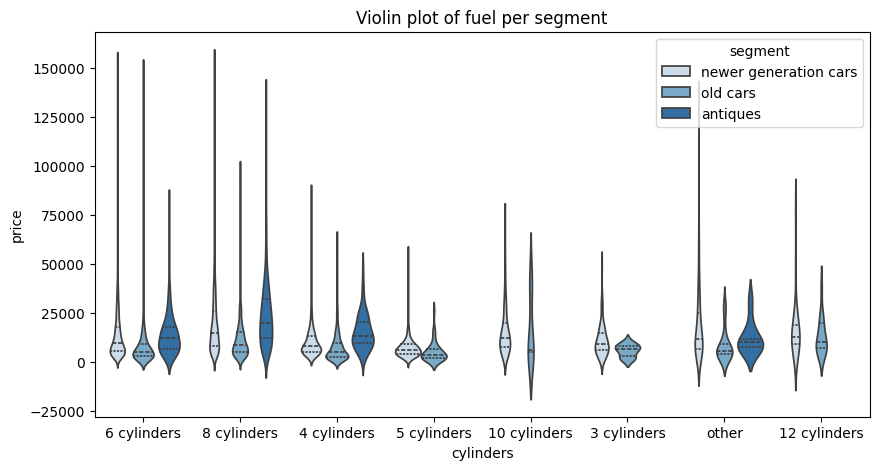

In [73]:
plt.figure(figsize=(10,5))
plt.title('Violin plot of fuel per segment')
sns.violinplot(data=data_und,
               x="cylinders", y="price", hue="segment", palette='Blues', gap=.01, inner="quart",);

I could experiment using the variables **fuel** and **cylinders** in my modelling phase. They do not seem so significant, though. It is worth mentioning that for the **antiques**, I will not use the **fuel** variable.

### Conclusion - Data Understanding and initial Data Cleansing

##### From the above analysis I concluded the following points:
- I removed the target variable's outliers, duplicates, nulls and non-significant features such as VIN. 
- Although I did not drop the region, state, model and paint_color variables, they will not be used in the data preparation and modelling phase.
- I kept the data between the years 1908 and 2021.
- The dataset was split into three segments with different behaviours for the price trend per year. The **first** is the **newer generation cars** (year >= 1998), where the newer cars have higher prices. The **second** is the **old cars** (year >= 1969 and year < 1998), where the newer cars have lower prices. The **third** is the **antiques** (year < 1969), where price vs year has no distinctive trend.
- The **odometer** variable is **correlated / anti-correlated** with the variable **year**. 
- For **old and new-generation cars**, I should **only keep either the year or the odometer** in my modelling phase. In this way, I will mitigate the risk of multicollinearity.
- For antiques, I should **only use the odometer**.
- I should **log-transform** the **target variable (price)**.
- The variable/ feature **manufacturer_cluster** was created based on the median price per manufacturer. Three clusters/levels were created and possibly will be used to reduce modelling complexity. On the other hand, I should consider **involving** the initial **manufacturer** variable as it may be **more valuable**.
- I will keep the **condition** variable **only for old cars and antiques**.
- I will keep the **type** variable **only for old and new generation cars**.
- I will keep the **drive** variable **only for old and new generation cars**.
- **Fuel** and **cylinders** will be used experimentally in the modelling phase. I **will not include fuel** in the **antiques**' modelling.

In [74]:
print('The shape of the imported dataset was: '+str(initial_data_shape))
print('The shape of the dataset now is: '+str(data_und.shape))

The shape of the imported dataset was: (426880, 18)
The shape of the dataset now is: (66969, 16)


**I should proceed with the following dataset:**

In [75]:
data_prep = data_und.copy(deep = True)
data_prep.shape

(66969, 16)

## 3 Data Preparation

After the initial exploration, data cleansing and fine-tuning of the business understanding, it is time to construct my final dataset prior to modeling.  Here, I want to make sure to handle any integrity issues and final cleaning, the engineering of new features, any transformations that I believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In the Data Understanding phase, I made an initial preprocessing of data. In this phase, I will create the **parts of the sklearn pipeline** that will log-transform the target variable, encode categorical variables and scale the numerical variables. In addition, I will likely apply PolynomialFeatures() to engineer new features.

**More specifically:**

**Encoding Categorical features**:
- One Hot Encoder: Encodes categorical features as a one-hot numeric array. This encoder derives the categories based on the unique values in each feature.

**Transforming numerical features**:
- Polynomial Features: Often it’s useful to add complexity to a model by considering nonlinear features of the input data. Using PolynomialFeatures() I can get features’ high-order and interaction terms.
- Standardization of features is a common requirement for many machine learning estimators implemented in scikit-learn. The StandardScaler() is a quick and easy way to perform standardization on a dataset's features (based on their distribution).

**Transforming target variable and applying a regression estimator**:
- TransformedTargetRegressor: Meta-estimator to regress on the transformed target variable. I will log-transform my target variable.

In [76]:
data_prep.head()

region  price  year manufacturer                        model  condition  \
31  auburn  15000  2013         ford                    f-150 xlt  excellent   
32  auburn  27990  2012          gmc  sierra 2500 hd extended cab       good   
33  auburn  34590  2016    chevrolet        silverado 1500 double       good   
34  auburn  35000  2019       toyota                       tacoma  excellent   
35  auburn  29990  2016    chevrolet        colorado extended cab       good   

      cylinders fuel  odometer transmission drive    type paint_color state  \
31  6 cylinders  gas    128000    automatic   rwd   truck       black    al   
32  8 cylinders  gas     68696        other   4wd  pickup       black    al   
33  6 cylinders  gas     29499        other   4wd  pickup      silver    al   
34  6 cylinders  gas     43000    automatic   4wd   truck        grey    al   
35  6 cylinders  gas     17302        other   4wd  pickup         red    al   

                  segment manufacturer_cluster  
31  newer generation cars                    2  
32  newer generation cars                    2  
33  newer generation cars                    2  
34  newer generation cars                    1  
35  newer generation cars                    2

I will drop the region, model, paint_color and state variables to proceed further with the data preparation.

In [77]:
data_prep.drop(['region', 'model', 'paint_color', 'state'], axis = 'columns', inplace = True)
data_prep.shape

(66969, 12)

In the Data Preparation phase, I should decide how to transform my data to insert them into the predictive (regression) models.
I have two numeric variables that should be scaled. Furthermore, the other variables will be transformed using One Hot Encoding.
Lastly the target variable should be log-transformed. The transformations will be done on three different datasets according to the segment value.

In [78]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66969 entries, 31 to 426833
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   price                 66969 non-null  int64 
 1   year                  66969 non-null  int64 
 2   manufacturer          66969 non-null  object
 3   condition             66969 non-null  object
 4   cylinders             66969 non-null  object
 5   fuel                  66969 non-null  object
 6   odometer              66969 non-null  int64 
 7   transmission          66969 non-null  object
 8   drive                 66969 non-null  object
 9   type                  66969 non-null  object
 10  segment               66969 non-null  object
 11  manufacturer_cluster  66969 non-null  object
dtypes: int64(3), object(9)
memory usage: 8.7+ MB


I could experiment using the variables **fuel** and **cylinders** in my modelling phase. They do not seem so significant, though. It is worth mentioning that for the **antiques**, I will not use the **fuel** variable.

Creating the dataset of new-generation cars:

In [79]:
data_n = data_prep.query('segment == "newer generation cars"')[['year','odometer','manufacturer', 'manufacturer_cluster', 'drive', 'type','fuel','cylinders','price']].reset_index().drop(['index'], axis = 1)

data_n.shape

(61242, 9)

Creating the dataset of old cars:

In [80]:
data_o = data_prep.query('segment == "old cars"')[['year','odometer','manufacturer', 'manufacturer_cluster', 'condition', 'drive', 'type','fuel','cylinders','price']].reset_index().drop(['index'], axis = 1)

data_o.shape

(4781, 10)

Creating the dataset of antiques:

In [81]:
data_a = data_prep.query('segment == "antiques"')[['odometer', 'manufacturer', 'manufacturer_cluster', 'condition','cylinders','price']].reset_index().drop(['index'], axis = 1)

data_a.shape

(946, 6)

Function creation for ColumnTransformer:

In [82]:
def create_transformer(oh_features, numerical_features = ['year','odometer'],remainder = 'passthrough', poly = False, poly_degree = 2):
    """
    :param oh_features: list of features to pass through OH Encoder
    :param remainder: 'passthrough' or 'drop'
    :param poly: whether I want to include Polynomial features into my pipeline, can be True or False
    :return: column transformer
    Year and Odometer pass always through StandardScaler()
    """
    if poly == False:
        tr = ColumnTransformer([
            ('OH',OneHotEncoder(drop='if_binary',sparse_output=False),oh_features),
            ('SDS', StandardScaler(),numerical_features),
        ], remainder = remainder)
    else:
        tf_num = Pipeline([
            ('polyf', PolynomialFeatures(degree=poly_degree, include_bias = False)),
            ('scale', StandardScaler())
        ])

        tr = ColumnTransformer([
            ('OH',OneHotEncoder(drop='if_binary',sparse_output=False),oh_features),
            ('Poly', tf_num, numerical_features),
        ], remainder = remainder)

    return tr

**Below I choose only the feature manufacturer_cluster. If during the evaluation phase the results are poor, then I will use the feature manufacturer. Also, I choose only the year (and not the odometer) for new-generation cars and old cars. What is more, I choose the odometer variable (and not the year) for antiques.**

In [83]:
data_n.select_dtypes(include=['object']).columns.values.tolist()[1:]

['manufacturer_cluster', 'drive', 'type', 'fuel', 'cylinders']

In [84]:
# transformer for new-generation cars dataset:
tr_n = create_transformer(oh_features=data_n.select_dtypes(include=['object']).columns.values.tolist()[1:]
                          ,numerical_features=['year']
                          ,remainder = 'drop')
tr_n

ColumnTransformer(transformers=[('OH',
                                 OneHotEncoder(drop='if_binary',
                                               sparse_output=False),
                                 ['manufacturer_cluster', 'drive', 'type',
                                  'fuel', 'cylinders']),
                                ('SDS', StandardScaler(), ['year'])])

Transforming the dataset of new-generation cars:

In [85]:
# data_n is passing through transformer tr_n. Then a dataframe is created to demonstrate the transformations:
data_tr_n = pd.DataFrame(tr_n.fit_transform(data_n), columns= tr_n.get_feature_names_out())
print(data_tr_n.shape)
data_tr_n.head(3)

(61242, 33)


OH__manufacturer_cluster_1  OH__manufacturer_cluster_2  \
0                         0.0                         1.0   
1                         0.0                         1.0   
2                         0.0                         1.0   

   OH__manufacturer_cluster_3  OH__drive_4wd  OH__drive_fwd  OH__drive_rwd  \
0                         0.0            0.0            0.0            1.0   
1                         0.0            1.0            0.0            0.0   
2                         0.0            1.0            0.0            0.0   

   OH__type_SUV  OH__type_bus  OH__type_convertible  OH__type_coupe  ...  \
0           0.0           0.0                   0.0             0.0  ...   
1           0.0           0.0                   0.0             0.0  ...   
2           0.0           0.0                   0.0             0.0  ...   

   OH__fuel_other  OH__cylinders_10 cylinders  OH__cylinders_12 cylinders  \
0             0.0                         0.0                         0.0   
1             0.0                         0.0                         0.0   
2             0.0                         0.0                         0.0   

   OH__cylinders_3 cylinders  OH__cylinders_4 cylinders  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   

   OH__cylinders_5 cylinders  OH__cylinders_6 cylinders  \
0                        0.0                        1.0   
1                        0.0                        0.0   
2                        0.0                        1.0   

   OH__cylinders_8 cylinders  OH__cylinders_other  SDS__year  
0                        0.0                  0.0   0.525519  
1                        1.0                  0.0   0.335930  
2                        0.0                  0.0   1.094285  

[3 rows x 33 columns]

Similarly, with the above logic, I will transform the other datasets:

In [86]:
# transformer for old-cars dataset
# data_o is passing through transformer tr_o. Then a dataframe is created to demonstrate the transformations:
tr_o = create_transformer(oh_features=data_o.select_dtypes(include=['object']).columns.values.tolist()[1:]
                          ,numerical_features=['year']
                          ,remainder = 'drop')
data_tr_o = pd.DataFrame(tr_o.fit_transform(data_o), columns= tr_o.get_feature_names_out())
print(data_tr_o.shape)
data_tr_o.head(3)

(4781, 37)


OH__manufacturer_cluster_1  OH__manufacturer_cluster_2  \
0                         0.0                         1.0   
1                         0.0                         1.0   
2                         0.0                         1.0   

   OH__manufacturer_cluster_3  OH__condition_excellent  OH__condition_fair  \
0                         0.0                      0.0                 1.0   
1                         0.0                      0.0                 0.0   
2                         0.0                      1.0                 0.0   

   OH__condition_good  OH__condition_like new  OH__condition_new  \
0                 0.0                     0.0                0.0   
1                 1.0                     0.0                0.0   
2                 0.0                     0.0                0.0   

   OH__drive_4wd  OH__drive_fwd  ...  OH__fuel_other  \
0            0.0            0.0  ...             0.0   
1            0.0            0.0  ...             0.0   
2            1.0            0.0  ...             0.0   

   OH__cylinders_10 cylinders  OH__cylinders_12 cylinders  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   

   OH__cylinders_3 cylinders  OH__cylinders_4 cylinders  \
0                        0.0                        0.0   
1                        0.0                        1.0   
2                        0.0                        0.0   

   OH__cylinders_5 cylinders  OH__cylinders_6 cylinders  \
0                        0.0                        1.0   
1                        0.0                        0.0   
2                        0.0                        0.0   

   OH__cylinders_8 cylinders  OH__cylinders_other  SDS__year  
0                        0.0                  0.0   0.840494  
1                        0.0                  0.0  -1.688848  
2                        1.0                  0.0   0.960939  

[3 rows x 37 columns]

In [87]:
# transformation for antiques dataset
# data_a is passing through transformer tr_a. Then a dataframe is created to demonstrate the transformations:
tr_a = create_transformer(oh_features=data_a.select_dtypes(include=['object']).columns.values.tolist()[1:]
                          ,numerical_features=['odometer']
                          ,remainder = 'drop')
data_tr_a = pd.DataFrame(tr_a.fit_transform(data_o), columns= tr_a.get_feature_names_out())
print(data_tr_a.shape)
data_tr_a.head(3)

(4781, 17)


OH__manufacturer_cluster_1  OH__manufacturer_cluster_2  \
0                         0.0                         1.0   
1                         0.0                         1.0   
2                         0.0                         1.0   

   OH__manufacturer_cluster_3  OH__condition_excellent  OH__condition_fair  \
0                         0.0                      0.0                 1.0   
1                         0.0                      0.0                 0.0   
2                         0.0                      1.0                 0.0   

   OH__condition_good  OH__condition_like new  OH__condition_new  \
0                 0.0                     0.0                0.0   
1                 1.0                     0.0                0.0   
2                 0.0                     0.0                0.0   

   OH__cylinders_10 cylinders  OH__cylinders_12 cylinders  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   

   OH__cylinders_3 cylinders  OH__cylinders_4 cylinders  \
0                        0.0                        0.0   
1                        0.0                        1.0   
2                        0.0                        0.0   

   OH__cylinders_5 cylinders  OH__cylinders_6 cylinders  \
0                        0.0                        1.0   
1                        0.0                        0.0   
2                        0.0                        0.0   

   OH__cylinders_8 cylinders  OH__cylinders_other  SDS__odometer  
0                        0.0                  0.0      -0.168945  
1                        0.0                  0.0      -1.581263  
2                        1.0                  0.0       1.603629

Now I should also check the transformer pipeline with PolynomialFeatures and StandardScaler():

In [88]:
#transformer with Polynomial Features enabled for new-generation cars dataset:
tr_n = create_transformer(oh_features=data_n.select_dtypes(include=['object']).columns.values.tolist()[1:]
                          ,numerical_features=['year']
                          ,remainder = 'drop', poly=True, poly_degree=4)
tr_n

ColumnTransformer(transformers=[('OH',
                                 OneHotEncoder(drop='if_binary',
                                               sparse_output=False),
                                 ['manufacturer_cluster', 'drive', 'type',
                                  'fuel', 'cylinders']),
                                ('Poly',
                                 Pipeline(steps=[('polyf',
                                                  PolynomialFeatures(degree=4,
                                                                     include_bias=False)),
                                                 ('scale', StandardScaler())]),
                                 ['year'])])

In [89]:
data_tr_n = pd.DataFrame(tr_n.fit_transform(data_n), columns= tr_n.get_feature_names_out()) #extracting the results to a dataframe
print(data_tr_n.shape)
data_tr_n.head(3)

(61242, 36)


OH__manufacturer_cluster_1  OH__manufacturer_cluster_2  \
0                         0.0                         1.0   
1                         0.0                         1.0   
2                         0.0                         1.0   

   OH__manufacturer_cluster_3  OH__drive_4wd  OH__drive_fwd  OH__drive_rwd  \
0                         0.0            0.0            0.0            1.0   
1                         0.0            1.0            0.0            0.0   
2                         0.0            1.0            0.0            0.0   

   OH__type_SUV  OH__type_bus  OH__type_convertible  OH__type_coupe  ...  \
0           0.0           0.0                   0.0             0.0  ...   
1           0.0           0.0                   0.0             0.0  ...   
2           0.0           0.0                   0.0             0.0  ...   

   OH__cylinders_3 cylinders  OH__cylinders_4 cylinders  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   

   OH__cylinders_5 cylinders  OH__cylinders_6 cylinders  \
0                        0.0                        1.0   
1                        0.0                        0.0   
2                        0.0                        1.0   

   OH__cylinders_8 cylinders  OH__cylinders_other  Poly__year  Poly__year^2  \
0                        0.0                  0.0    0.525519      0.524742   
1                        1.0                  0.0    0.335930      0.334877   
2                        0.0                  0.0    1.094285      1.094905   

   Poly__year^3  Poly__year^4  
0      0.523962      0.523178  
1      0.333820      0.332762  
2      1.095520      1.096131  

[3 rows x 36 columns]

**The transformer function works and the data are transformed accordingly.**
In addition, I will create TransformedTargetRegressors (Ridge, Lasso, ElasticNet) to transform my target variable. I will use them during the modelling phase:

In [90]:
trg_tr_ridge = TransformedTargetRegressor(regressor = Ridge(random_state=42), func=np.log10, inverse_func= exp10)
trg_tr_ridge

TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>,
                           regressor=Ridge(random_state=42))

In [91]:
trg_tr_lasso = TransformedTargetRegressor(regressor = Lasso(random_state=42), func=np.log10, inverse_func= exp10)
trg_tr_lasso

TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>,
                           regressor=Lasso(random_state=42))

In [92]:
trg_tr_elastic = TransformedTargetRegressor(regressor = ElasticNet(random_state=42) , func=np.log10, inverse_func= exp10)
trg_tr_elastic

TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>,
                           regressor=ElasticNet(random_state=42))

### Conclusion - Data Preparation

##### In the data preparation phase:
- I dropped the columns region, model, paint_color, state as I will not use them in my modelling phase.
- I created a column transformer function which I will use on the modelling phase.
- Also, I created three variations of TransformedTargetRegressors. All the variations log-transform my target variable (price)

## 4 Modeling

With my (almost?) final dataset in hand, it is now time to build some models.  Here, I should build a number of different regression models with the price as the target.  In building my models, I should explore different parameters, using GridSearchCV and be sure to cross-validate my findings.

**Models to be used and their main parameters**:
- Lasso Regressor: Linear Regression Model trained with L1 prior as regularizer.
    - Parameter alpha: Constant that multiplies the L1 term, controlling regularization strength. alpha must be a non-negative float.
- Ridge Regressor: This model solves a regression model where the loss function is the linear least squares function and regularization is given by the L2-norm.
    - Parameter alpha: Constant that multiplies the L2 term, controlling regularization strength. Alpha must be a non-negative float.

Finding **the best hyperparameters** of a model:
- I will apply GridSearchCV algorithm. GridSearchCV is an exhaustive search over specified parameter values for an estimator. GridSearchCV implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [93]:
print('Shape of new generation cars dataset: '+ str(data_n.shape) )
print('\nShape of old cars dataset: '+ str(data_o.shape) )
print('\nShape of antiques dataset: '+ str(data_a.shape) )

Shape of new generation cars dataset: (61242, 9)

Shape of old cars dataset: (4781, 10)

Shape of antiques dataset: (946, 6)


##### Below, I split the three datasets ( cross-validation techniques):
- I will apply holdout cross-validation to all datasets.
- An optional/ alternative approach for the antiques dataset will be to apply K-Fold cross-validation during the GridSearchCV ( antique are 946 observations).

Data splitting (holdout CV) for new-generation cars dataset:

In [94]:
# splitting to features and target variable
Xn, yn = data_n.drop('price', axis = 1) , data_n['price'] 

#shuffling data and splitting to train and test datasets 
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, random_state = 42, shuffle=True, test_size=0.1)

#keeping the indexes
Xn_train_ind, Xn_test_ind, yn_train_ind, yn_test_ind = Xn_train.index.values, Xn_test.index.values, yn_train.index.values, yn_test.index.values


Data splitting (holdout CV) for old cars dataset:

In [95]:
#same logic with the above:
Xo, yo = data_o.drop('price', axis = 1) , data_o['price']
Xo_train, Xo_test, yo_train, yo_test = train_test_split(Xo, yo, random_state = 42, shuffle=True, test_size=0.1)
Xo_train_ind, Xo_test_ind, yo_train_ind, yo_test_ind = Xo_train.index.values, Xo_test.index.values, yo_train.index.values, yo_test.index.values

Data splitting (holdout CV) for antiques dataset:

In [96]:
#same logic with the above:
Xa, ya = data_a.drop('price', axis = 1) , data_a['price']
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, random_state = 42, shuffle=True, test_size=0.1)
Xa_train_ind, Xa_test_ind, ya_train_ind, ya_test_ind = Xa_train.index.values, Xa_test.index.values, ya_train.index.values, ya_test.index.values

##### Initialising Pipelines with Lasso Regressor and applying GridSearchCV to choose the best hyperpamaters of the specified pipeline (estimator):

Lasso regressor for new-generation cars dataset:

In [97]:
# Choosing features for OH Encoding:
featuresOH = data_n.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['year']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly=False) #I am not using PolynomialFeatures()

# Lasso regressor pipeline:
lasso_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ls', trg_tr_lasso)
])
# Parameters to check in GridSearchCV:
param_grid1 = dict({
    'ls__regressor__alpha':np.linspace(1,100,100) 
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Lasso_n = GridSearchCV(estimator = lasso_pipl, #pipeline to use 
                               param_grid = param_grid1, #parameters to try in GridSearchCV
                               scoring= ('r2'), #scoring method = R-squared score
                               cv = [[Xn_train_ind, yn_test_ind]] #indexes of train and test data
                               ).fit(Xn, yn) #fitting the models provided by GridSearchCV on Xn (features), Yn (target variable) data
Lasso_n = Lasso_n.best_estimator_
Lasso_n

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'drive', 'type', 'fuel',
                                                   'cylinders']),
                                                 ('SDS', StandardScaler(),
                                                  ['year'])])),
                ('ls',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Lasso(random_state=42)))])

Lasso regressor for old cars dataset:

In [98]:
# Choosing features for OH Encoding:
featuresOH = data_o.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['year']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly=False) #I am not using PolynomialFeatures()

# Lasso regressor pipeline:
lasso_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ls', trg_tr_lasso)
])
# Parameters to check in GridSearchCV:
param_grid1 = dict({
    'ls__regressor__alpha':np.linspace(1,100,100)
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Lasso_o = GridSearchCV(estimator = lasso_pipl,
                       param_grid = param_grid1,
                       scoring= ('r2'),
                       cv = [[Xo_train_ind, yo_test_ind]]
                       ).fit(Xo, yo)
Lasso_o = Lasso_o.best_estimator_
Lasso_o

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'condition', 'drive', 'type',
                                                   'fuel', 'cylinders']),
                                                 ('SDS', StandardScaler(),
                                                  ['year'])])),
                ('ls',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Lasso(random_state=42)))])

Lasso regressor for antiques dataset:

In [99]:
# Choosing features for OH Encoding:
featuresOH = data_a.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['odometer'] # i use only odometer for antiques
                                  ,remainder = 'drop', # I drop the not used features
                                  poly=False) #I am not using PolynomialFeatures()

# Lasso regressor pipeline:
lasso_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ls', trg_tr_lasso)
])
# Parameters to check in GridSearchCV:
param_grid1 = dict({
    'ls__regressor__alpha':np.linspace(1,100,100)
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Lasso_a = GridSearchCV(estimator = lasso_pipl,
                       param_grid = param_grid1,
                       scoring= ('r2'),
                       cv = [[Xa_train_ind, ya_test_ind]]
                       ).fit(Xa, ya)
Lasso_a = Lasso_a.best_estimator_
Lasso_a

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'condition', 'cylinders']),
                                                 ('SDS', StandardScaler(),
                                                  ['odometer'])])),
                ('ls',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Lasso(random_state=42)))])

##### Initialising Pipelines with PolynomialFeatures() and Lasso Regressor and applying GridSearchCV to choose the best hyperpamaters of the specified pipeline (estimator):

Lasso regressor for new-generation cars dataset (PolynomialFeatures() = True) :

In [100]:
# Choosing features for OH Encoding:
featuresOH = data_n.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['year']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly= True) #I am using PolynomialFeatures()

# Lasso regressor pipeline:
lasso_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ls', trg_tr_lasso)
])
# Parameters to check in GridSearchCV:
param_grid2 = dict({
    'ls__regressor__alpha':np.linspace(1,100,100),
    'preprocessor__Poly__polyf__degree':[2, 3, 4, 5]
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Lasso_poly_n = GridSearchCV(estimator = lasso_pipl,
                       param_grid = param_grid2,
                       scoring= ('r2'),
                       cv = [[Xn_train_ind, yn_test_ind]]
                       ).fit(Xn, yn)
Lasso_poly_n = Lasso_poly_n.best_estimator_
Lasso_poly_n

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'drive', 'type', 'fuel',
                                                   'cylinders']),
                                                 ('Poly',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year'])])),
                ('ls',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Lasso(random_state=42)))])

Lasso regressor for old cars dataset (PolynomialFeatures() = True) :

In [101]:
# Choosing features for OH Encoding:
featuresOH = data_o.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['year']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly= True) #I am using PolynomialFeatures()

# Lasso regressor pipeline:
lasso_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ls', trg_tr_lasso)
])

# Parameters to check in GridSearchCV:
param_grid2 = dict({
    'ls__regressor__alpha':np.linspace(1,100,100),
    'preprocessor__Poly__polyf__degree':[2, 3, 4, 5] # degrees of polynomial features
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Lasso_poly_o = GridSearchCV(estimator = lasso_pipl,
                       param_grid = param_grid2,
                       scoring= ('r2'),
                       cv = [[Xo_train_ind, yo_test_ind]]
                       ).fit(Xo, yo)
Lasso_poly_o = Lasso_poly_o.best_estimator_
Lasso_poly_o

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'condition', 'drive', 'type',
                                                   'fuel', 'cylinders']),
                                                 ('Poly',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year'])])),
                ('ls',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Lasso(random_state=42)))])

Lasso regressor for antiques dataset (PolynomialFeatures() = True) :

In [102]:
# Choosing features for OH Encoding:
featuresOH = data_a.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['odometer'] # I use only odometer for antiques
                                  ,remainder = 'drop', # I drop the not used features
                                  poly=True) #I am using PolynomialFeatures()
# Lasso regressor pipeline:
lasso_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ls', trg_tr_lasso)
])

# Lasso regressor pipeline:
# Parameters to check in GridSearchCV:
param_grid2 = dict({
    'ls__regressor__alpha':np.linspace(1,100,100),
    'preprocessor__Poly__polyf__degree':[2, 3, 4, 5] # degrees of polynomial features
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Lasso_poly_a = GridSearchCV(estimator = lasso_pipl,
                       param_grid = param_grid2,
                       scoring= ('r2'),
                       cv = [[Xa_train_ind, ya_test_ind]]
                       ).fit(Xa, ya)
Lasso_poly_a = Lasso_poly_a.best_estimator_
Lasso_poly_a

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'condition', 'cylinders']),
                                                 ('Poly',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['odometer'])])),
                ('ls',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Lasso(random_state=42)))])

##### Initialising Pipelines with Ridge Regressor and applying GridSearchCV to choose the best hyperpamaters of the specified pipeline (estimator):

Ridge regressor for new-generation cars dataset:

In [103]:
# Choosing features for OH Encoding:
featuresOH = data_n.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['year']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly=False) #I am not using PolynomialFeatures()

# Ridge regressor pipeline:
ridge_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ri', trg_tr_ridge)
])
# Parameters to check in GridSearchCV:
param_grid1 = dict({
    'ri__regressor__alpha':np.linspace(1,100,100)
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Ridge_n = GridSearchCV(estimator = ridge_pipl,
                       param_grid = param_grid1,
                       scoring= ('r2'),
                       cv = [[Xn_train_ind, yn_test_ind]]
                       ).fit(Xn, yn)
Ridge_n = Ridge_n.best_estimator_
Ridge_n

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'drive', 'type', 'fuel',
                                                   'cylinders']),
                                                 ('SDS', StandardScaler(),
                                                  ['year'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=23.0,
                                                            random_state=42)))])

Ridge regressor for old cars dataset:

In [104]:
# Choosing features for OH Encoding:
featuresOH = data_o.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['year']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly=False) #I am not using PolynomialFeatures()

# Ridge regressor pipeline:
ridge_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ri', trg_tr_ridge)
])
# Parameters to check in GridSearchCV:
param_grid1 = dict({
    'ri__regressor__alpha':np.linspace(1,100,100)
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Ridge_o = GridSearchCV(estimator = ridge_pipl,
                       param_grid = param_grid1,
                       scoring= ('r2'),
                       cv = [[Xo_train_ind, yo_test_ind]]
                       ).fit(Xo, yo)
Ridge_o = Ridge_o.best_estimator_
Ridge_o

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'condition', 'drive', 'type',
                                                   'fuel', 'cylinders']),
                                                 ('SDS', StandardScaler(),
                                                  ['year'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=4.0,
                                                            random_state=42)))])

Ridge regressor for antiques cars dataset:

In [105]:
# Choosing features for OH Encoding:
featuresOH = data_a.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['odometer']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly=False) #I am not using PolynomialFeatures()

# Ridge regressor pipeline:
ridge_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ri', trg_tr_ridge)
])
# Parameters to check in GridSearchCV:
param_grid1 = dict({
    'ri__regressor__alpha':np.linspace(1,100,100)
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Ridge_a = GridSearchCV(estimator = ridge_pipl,
                       param_grid = param_grid1,
                       scoring= ('r2'),
                       cv = [[Xa_train_ind, ya_test_ind]]
                       ).fit(Xa, ya)
Ridge_a = Ridge_a.best_estimator_
Ridge_a

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'condition', 'cylinders']),
                                                 ('SDS', StandardScaler(),
                                                  ['odometer'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=3.0,
                                                            random_state=42)))])

##### Initialising Pipelines with PolynomialFeatures() and Ridge Regressor and applying GridSearchCV to choose the best hyperpamaters of the specified pipeline (estimator):

Ridge regressor for new-generation cars dataset (PolynomialFeatures() = True) :

In [106]:
# Choosing features for OH Encoding:
featuresOH = data_n.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['year']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly= True) #I am using PolynomialFeatures()

# Ridge regressor pipeline:
ridge_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ri', trg_tr_ridge)
])
# Parameters to check in GridSearchCV:
param_grid2 = dict({
    'ri__regressor__alpha':np.linspace(1,100,100),
    'preprocessor__Poly__polyf__degree':[2, 3, 4, 5]
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Ridge_poly_n = GridSearchCV(estimator = ridge_pipl,
                            param_grid = param_grid2,
                            scoring= ('r2'),
                            cv = [[Xn_train_ind, yn_test_ind]]
                            ).fit(Xn, yn)
Ridge_poly_n = Ridge_poly_n.best_estimator_
Ridge_poly_n

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'drive', 'type', 'fuel',
                                                   'cylinders']),
                                                 ('Poly',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(random_state=42)))])

Ridge regressor for old cars dataset (PolynomialFeatures() = True) :

In [107]:
# Choosing features for OH Encoding:
featuresOH = data_o.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['year']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly= True) #I am using PolynomialFeatures()

# Ridge regressor pipeline:
ridge_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ri', trg_tr_ridge)
])
# Parameters to check in GridSearchCV:
param_grid2 = dict({
    'ri__regressor__alpha':np.linspace(1,100,100),
    'preprocessor__Poly__polyf__degree':[2, 3, 4, 5]
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Ridge_poly_o = GridSearchCV(estimator = ridge_pipl,
                            param_grid = param_grid2,
                            scoring= ('r2'),
                            cv = [[Xo_train_ind, yo_test_ind]]
                            ).fit(Xo, yo)
Ridge_poly_o = Ridge_poly_o.best_estimator_
Ridge_poly_o

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'condition', 'drive', 'type',
                                                   'fuel', 'cylinders']),
                                                 ('Poly',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(random_state=42)))])

Ridge regressor for antiques dataset (PolynomialFeatures() = True) :

In [108]:
# Choosing features for OH Encoding:
featuresOH = data_a.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['odometer']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly= True) #I am using PolynomialFeatures()

# Ridge regressor pipeline:
ridge_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ri', trg_tr_ridge)
])
# Parameters to check in GridSearchCV:
param_grid2 = dict({
    'ri__regressor__alpha':np.linspace(1,100,100),
    'preprocessor__Poly__polyf__degree':[2, 3, 4, 5]
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Ridge_poly_a = GridSearchCV(estimator = ridge_pipl,
                            param_grid = param_grid2,
                            scoring= ('r2'),
                            cv = [[Xa_train_ind, ya_test_ind]]
                            ).fit(Xa, ya)
Ridge_poly_a = Ridge_poly_a.best_estimator_
Ridge_poly_a

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'condition', 'cylinders']),
                                                 ('Poly',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(degree=4,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['odometer'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(random_state=42)))])

### Conclusion - Modelling

##### In the modelling phase:
- I applied Holdout Cross-Validation. (test size = 10% )
- I created Lasso and Ridge regression models by applying the Grid Search Algorithm. The scoring method that was used for choosing the best estimator was the R-squared score
- If the evaluation results of the models are poor, I will apply ElasticNet regression during the evaluation process.

## 5 Evaluation

With some modeling accomplished, I aim to reflect on what I identify as a high quality model and what I am able to learn from this.  I should review my business objective and explore how well I can provide meaningful insight on drivers of used car prices.  My goal now is to distill my findings and determine whether the earlier phases need revisitation and adjustment or if I have information of value to bring back to your client.

In the Evaluation phase, I will calculate the R-squared score, the MSE and the RMSE of the models I created above. More specifically:

- **R-squared** (coefficient of determination) is a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. In other words, r-squared shows how well the data fit the regression model (the goodness of fit)
- The mean squared error (**MSE**) of an estimator measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.
- The root-mean-square error (**RMSE**) is the quadratic mean of the differences between the observed values and predicted ones.

Later in the deployment phase, I will calculate the **Adjusted R-squared Score**. More specifically, adjusted R-squared is calculated by dividing the residual mean square error by the total mean square error (which is the sample variance of the target variable). The result is then subtracted from 1. Adjusted R-squared is always less than or equal to R-squared. Lastly, Adjusted R-squared might decrease if a specific effect does not improve the model.

In [109]:
#function for calculating the Adjusted R-squared score:
def adj_R2(X=Xn_test, y=yn_test, model = Ridge_poly_n):
    """
    :param X: X(predictors) train/test data to use
    :param y: y(target) train/test data to use
    :param model: regression model to use
    :return: Adjusted R-squared score
    """
    return 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

#check:
adj_R2()

0.7115878420542379

Calculating and inserting the scoring results into a dataframe:

In [110]:
def calculate_metrics(model = Lasso_poly_n, Xtrain_data = Xn_train, Xtest_data = Xn_test, ytrain = yn_train, ytest = yn_test):
    """
    Evaluation Metrics Calculation
    :param model: evaluated model
    :param Xtrain_data: inputs - train data
    :param Xtest_data: inputs - test data
    :param ytrain: target variable - train data
    :param ytest: target variable - test data
    :return: MSE, RMSE and Rsquared score for training and testing data
    """
    tr_pred = model.predict(Xtrain_data)
    ts_pred = model.predict(Xtest_data)

    MSE_train = mean_squared_error(ytrain, tr_pred)
    MSE_test = mean_squared_error(ytest, ts_pred)
    
    RMSE_train = mean_squared_error(ytrain, tr_pred, squared=False)
    RMSE_test = mean_squared_error(ytest, ts_pred, squared=False)

    Rsquared_train = r2_score(ytrain, tr_pred)
    Rsquared_test = r2_score(ytest, ts_pred)
    
    return MSE_train, MSE_test, RMSE_train, RMSE_test, Rsquared_train, Rsquared_test

# check:
calculate_metrics()    

(153965492.39348498,
 147982801.586374,
 12408.283217008104,
 12164.818189614427,
 -0.10381505885681297,
 -0.10889107107535367)

##### Models to be evaluated

New-generation cars group:
- Lasso_n
- Lasso_poly_n
- Ridge_n
- Ridge_poly_n

Old-cars group:
- Lasso_o
- Lasso_poly_o
- Ridge_o
- Ridge_poly_o

Antiques group:
- Lasso_a
- Lasso_poly_a
- Ridge_a
- Ridge_poly_a

In [111]:
# creating lists of models per segment/group:
N = [Lasso_n, Lasso_poly_n, Ridge_n, Ridge_poly_n] # models of new-generation cars group
N_names = ['Lasso_n', 'Lasso_poly_n', 'Ridge_n', 'Ridge_poly_n'] # names of the models for new-generation cars group
O = [Lasso_o, Lasso_poly_o, Ridge_o, Ridge_poly_o] # models of old cars group
O_names = ['Lasso_o', 'Lasso_poly_o', 'Ridge_o', 'Ridge_poly_o'] # names of the models for old cars group
A = [Lasso_a, Lasso_poly_a, Ridge_a, Ridge_poly_a] # models of antiques group
A_names = ['Lasso_a', 'Lasso_poly_a', 'Ridge_a', 'Ridge_poly_a'] # names of the models for antiques group

ALL= [Lasso_n, Lasso_poly_n, Ridge_n, Ridge_poly_n,
      Lasso_o, Lasso_poly_o, Ridge_o, Ridge_poly_o,
      Lasso_a, Lasso_poly_a, Ridge_a, Ridge_poly_a]

Creating a function that calculates the score metrics for any segment of the dataset:

In [112]:
def segments_metrics(segment = 'N'):
        """
        Function that calculates the score metrics per segment
        :param segment: N for new generation cars dataset, O for old cars dataset and A for antiques dataset
        :return: a dataframe with all score metrics
        """
        # choosing datasets and models according to segment:
        if segment == 'N':
            models = [Lasso_n, Lasso_poly_n, Ridge_n, Ridge_poly_n]
            models_names = ['Lasso_n', 'Lasso_poly_n', 'Ridge_n', 'Ridge_poly_n']
            Xtrain_data = Xn_train
            Xtest_data = Xn_test
            ytrain = yn_train
            ytest = yn_test
        elif segment == 'O':
            models = [Lasso_o, Lasso_poly_o, Ridge_o, Ridge_poly_o]
            models_names = ['Lasso_o', 'Lasso_poly_o', 'Ridge_o', 'Ridge_poly_o']
            Xtrain_data = Xo_train
            Xtest_data = Xo_test
            ytrain = yo_train
            ytest = yo_test
        elif segment == 'A':
            models = [Lasso_a, Lasso_poly_a, Ridge_a, Ridge_poly_a]
            models_names = ['Lasso_a', 'Lasso_poly_a', 'Ridge_a', 'Ridge_poly_a']
            Xtrain_data = Xa_train
            Xtest_data = Xa_test
            ytrain = ya_train
            ytest = ya_test
        else: return 'Please insert N, O or A'

        # create empty lists
        MSE_tr= []
        MSE_ts= []
        RMSE_tr= []
        RMSE_ts= []
        Rsquared_tr= []
        Rsquared_ts= []
        model = []
        
        # calculating score metrics:
        for model in models:
            MSE_train, MSE_test, RMSE_train, RMSE_test, Rsquared_train, Rsquared_test = calculate_metrics(model = model,
                                                                                                          Xtrain_data = Xtrain_data,
                                                                                                          Xtest_data = Xtest_data,
                                                                                                          ytrain = ytrain,
                                                                                                          ytest = ytest
                                                                                                          )
            MSE_tr.append(MSE_train), MSE_ts.append(MSE_test)
            RMSE_tr.append(RMSE_train), RMSE_ts.append(RMSE_test)
            Rsquared_tr.append(Rsquared_train), Rsquared_ts.append(Rsquared_test)
        
        
        
        metrics = {
            "model": models_names,
            "MSE_train": MSE_tr,
            "MSE_test": MSE_ts,
            "RMSE_train": RMSE_tr,
            "RMSE_test": RMSE_ts,
            "Rsquared_train": Rsquared_tr,
            "Rsquared_test": Rsquared_ts
        }
        
        return pd.DataFrame(metrics)

**Below, there is a demonstration of R-square scores of the created models.**

R-squared scores for new-generation cars group:

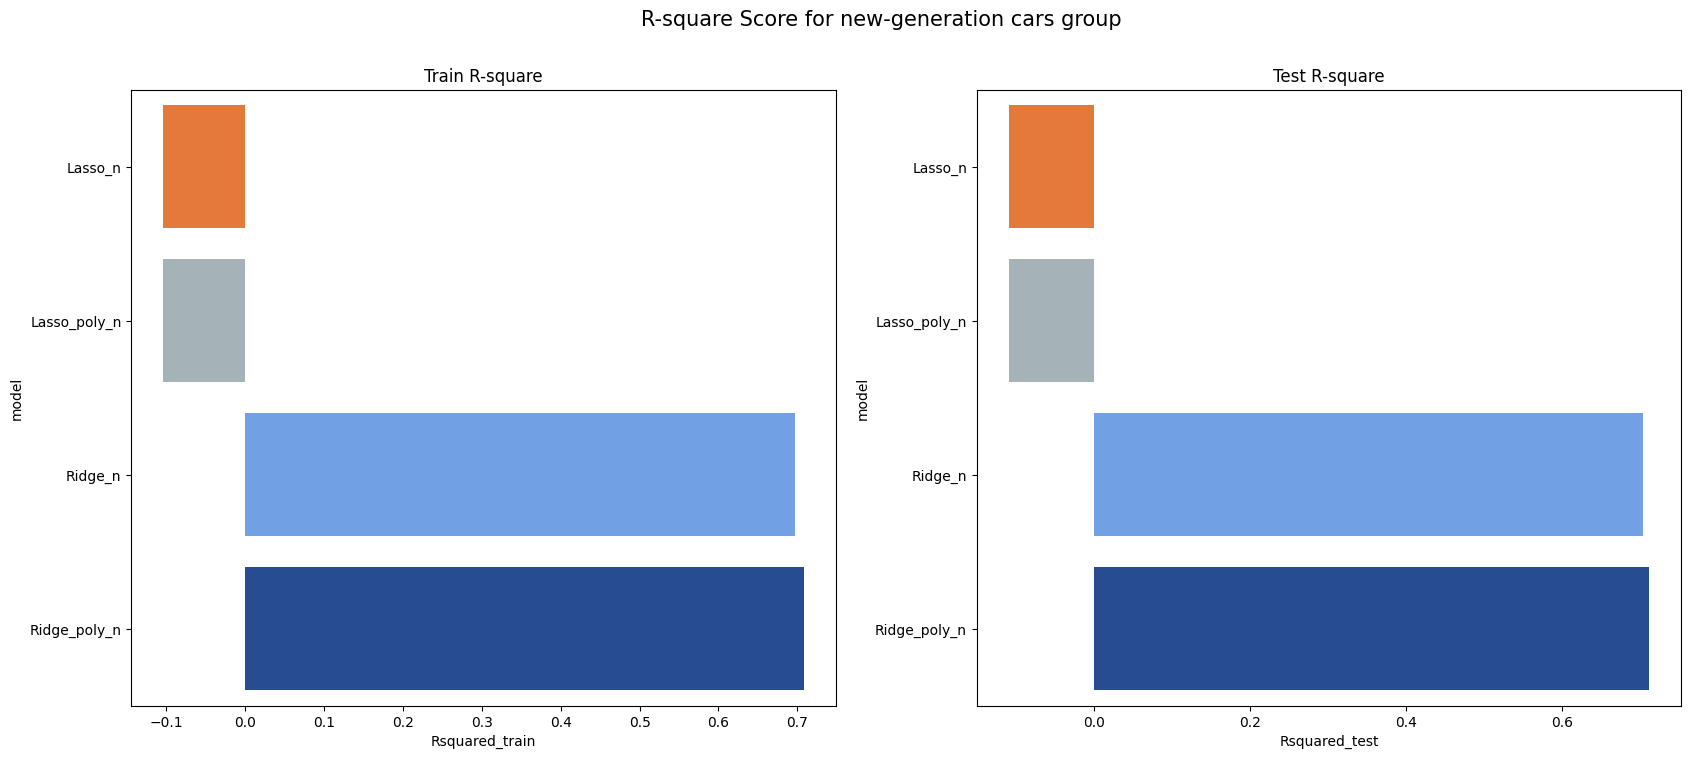

In [113]:
# plotting test and train R-squared scores for every model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8), sharey=False)
fig.suptitle('R-square Score for new-generation cars group', fontsize = 15)

sns.barplot(ax = ax1, data = segments_metrics(segment = 'N').sort_values(by = 'Rsquared_train'),
            y = 'model', x = 'Rsquared_train',
            hue='model', palette = ['#FF731D','#A2B5BB','#5F9DF7','#1746A2'])
ax1.set_title('Train R-square')
ax1.tick_params(labelrotation=360)

sns.barplot(ax = ax2, data = segments_metrics(segment = 'N').sort_values(by = 'Rsquared_test'),
            y = 'model', x = 'Rsquared_test',
            hue='model', palette = ['#FF731D','#A2B5BB','#5F9DF7','#1746A2'])
ax2.set_title('Test R-square')
ax2.tick_params(labelrotation=360)

**Ridge_poly_n** model is quite good according to R-squared score. So I keep this model for the new-cars group. Below, all the calculated metrics of the model are demonstrated:

In [114]:
segments_metrics(segment = 'N')

model     MSE_train      MSE_test    RMSE_train     RMSE_test  \
0       Lasso_n  1.539655e+08  1.479828e+08  12408.283217  12164.818190   
1  Lasso_poly_n  1.539655e+08  1.479828e+08  12408.283217  12164.818190   
2       Ridge_n  4.228817e+07  3.951170e+07   6502.935532   6285.833374   
3  Ridge_poly_n  4.071043e+07  3.843866e+07   6380.472230   6199.891776   

   Rsquared_train  Rsquared_test  
0       -0.103815      -0.108891  
1       -0.103815      -0.108891  
2        0.696826       0.703924  
3        0.708137       0.711965

**Ridge_poly_n** model score metrics:

In [115]:
segments_metrics(segment = 'N').query('model == "Ridge_poly_n"')

model     MSE_train      MSE_test  RMSE_train    RMSE_test  \
3  Ridge_poly_n  4.071043e+07  3.843866e+07  6380.47223  6199.891776   

   Rsquared_train  Rsquared_test  
3        0.708137       0.711965

Similarly to the above, I plot the R-squared scores for the other groups. Below the R-squared scores for old cars group:

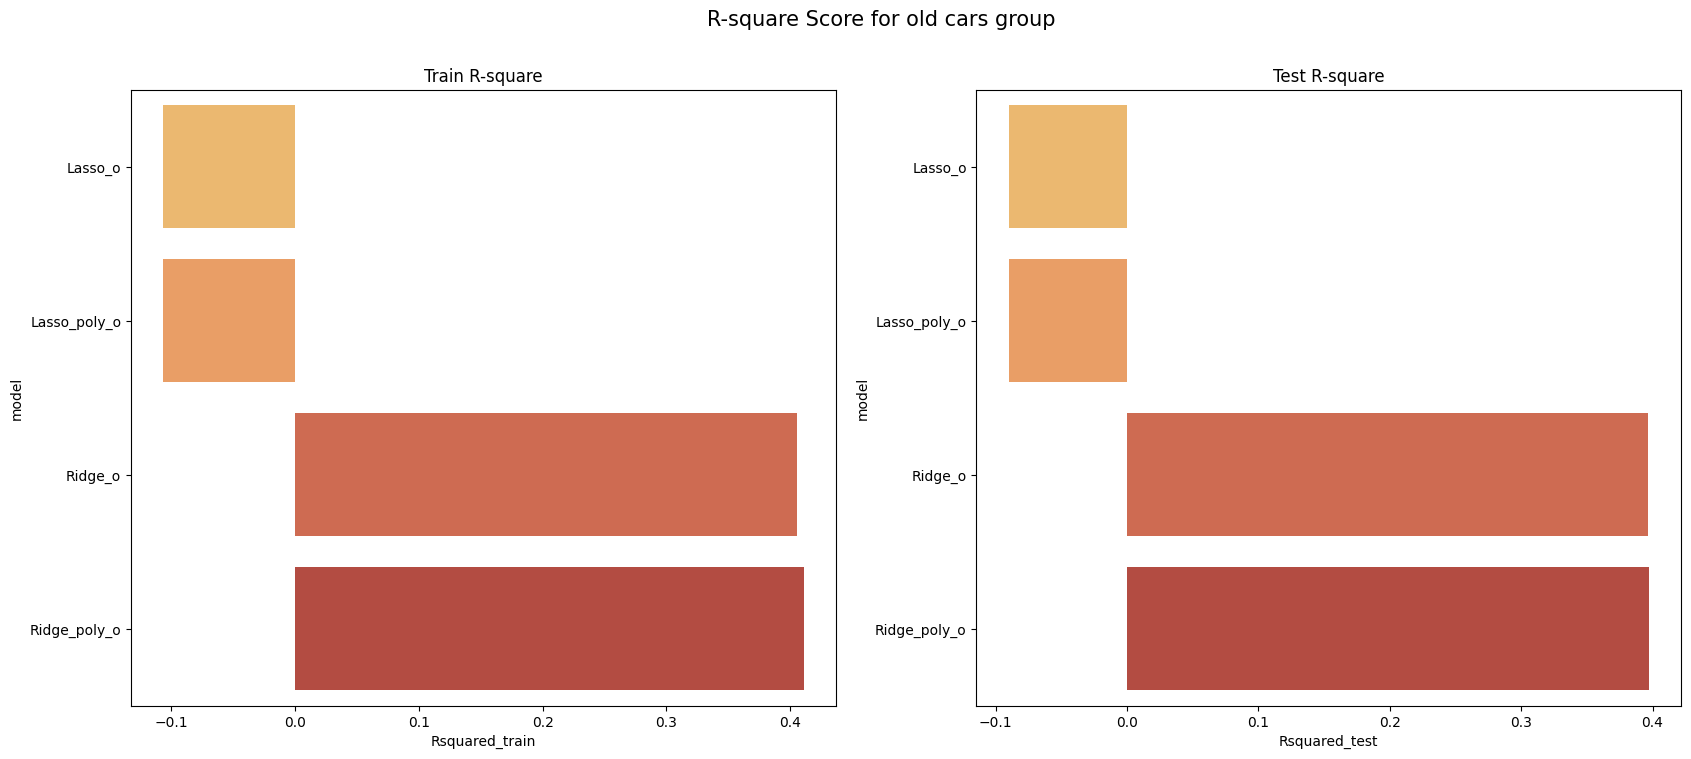

In [116]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8), sharey=False)
fig.suptitle('R-square Score for old cars group', fontsize = 15)

sns.barplot(ax = ax1, data = segments_metrics(segment = 'O').sort_values(by = 'Rsquared_train'),
            y = 'model', x = 'Rsquared_train',
            hue='model', palette = ['#FFBB5C','#FF9B50','#E25E3E','#C63D2F'])
ax1.set_title('Train R-square')
ax1.tick_params(labelrotation=360)

sns.barplot(ax = ax2, data = segments_metrics(segment = 'O').sort_values(by = 'Rsquared_test'),
            y = 'model', x = 'Rsquared_test',
            hue='model', palette = ['#FFBB5C','#FF9B50','#E25E3E','#C63D2F'])
ax2.set_title('Test R-square')
ax2.tick_params(labelrotation=360)

In [117]:
segments_metrics(segment = 'O') 

model     MSE_train      MSE_test   RMSE_train    RMSE_test  \
0       Lasso_o  9.180296e+07  8.163954e+07  9581.386143  9035.459925   
1  Lasso_poly_o  9.180296e+07  8.163954e+07  9581.386143  9035.459925   
2       Ridge_o  4.931763e+07  4.520258e+07  7022.650870  6723.286169   
3  Ridge_poly_o  4.888516e+07  4.512666e+07  6991.792460  6717.638096   

   Rsquared_train  Rsquared_test  
0       -0.106583      -0.090319  
1       -0.106583      -0.090319  
2        0.405531       0.396307  
3        0.410743       0.397321

And the R-squared scores for antiques group:

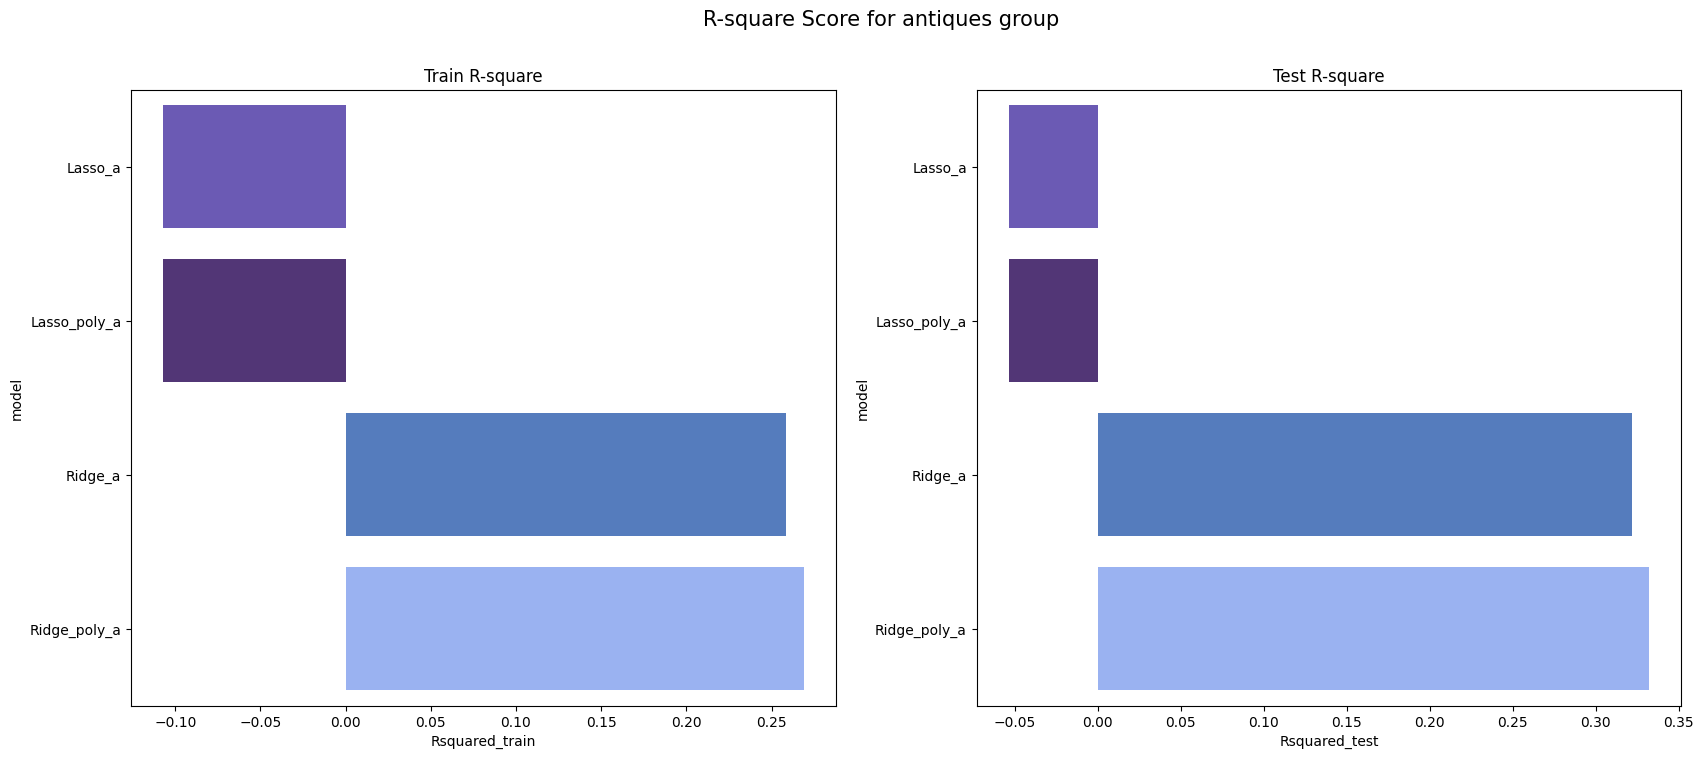

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8), sharey=False)
fig.suptitle('R-square Score for antiques group', fontsize = 15)

sns.barplot(ax = ax1, data = segments_metrics(segment = 'A').sort_values(by = 'Rsquared_train'),
            y = 'model', x = 'Rsquared_train',
            hue='model', palette = ['#614BC3','#512B81','#4477CE','#8CABFF'])
ax1.set_title('Train R-square')
ax1.tick_params(labelrotation=360)

sns.barplot(ax = ax2, data = segments_metrics(segment = 'A').sort_values(by = 'Rsquared_test'),
            y = 'model', x = 'Rsquared_test',
            hue='model', palette = ['#614BC3','#512B81','#4477CE','#8CABFF'])
ax2.set_title('Test R-square')
ax2.tick_params(labelrotation=360)

In [119]:
segments_metrics(segment = 'A')

model     MSE_train      MSE_test    RMSE_train     RMSE_test  \
0       Lasso_a  2.891382e+08  2.299265e+08  17004.063240  15163.327191   
1  Lasso_poly_a  2.891382e+08  2.299265e+08  17004.063240  15163.327191   
2       Ridge_a  1.935837e+08  1.479219e+08  13913.436259  12162.316210   
3  Ridge_poly_a  1.909498e+08  1.457082e+08  13818.459008  12070.966705   

   Rsquared_train  Rsquared_test  
0       -0.107100      -0.053757  
1       -0.107100      -0.053757  
2        0.258775       0.322071  
3        0.268860       0.332216

According to test and train R-squared scores of old-cars and antiques groups, **the results could be better**. I should change the possible combinations of hyperparameters in the same models or use Elastic Net with hyperparameters optimisation.
It is worth mentioning that ElasticNet is a linear regression with combined L1 and L2 priors as regularizer.

In [120]:
# Choosing features for OH Encoding:
featuresOH = data_o.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['year']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly= True) #I am using PolynomialFeatures()

# Ridge regressor pipeline:
ridge_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ri', trg_tr_ridge)
])
# Parameters to check in GridSearchCV:
param_grid2 = dict({
    'ri__regressor__alpha':np.linspace(1,1000,1000),
    'preprocessor__Poly__polyf__degree':[5, 6, 7, 8]
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Ridge_poly_o_v2 = GridSearchCV(estimator = ridge_pipl,
                            param_grid = param_grid2,
                            scoring= ('r2'),
                            cv = [[Xo_train_ind, yo_train_ind]]
                            ).fit(Xo, yo)
Ridge_poly_o_v2 = Ridge_poly_o_v2.best_estimator_
Ridge_poly_o_v2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'condition', 'drive', 'type',
                                                   'fuel', 'cylinders']),
                                                 ('Poly',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(degree=8,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(random_state=42)))])

In [121]:
# calculating RMSE, MSE and R2 metrics form 
MSE_train, MSE_test, RMSE_train, RMSE_test, Rsquared_train, Rsquared_test = calculate_metrics(model = Ridge_poly_o_v2,
                                                                                              Xtrain_data =  Xo_train,
                                                                                              Xtest_data = Xo_test,
                                                                                              ytrain = yo_train,
                                                                                              ytest = yo_test)
print("Train R-Square score of the new model: "+str(np.round(Rsquared_train, 5)))
print("Test R-Square score of the new model: "+str(np.round(Rsquared_test, 5)))

Train R-Square score of the new model: 0.41307
Test R-Square score of the new model: 0.39916


In [122]:
segments_metrics(segment = 'O').query('model == "Ridge_poly_o"')

model     MSE_train      MSE_test  RMSE_train    RMSE_test  \
3  Ridge_poly_o  4.888516e+07  4.512666e+07  6991.79246  6717.638096   

   Rsquared_train  Rsquared_test  
3        0.410743       0.397321

The score is slightly better. I will try again using Elastic Net algorithm:

In [123]:
# Choosing features for OH Encoding:
featuresOH = data_o.select_dtypes(include=['object']).columns.values.tolist()[1:]
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['year']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly= True) #I am using PolynomialFeatures()

# Ridge regressor pipeline:
elastic_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('elastic', trg_tr_elastic)
])
# Parameters to check in GridSearchCV: 
param_grid3 = dict({
    'elastic__regressor__alpha':np.linspace(1,1000,100), #100 alphas only to reduce computational effort
    'elastic__regressor__l1_ratio':np.linspace(0,10,1), #The ElasticNet mixing parameter, For l1_ratio = 1 it is an L1 penalty, For l1_ratio = 0 the penalty is an L2 penalty
    'preprocessor__Poly__polyf__degree':[5, 6, 7, 8]
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Elastic_poly_o = GridSearchCV(estimator = elastic_pipl,
                               param_grid = param_grid3,
                               scoring= ('r2'),
                               cv = [[Xo_train_ind, yo_train_ind]]
                               ).fit(Xo, yo)
Elastic_poly_o = Elastic_poly_o.best_estimator_
Elastic_poly_o

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer_cluster',
                                                   'condition', 'drive', 'type',
                                                   'fuel', 'cylinders']),
                                                 ('Poly',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(degree=8,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year'])])),
                ('elastic',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=ElasticNet(l1_ratio=0.0,
                                                                 random_state=42)))])

As noticed above, for l1_ratio = 0 the penalty is an L2 penalty.

In [124]:
MSE_train, MSE_test, RMSE_train, RMSE_test, Rsquared_train, Rsquared_test = calculate_metrics(model = Elastic_poly_o,
                                                                                              Xtrain_data =  Xo_train,
                                                                                              Xtest_data = Xo_test,
                                                                                              ytrain = yo_train,
                                                                                              ytest = yo_test)
print("Train R-Square score of the new model: "+str(np.round(Rsquared_train, 5)))
print("Test R-Square score of the new model: "+str(np.round(Rsquared_test, 5)))

Train R-Square score of the new model: 0.10768
Test R-Square score of the new model: 0.11788


I will **keep the Ridge Regression** and will **change the variable manufacturer_cluster to the manufacturer**.
In this way, I will introduce more knowledge to the models but also more complexity.

In [125]:
# Choosing features for OH Encoding:
featuresOH = ['manufacturer',
              'condition','drive','type','fuel','cylinders']
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['year']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly= True) #I am using PolynomialFeatures()

# Ridge regressor pipeline:
ridge_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ri', trg_tr_ridge)
])
# Parameters to check in GridSearchCV:
param_grid2 = dict({
    'ri__regressor__alpha':np.linspace(1,1000,1000),
    'preprocessor__Poly__polyf__degree':[2,3,4,5,6,7,8]
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Ridge_poly_o_v3 = GridSearchCV(estimator = ridge_pipl,
                               param_grid = param_grid2,
                               scoring= ('r2'),
                               cv = [[Xo_train_ind, yo_train_ind]]
                               ).fit(Xo, yo)
Ridge_poly_o_v3 = Ridge_poly_o_v3.best_estimator_
Ridge_poly_o_v3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer', 'condition',
                                                   'drive', 'type', 'fuel',
                                                   'cylinders']),
                                                 ('Poly',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(degree=8,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(random_state=42)))])

In [126]:

MSE_train, MSE_test, RMSE_train, RMSE_test, Rsquared_train, Rsquared_test = calculate_metrics(model = Ridge_poly_o_v3,
                                                                                              Xtrain_data =  Xo_train,
                                                                                              Xtest_data = Xo_test,
                                                                                              ytrain = yo_train,
                                                                                              ytest = yo_test)
print("Train R-Square score of the new model: "+str(np.round(Rsquared_train, 5)))
print("Test R-Square score of the new model: "+str(np.round(Rsquared_test, 5)))

print("Train MSE score of the new model: "+str(np.round(MSE_train, 5)))
print("Test MSE score of the new model: "+str(np.round(MSE_test, 5)))

print("Train RMSE score of the new model: "+str(np.round(RMSE_train, 5)))
print("Test RMSE score of the new model: "+str(np.round(RMSE_test, 5)))

Train R-Square score of the new model: 0.42748
Test R-Square score of the new model: 0.40465
Train MSE score of the new model: 47496355.78207
Test MSE score of the new model: 44578192.26302
Train RMSE score of the new model: 6891.75999
Test RMSE score of the new model: 6676.69022


In [127]:
segments_metrics(segment = 'O').query('model == "Ridge_poly_o"')

model     MSE_train      MSE_test  RMSE_train    RMSE_test  \
3  Ridge_poly_o  4.888516e+07  4.512666e+07  6991.79246  6717.638096   

   Rsquared_train  Rsquared_test  
3        0.410743       0.397321

This **new version of the model (Ridge_poly_o_v3) is better than the old**, but still not great according to R-square score. I will keep this version. Lastly, I will evaluate the third group's (antiques) models.

In [128]:
segments_metrics(segment = 'A')

model     MSE_train      MSE_test    RMSE_train     RMSE_test  \
0       Lasso_a  2.891382e+08  2.299265e+08  17004.063240  15163.327191   
1  Lasso_poly_a  2.891382e+08  2.299265e+08  17004.063240  15163.327191   
2       Ridge_a  1.935837e+08  1.479219e+08  13913.436259  12162.316210   
3  Ridge_poly_a  1.909498e+08  1.457082e+08  13818.459008  12070.966705   

   Rsquared_train  Rsquared_test  
0       -0.107100      -0.053757  
1       -0.107100      -0.053757  
2        0.258775       0.322071  
3        0.268860       0.332216

The RMSE of the best model is quite large. Also, the R-squared score is low (train:0.26, test:0.33). I should try to improve its performance by introducing the manufacturer feature as input to the model (and dropping the manufacturer_cluster)

In [129]:
# Choosing features for OH Encoding:
featuresOH = ['manufacturer', 'condition', 'cylinders']
# Initialise column transformer:
preprocessor = create_transformer(oh_features= featuresOH ,numerical_features= ['odometer']
                                  ,remainder = 'drop', # I drop the not used features
                                  poly= True) #I am using PolynomialFeatures()

# Ridge regressor pipeline:
ridge_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ri', trg_tr_ridge)
])
# Parameters to check in GridSearchCV:
param_grid2 = dict({
    'ri__regressor__alpha':np.linspace(1,1000,1000),
    'preprocessor__Poly__polyf__degree':[2,3,4,5,6,7,8]
})

# Initialise GridSearchCV - I will use the R-squared metric as a scoring method.
Ridge_poly_a_v2 = GridSearchCV(estimator = ridge_pipl,
                               param_grid = param_grid2,
                               scoring= ('r2'),
                               cv = [[Xa_train_ind, ya_train_ind]]
                               ).fit(Xa, ya)
Ridge_poly_a_v2 = Ridge_poly_a_v2.best_estimator_
Ridge_poly_a_v2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['manufacturer', 'condition',
                                                   'cylinders']),
                                                 ('Poly',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(degree=8,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['odometer'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(random_state=42)))])

In [130]:
MSE_train, MSE_test, RMSE_train, RMSE_test, Rsquared_train, Rsquared_test = calculate_metrics(model = Ridge_poly_a_v2,
                                                                                              Xtrain_data =  Xa_train,
                                                                                              Xtest_data = Xa_test,
                                                                                              ytrain = ya_train,
                                                                                              ytest = ya_test)
print("Train R-Square score of the new model: "+str(np.round(Rsquared_train, 5)))
print("Test R-Square score of the new model: "+str(np.round(Rsquared_test, 5)))

print("Train MSE score of the new model: "+str(np.round(MSE_train, 5)))
print("Test MSE score of the new model: "+str(np.round(MSE_test, 5)))

print("Train RMSE score of the new model: "+str(np.round(RMSE_train, 5)))
print("Test RMSE score of the new model: "+str(np.round(RMSE_test, 5)))

Train R-Square score of the new model: 0.3192
Test R-Square score of the new model: 0.35202
Train MSE score of the new model: 177802105.65113
Test MSE score of the new model: 141387746.03629
Train RMSE score of the new model: 13334.2456
Test RMSE score of the new model: 11890.65793


In [131]:
segments_metrics(segment = 'A').query('model == "Ridge_poly_a"')

model     MSE_train      MSE_test    RMSE_train     RMSE_test  \
3  Ridge_poly_a  1.909498e+08  1.457082e+08  13818.459008  12070.966705   

   Rsquared_train  Rsquared_test  
3         0.26886       0.332216

The newer model is better than the old one. Unfortunately, the model cannot be optimised more than this. Other regressors, like Random Forest Trees, should be used to catch more complex relationships of the variables/ features.

Summing up:
- I will use the **Ridge_poly_n** model for the group of new-generation cars.
- I will use the **Ridge_poly_o_v3** model for the group of old cars.
- I will use the **Ridge_poly_a_v2** model for the group of antiques.

Below, I will try to understand and extract knowledge from the regression models.

For every group, I will use the **permutation importance strategy** and export the **models' coefficients**. In this way, I will understand the contribution of every feature used as an input to the model concerning the target variable (price). More specifically, permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. It is defined to be the decrease in a model score when a single feature value is randomly shuffled. What is more that this procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature. It is worth mentioning that permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.

Plotting **permutation importance** and **model's coefficients** (new-generation cars group):

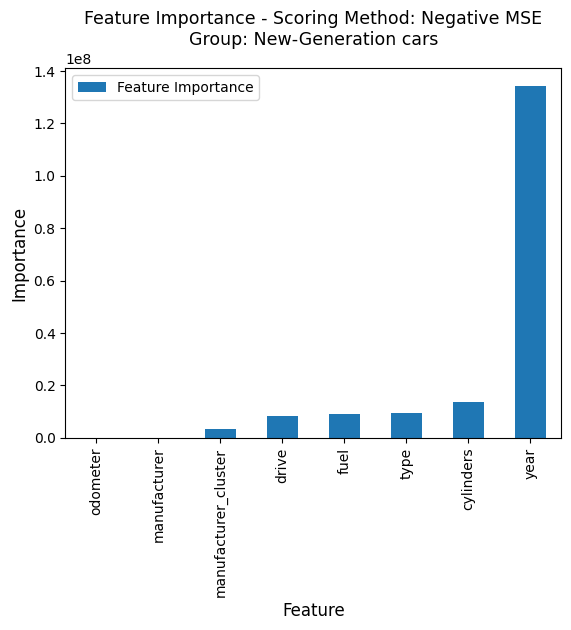

In [132]:
# applying permutation importance strategy on Test data for a specific model using the negative MSE scoring method
importance = permutation_importance(Ridge_poly_n, Xn_test, yn_test, n_repeats = 30, random_state = 42, scoring = 'neg_mean_squared_error')

#inserting results to a dictionary 
dictionaryd = {
    "Feature Importance": importance['importances_mean'],
    "Feature": Xn_test.columns
}

#saving the results to a dataframe
pi_nmse_n = pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance')

#plotting the results:
pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance').plot(kind = 'bar')
plt.title('Feature Importance - Scoring Method: Negative MSE\nGroup: New-Generation cars', fontsize = 12.5)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12);


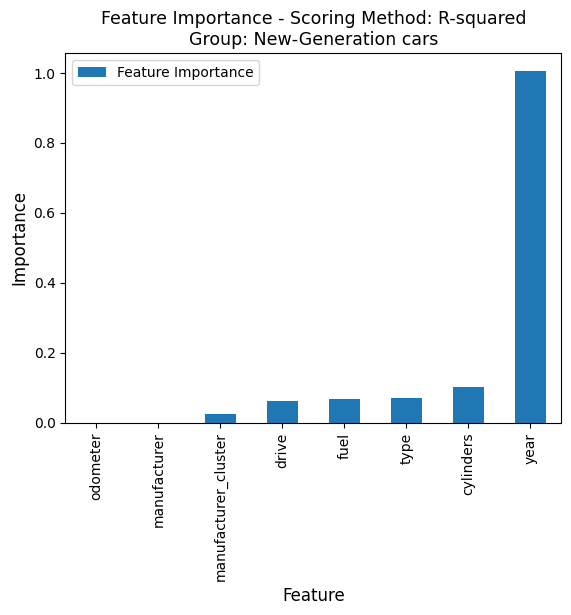

In [133]:
# applying permutation importance strategy on Test data for a specific model using the R-squared scoring method
importance = permutation_importance(Ridge_poly_n, Xn_test, yn_test, n_repeats = 30, random_state = 42, scoring = 'r2')
#inserting results to a dictionary 
dictionaryd = {
    "Feature Importance": importance['importances_mean'],
    "Feature": Xn_test.columns
}
#saving the results to a dataframe
pi_r2_n = pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance')
#plotting the results:
pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance').plot(kind = 'bar')
plt.title('Feature Importance - Scoring Method: R-squared\nGroup: New-Generation cars', fontsize = 12.5)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12);

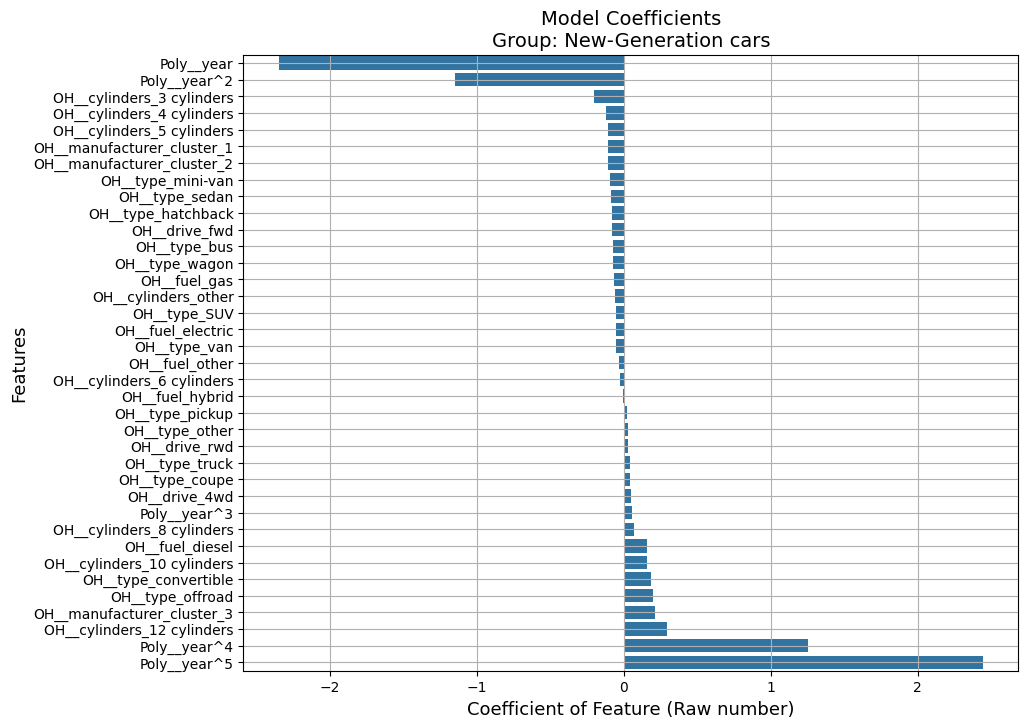

In [134]:
# extracting the coefficient of the model (group New-cars generation) to a dictionary
dictionary_temp = {
    'Feature':Ridge_poly_n.named_steps['preprocessor'].get_feature_names_out(),
    'Coefficient':Ridge_poly_n.named_steps['ri'].regressor_.coef_
}
# saving the results (creation of a dataframe) 
coefs_n = pd.DataFrame(dictionary_temp)

# plotting the results
plt.figure(figsize = (10,8))
plt.title('Model Coefficients\nGroup: New-Generation cars', fontsize = 14)
sns.barplot(data = coefs_n.sort_values(by = 'Coefficient'), x = 'Coefficient', y = 'Feature' )
plt.ylabel('Features', fontsize = 13)
plt.xlabel('Coefficient of Feature (Raw number)', fontsize = 13)
plt.grid(visible = True)

By far, the most crucial feature of the model is the **year**. Furthermore, **cylinders** and **type** features drive the sale price of a used car but not as much as the year variable. By noticing the model's coefficients, it is evident that a small number of cylinders (3 to 5) are slightly dropping the sale price. When the cylinders are eight and above, the price grows somewhat. Lastly, the price is not significantly affected when a car has a 6-cylinder engine. By the same logic, the price of a car slightly decreases when it belongs to manufacturer clusters 1 and 2. On the other hand, the price is slightly increasing when the car belongs to the manufacturer cluster 3. Off-road and convertibles are generally sold at a higher price than minivans. Lastly, it seems that the market calls for vehicles with diesel fuel. For example, cars with diesel as a fuel have higher sale prices than electric vehicles.



Plotting **permutation importance** and **model's coefficients** (old cars group):

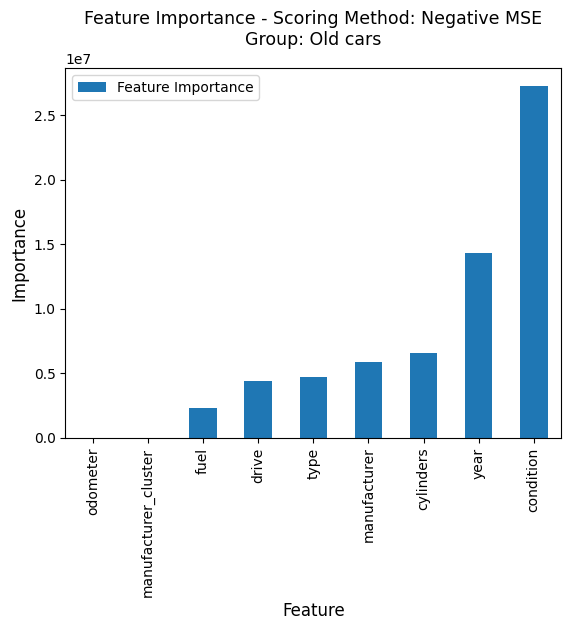

In [135]:
# similarly with the above code I apply permutation importance strategy (negative MSE scoring method) for old cars group:
importance = permutation_importance(Ridge_poly_o_v3, Xo_test, yo_test, n_repeats = 30, random_state = 42, scoring = 'neg_mean_squared_error')
# inserting results to a dictionary
dictionaryd = {
    "Feature Importance": importance['importances_mean'],
    "Feature": Xo_test.columns
}
#saving the results to a dataframe
pi_nmse_o = pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance')
#plotting
pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance').plot(kind = 'bar')
plt.title('Feature Importance - Scoring Method: Negative MSE\nGroup: Old cars', fontsize = 12.5)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12);

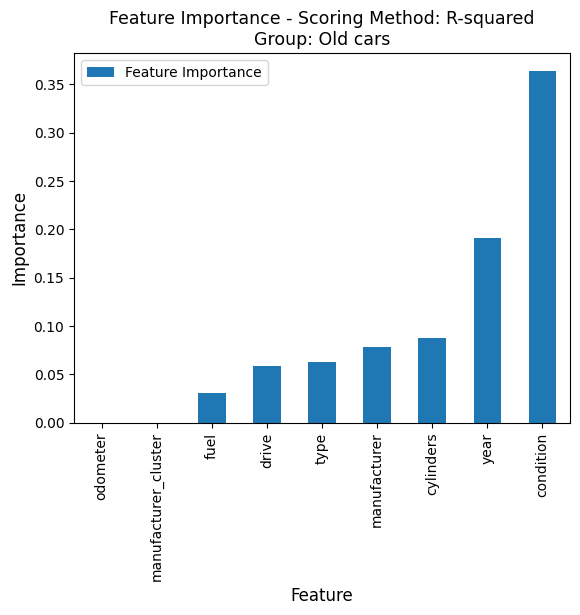

In [136]:
# similarly with the above code I apply permutation importance strategy (negative MSE scoring method) for old cars group:
importance = permutation_importance(Ridge_poly_o_v3, Xo_test, yo_test, n_repeats = 30, random_state = 42, scoring = 'r2')
# inserting results to a dictionary
dictionaryd = {
    "Feature Importance": importance['importances_mean'],
    "Feature": Xo_test.columns
}
#saving the results to a dataframe
pi_r2_o = pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance')
#plotting
pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance').plot(kind = 'bar')
plt.title('Feature Importance - Scoring Method: R-squared\nGroup: Old cars', fontsize = 12.5)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12);

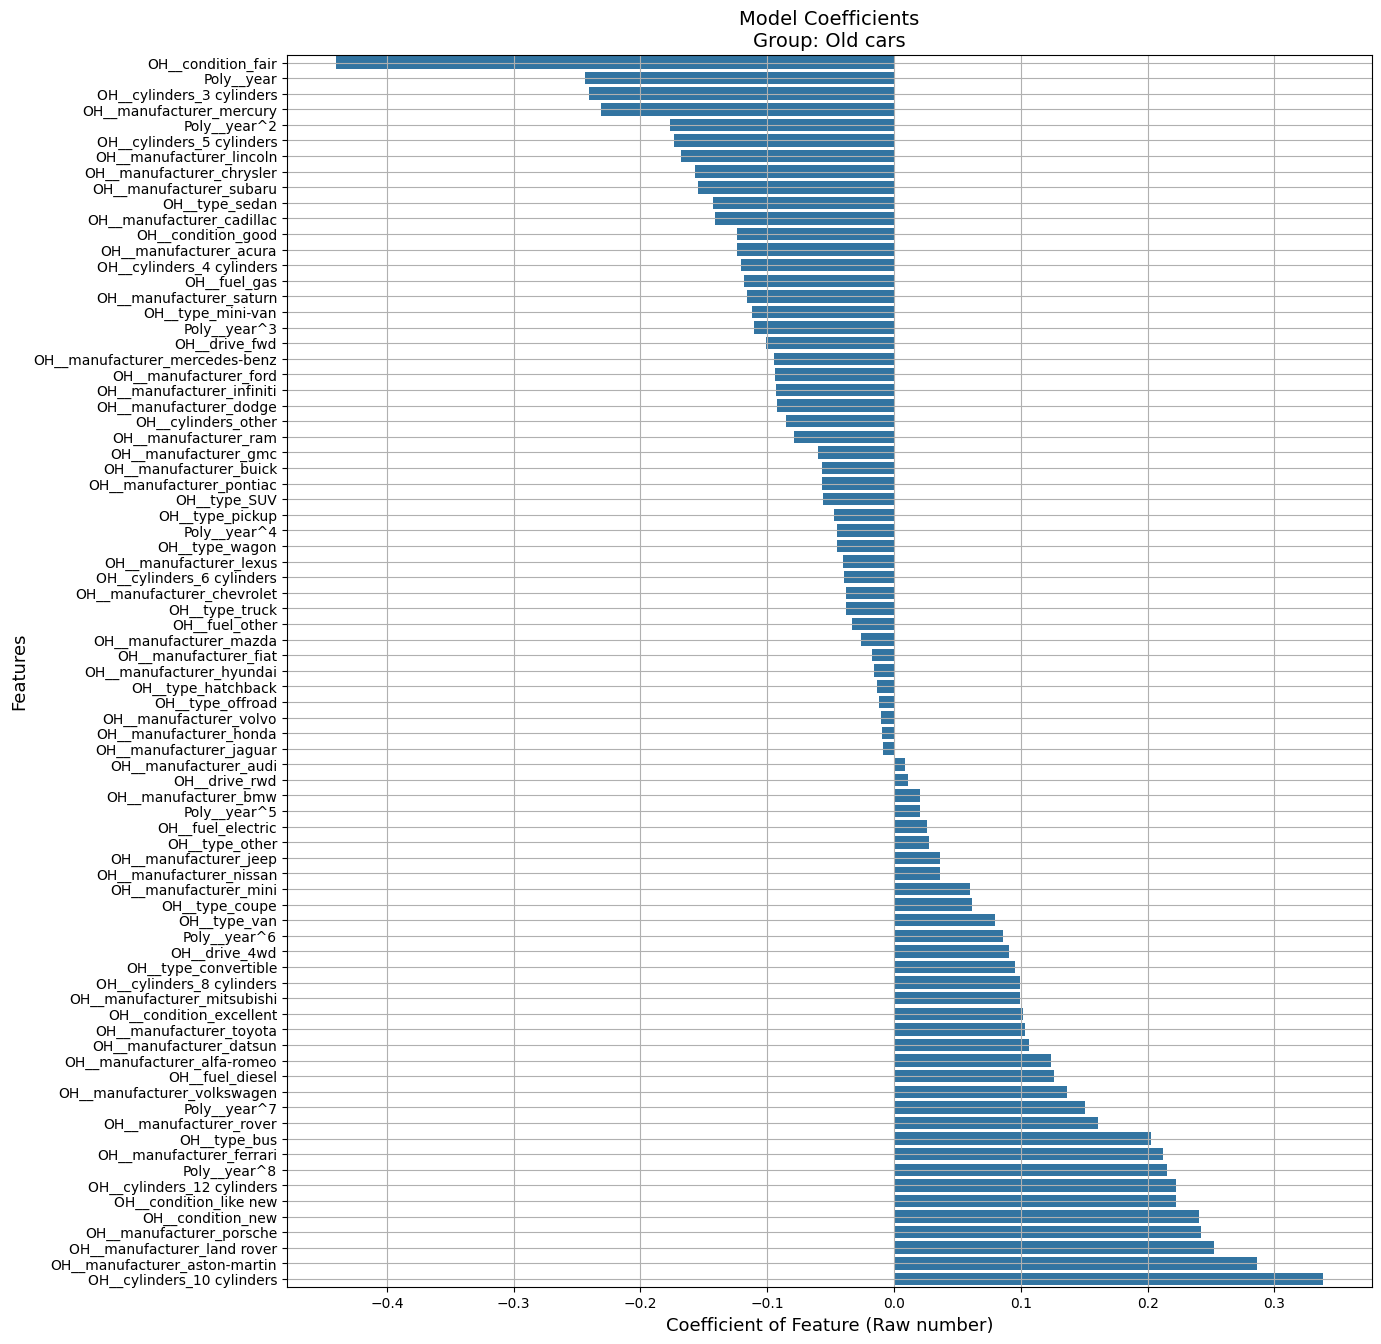

In [137]:
# exporting coefficients to a dictionary
dictionary_temp = {
    'Feature':Ridge_poly_o_v3.named_steps['preprocessor'].get_feature_names_out(),
    'Coefficient':Ridge_poly_o_v3.named_steps['ri'].regressor_.coef_
}
# converting dictionary to a dataframe
coefs_o = pd.DataFrame(dictionary_temp)

#plotting 
plt.figure(figsize = (14,16))
plt.title('Model Coefficients\nGroup: Old cars', fontsize = 14)
sns.barplot(data = coefs_o.sort_values(by = 'Coefficient'), x = 'Coefficient', y = 'Feature' )
plt.ylabel('Features', fontsize = 13)
plt.xlabel('Coefficient of Feature (Raw number)', fontsize = 13)
plt.grid(visible = True)

According to the plots above, the most crucial variable that drives the old cars' sale price is the **condition** of the car followed by its construction **year**, the number of **cylinders**, the **manufacturer**, the **type** and the **drive** type of the car. According to old cars' model coefficients, a fair condition reduces the sale price of a car, while an excellent condition somewhat increases the price. An 8, 10 or 12-cylinder engine positively contributes to the car's sale price, while engines with 6-cylinders and below tend to decrease the final sale price of a used car. In addition, if a car is a Porsche, Ferrari, Land Rover, or Aston Martin, the price is relatively high. Also, Volkswagen, Alfa-Romeo, Datsun, Toyota and Mitsubishi used cars are in demand as these brand names contribute positively to the sale price. Interestingly, cars made by Audi, BMW, Jaguar and Volvo do not significantly contribute to the final sale price. What is more, cars by US brands and Mercedes-Benz lose their value as the years pass. Also,  convertibles and bus-type cars are more expensive than other vehicle types. Lastly, the 4WD cars drive the price up while other drive types are negatively contributing to the sale price.

Plotting **permutation importance** and **model's coefficients** (antiques group):

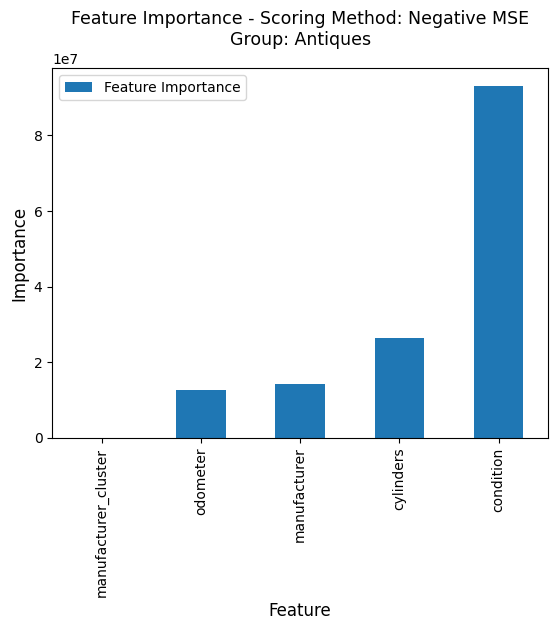

In [138]:
# similarly with the code above, I apply permutation importance strategy (negative MSE scoring method) for antiques group:
importance = permutation_importance(Ridge_poly_a_v2, Xa_test, ya_test, n_repeats = 30, random_state = 42, scoring = 'neg_mean_squared_error')
# exporting results to a dictionary
dictionaryd = {
    "Feature Importance": importance['importances_mean'],
    "Feature": Xa_test.columns
}
# converting dictionary to a dataframe
pi_nmse_a = pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance')
#plotting
pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance').plot(kind = 'bar')
plt.title('Feature Importance - Scoring Method: Negative MSE\nGroup: Antiques', fontsize = 12.5)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12);

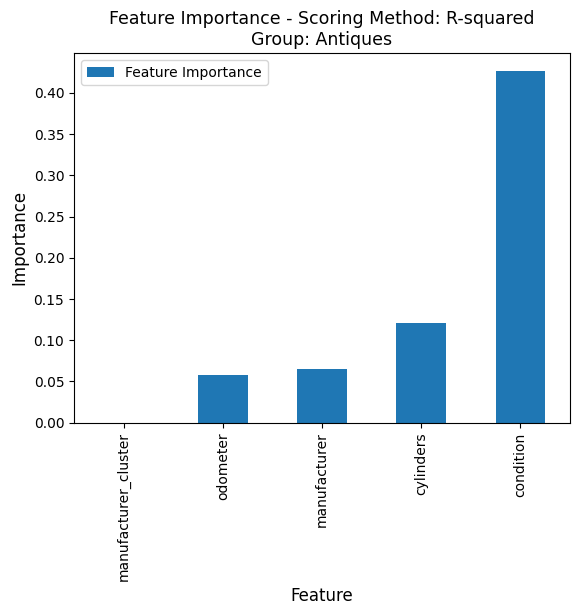

In [139]:
#I apply permutation importance strategy (R-squared scoring method) for antiques group:
importance = permutation_importance(Ridge_poly_a_v2, Xa_test, ya_test, n_repeats = 30, random_state = 42, scoring = 'r2')
# exporting results to a dictionary
dictionaryd = {
    "Feature Importance": importance['importances_mean'],
    "Feature": Xa_test.columns
}
# converting dictionary to a dataframe
pi_r2_a = pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance')
#plotting
pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance').plot(kind = 'bar')
plt.title('Feature Importance - Scoring Method: R-squared\nGroup: Antiques', fontsize = 12.5)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12);

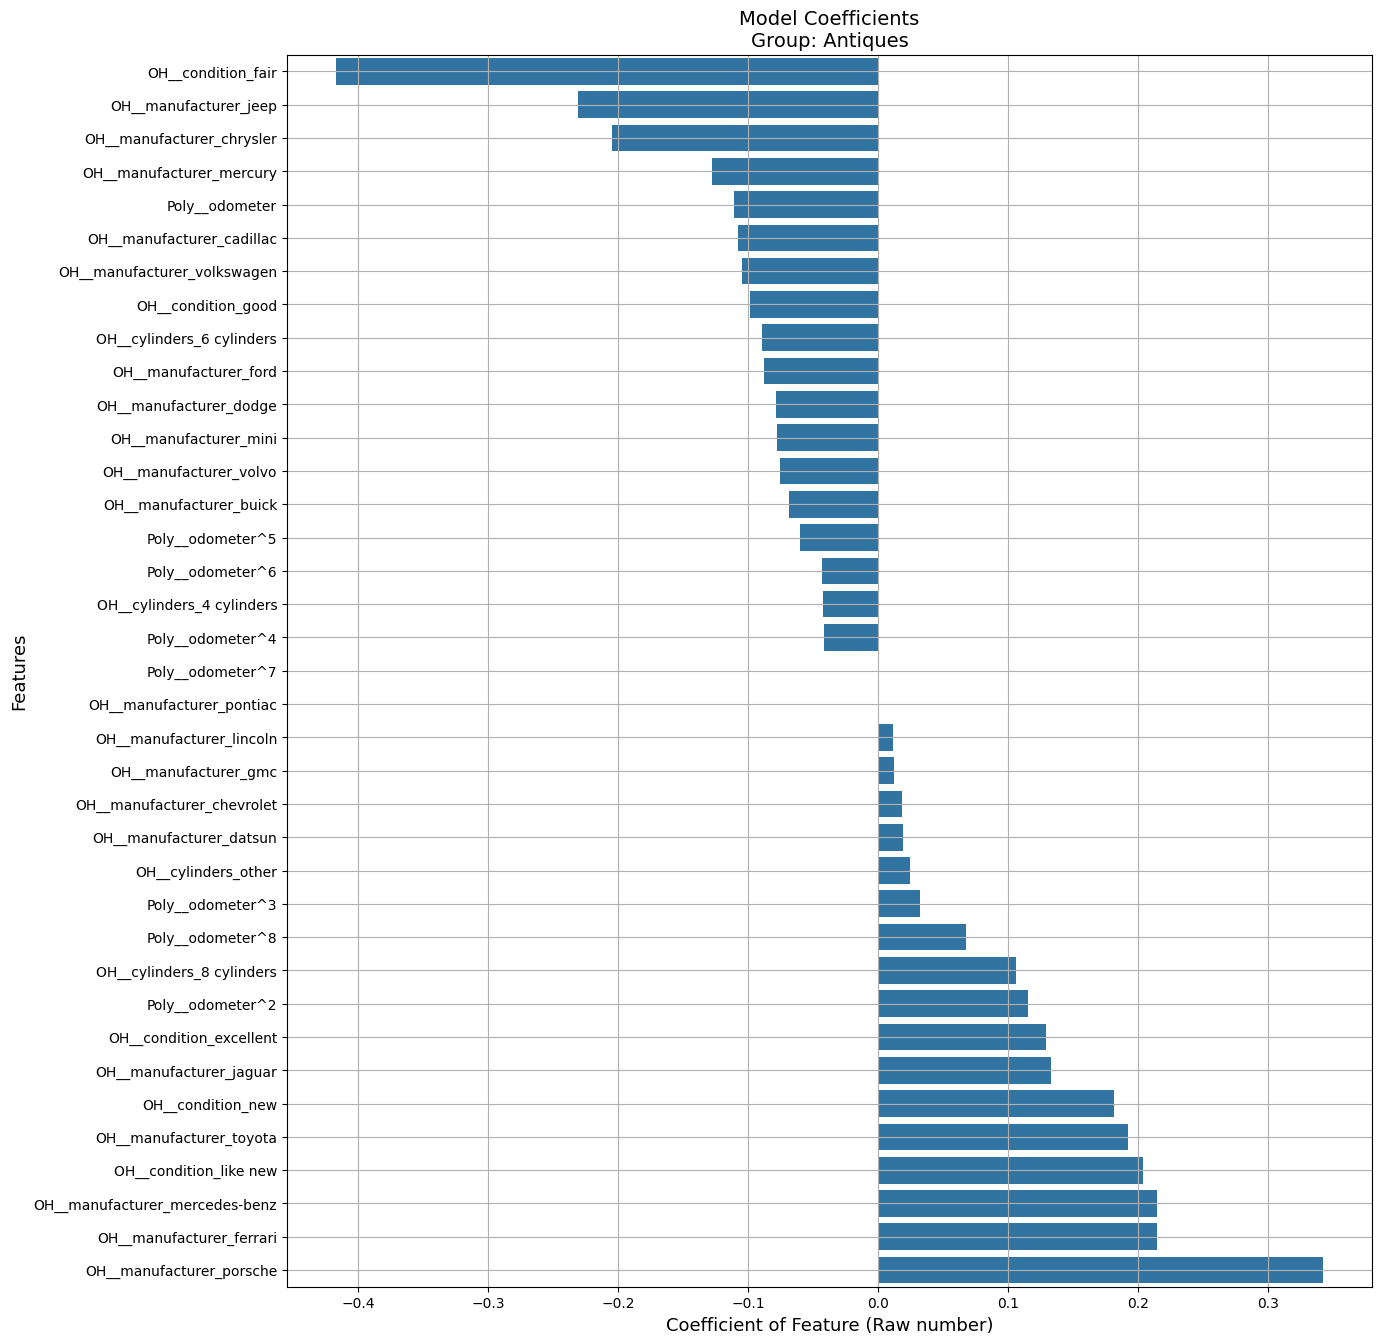

In [140]:
#extracting model's coefficients to a dictionary
dictionary_temp = {
    'Feature': Ridge_poly_a_v2.named_steps['preprocessor'].get_feature_names_out(),
    'Coefficient': Ridge_poly_a_v2.named_steps['ri'].regressor_.coef_
}
# saving coefficients to a dataframe:
coefs_a = pd.DataFrame(dictionary_temp)
# plotting
plt.figure(figsize=(14, 16))
plt.title('Model Coefficients\nGroup: Antiques', fontsize=14)
sns.barplot(data=coefs_a.sort_values(by='Coefficient'), x='Coefficient', y='Feature')
plt.ylabel('Features', fontsize=13)
plt.xlabel('Coefficient of Feature (Raw number)', fontsize=13)
plt.grid(visible=True)

According to the plots above, the most crucial variable that drives the **antiques**' sale price is the **condition** of the car followed by the number of **cylinders**, the **manufacturer** and the **odometer** value of the car. For a fair condition, the price is reduced, while for a new and like-new condition, the price is higher. In addition, luxury and premium European brands like Porsche, Mercedes-Benz, Jaguar and Ferrari positively contribute to the price of a car. It is also interesting that if a vehicle is a Toyota, the price is generally higher than that of a Volvo or Volkswagen. Moreover, the cars made by US brands tend to lose their value as their prices are usually lower than those of European (or Asian) brands. Furthermore, engines with more cylinders (8 and above) make the car pricier. Cars with 4 or 6 cylinders tend to have lower prices.

#### Conclusion - Evaluation Phase
The best models per group (new-generation cars, old cars, antiques) were chosen based on their R-squared, MSE and RMSE scores in the evaluation phase.
The models that will inform the client are:
- **Ridge_poly_n** for the new-generation cars.
- **Ridge_poly_o_v3** for the old cars.
- **Ridge_poly_a_v2** for the antiques

Interpreting the models:
From all the above plots we can conclude the following insights:
- For **new-generation cars**, the most crucial feature of the model is the **year**. Furthermore, **cylinders** and **type** features drive the sale price of a used car but not as much as the year variable. By noticing the model's coefficients, it is evident that a small number of cylinders (3 to 5) are slightly dropping the sale price. When the cylinders are eight and above, the price grows somewhat. Lastly, the price is not significantly affected when a car has a 6-cylinder engine. By the same logic, the price of a car slightly decreases when it belongs to manufacturer clusters 1 and 2. On the other hand, the price is slightly increasing when the car belongs to the manufacturer cluster 3. Off-road and convertibles are generally sold at a higher prices than minivans. Lastly, it seems that the market calls for vehicles with diesel fuel. For example, cars with diesel as a fuel have higher sale prices than electric vehicles.
- The most crucial variable that drives the **old cars**' sale price is the **condition** of the car followed by its construction **year**, the number of **cylinders**, the **manufacturer**, the **type** and the **drive** type of the car. According to old cars' model coefficients, a fair condition reduces the sale price of a car, while an excellent condition somewhat increases the price. An 8, 10 or 12-cylinder engine positively contributes to the car's sale price, while engines with 6-cylinders and below tend to decrease the final sale price of a used car. In addition, if a car is a Porsche, Ferrari, Land Rover, or Aston Martin, the price is relatively high. Also, Volkswagen, Alfa-Romeo, Datsun, Toyota and Mitsubishi used cars are in demand as these brand names contribute positively to the sale price. Interestingly, cars made by Audi, BMW, Jaguar and Volvo do not significantly contribute to the final sale price. What is more, cars by US brands and Mercedes-Benz lose their value as the years pass. Also,  convertibles and bus-type cars are more expensive than other vehicle types. Lastly, the 4WD cars drive the price up while other drive types are negatively contributing to the sale price.
- The most crucial variable that drives the **antiques**' sale price is the **condition** of the car followed by the number of **cylinders**, the **manufacturer** and the **odometer** value of the car. For a fair condition, the price is reduced, while for a new and like-new condition, the price is higher. In addition, luxury and premium European brands like Porsche, Mercedes-Benz, Jaguar and Ferrari positively contribute to the price of a car. It is also interesting that if a vehicle is a Toyota, the price is generally higher than that of a Volvo or Volkswagen. Moreover, the cars made by US brands tend to lose their value as their prices are usually lower than those of European (or Asian) brands. Furthermore, engines with more cylinders (8 and above) make the car pricier. Cars with 4 or 6 cylinders tend to have lower prices.


It is worth mentioning that the model for new-generation cars can accurately inform the client (high R-squared score), while the other models have a more considerable uncertainty in their results (low R-squared score). On the other hand, most of the cars are in the first group ( new-generation cars ), so we can proceed to the deployment phase.


## 6 Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

The data of used cars were grouped into three groups by the year of their construction:
- The 1st group is new-generation cars (manufacturing year >= 1998)
- The second is the old-cars group (between 1969 and 1997)
- The third is the antiques group ( between 1908 and 1968)

Also, for the 1st group, I clustered the manufacturers into three groups, as demonstrated below.

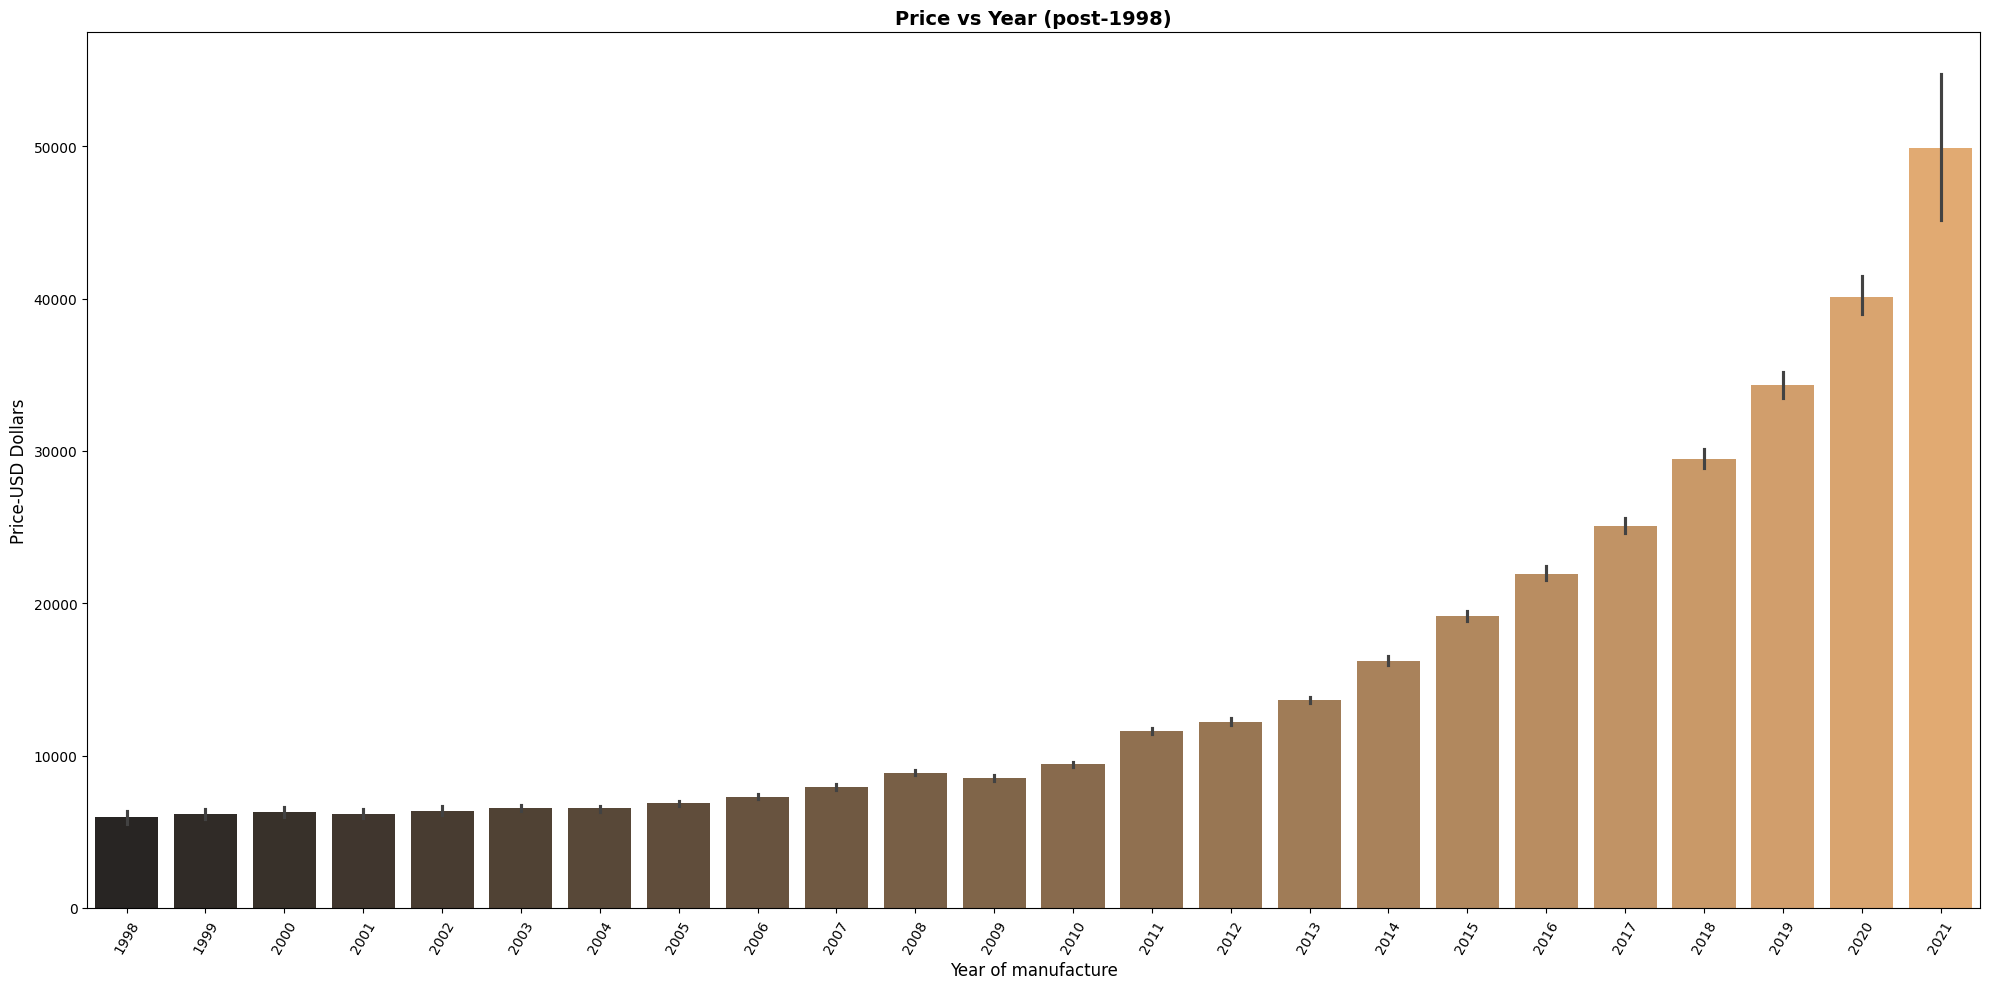

In [141]:
#plotting year vs price
plt.figure(figsize=(20, 10))
plt.title('Price vs Year (post-1998)', fontsize=14, fontweight='bold')
sns.barplot(data=data_und.query('year>=1998'),
            x='year', y='price', hue='year',
            palette='dark:#F3AA60', legend=False)
plt.xlabel('Year of manufacture', fontsize=12)
plt.xticks(rotation=60)
plt.ylabel('Price-USD Dollars', fontsize=12)
plt.tight_layout()

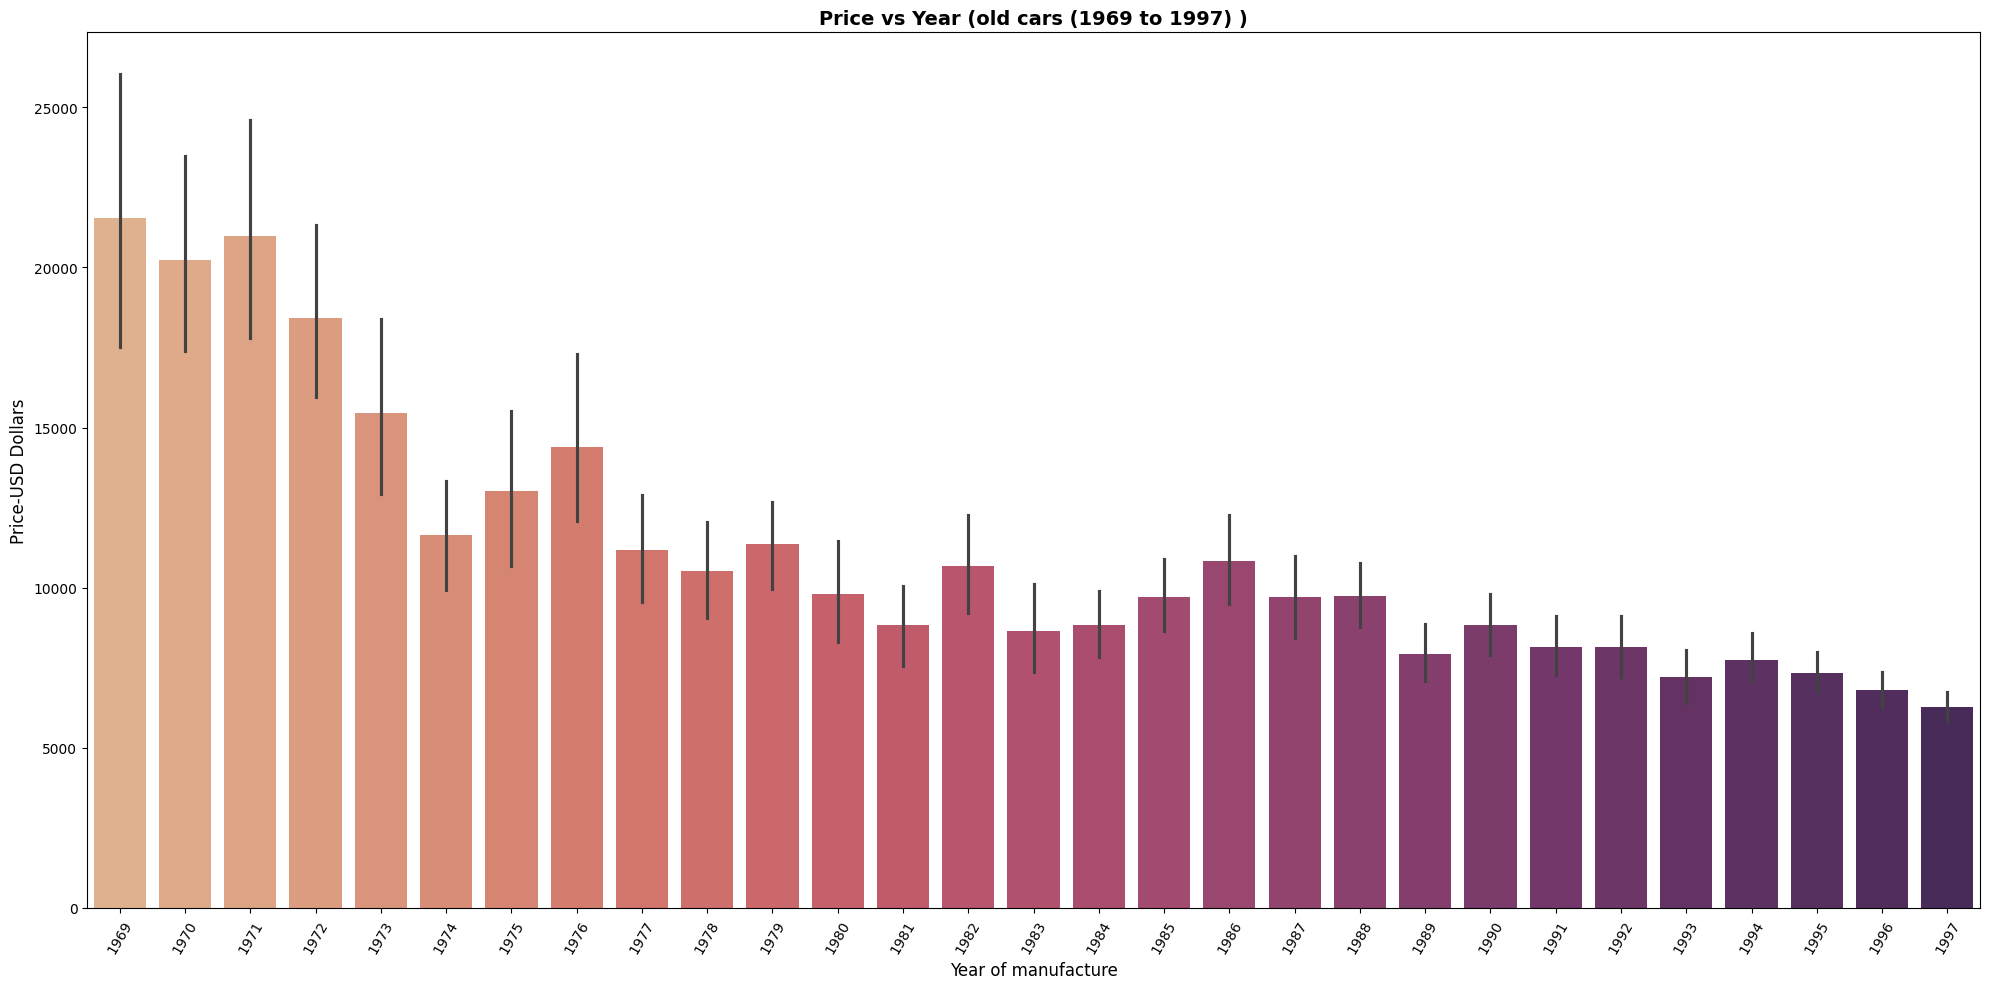

In [142]:
#plotting year vs price
plt.figure(figsize =(20,10))
plt.title('Price vs Year (old cars (1969 to 1997) )',fontsize=14, fontweight ='bold')
sns.barplot(data=data_und.query('year>=1969 and year<1998'),
            x='year', y='price', hue='year',
            palette='flare', legend=False)
plt.xlabel('Year of manufacture',fontsize = 12)
plt.xticks(rotation=60)
plt.ylabel('Price-USD Dollars',fontsize = 12)
plt.tight_layout()

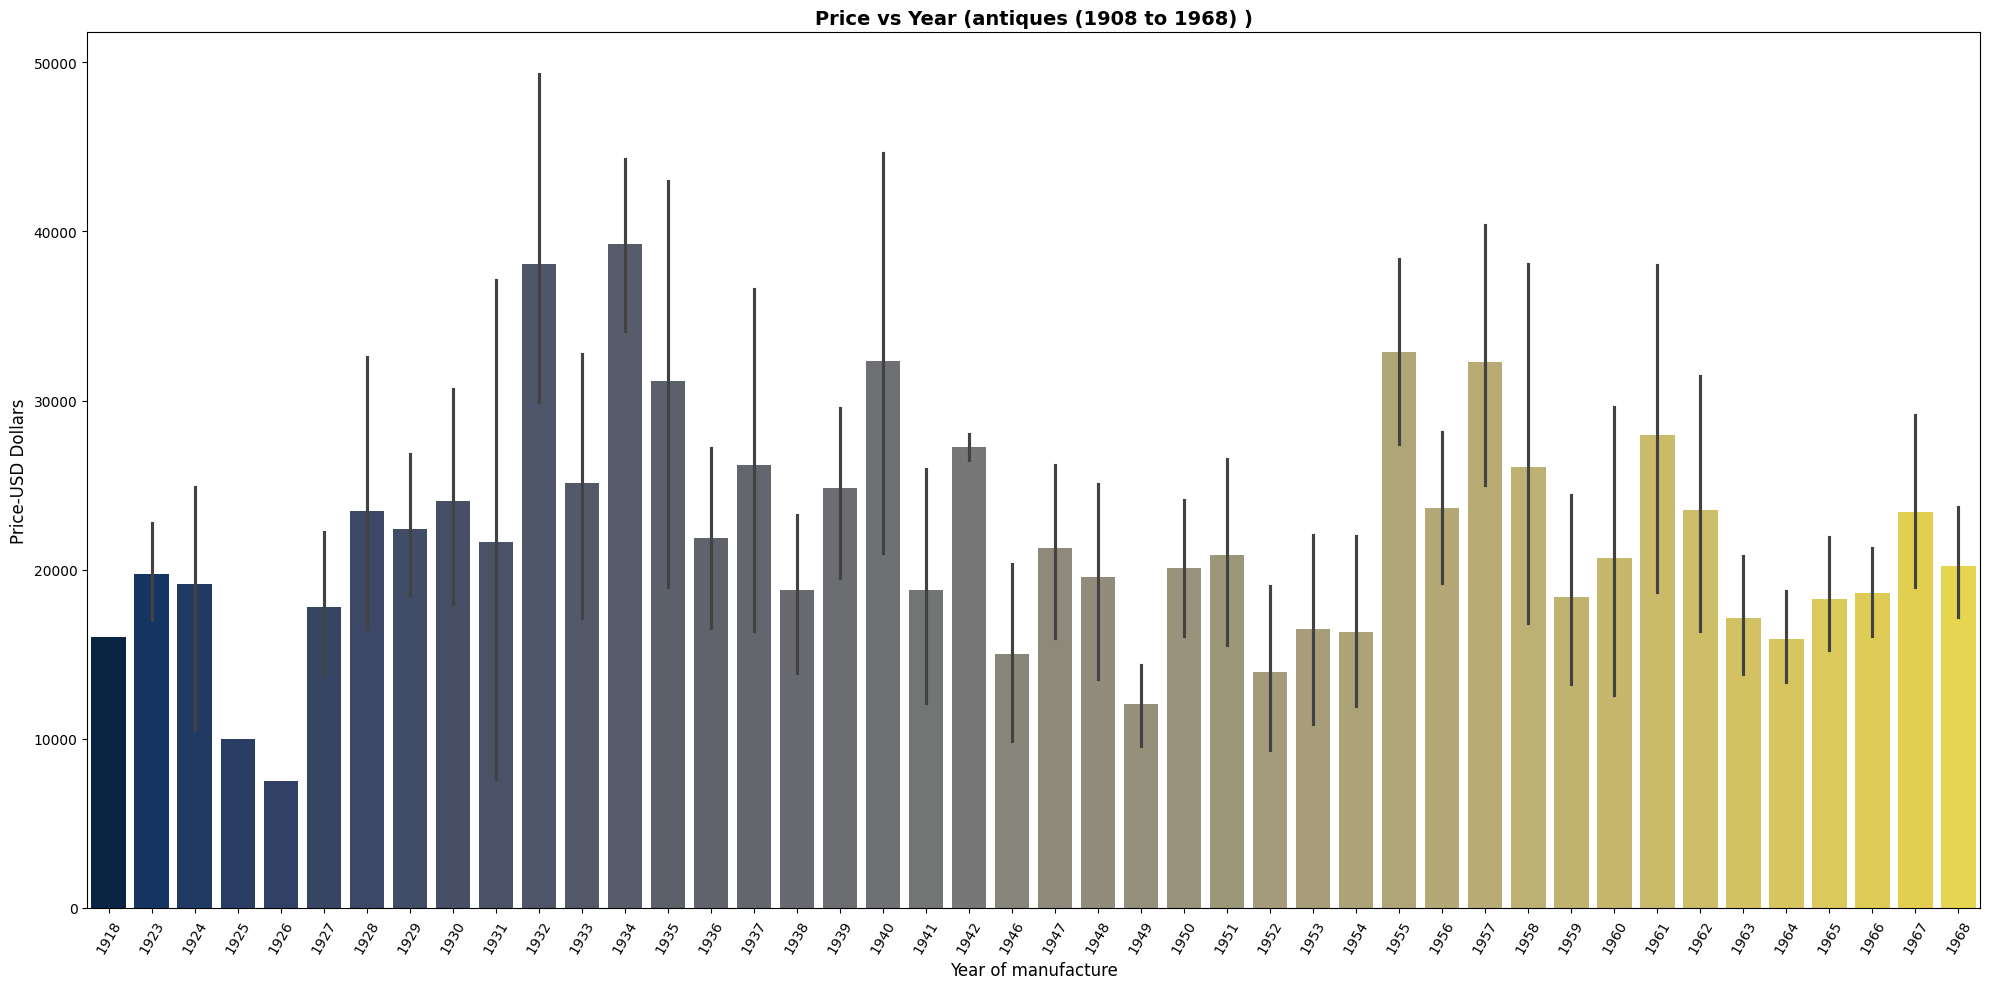

In [143]:
#plotting year vs price
plt.figure(figsize =(20,10))
plt.title('Price vs Year (antiques (1908 to 1968) )',fontsize=14, fontweight ='bold')
sns.barplot(data=data_und.query('year<1969'),
            x='year', y='price', hue='year',
            palette='cividis', legend=False)
plt.xlabel('Year of manufacture',fontsize = 12)
plt.xticks(rotation=60)
plt.ylabel('Price-USD Dollars',fontsize = 12)
plt.tight_layout()

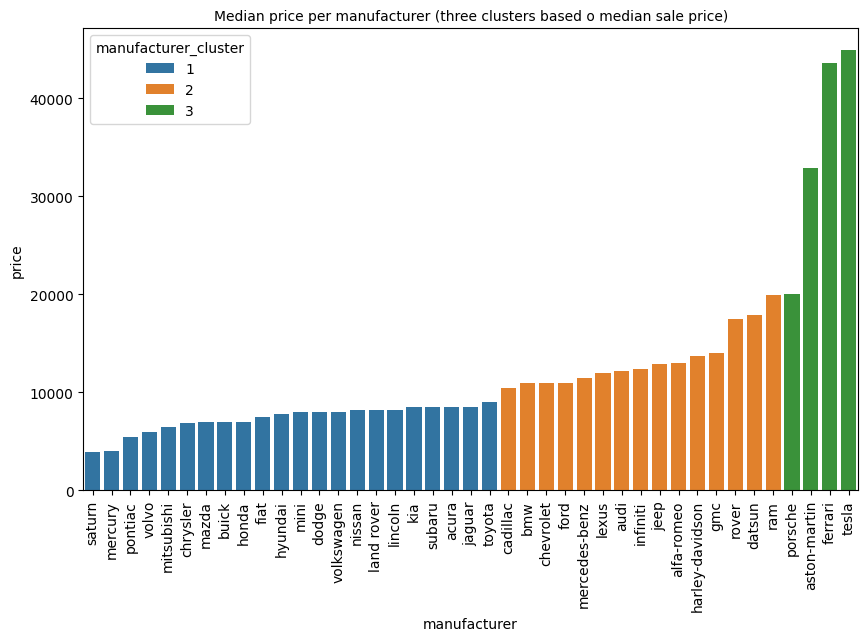

In [144]:
temp = data_und.groupby(['manufacturer','manufacturer_cluster']).median('price').sort_values(by = 'price').reset_index()[['manufacturer','price', 'manufacturer_cluster']]

#plotting:
plt.figure(figsize=(10,6))
plt.title('Median price per manufacturer (three clusters based o median sale price)', fontsize = 10)
sns.barplot(data = temp, x = 'manufacturer', y = 'price', hue = 'manufacturer_cluster')
plt.xticks(rotation = 90);

I created three models, one for each group:
- The **Ridge_poly_n** model for the group of new-generation cars.
- The **Ridge_poly_o_v3** model for the group of old cars.
- The **Ridge_poly_a_v2** model for the group of antiques.

The models fitted to the data and gave the following score metrics:

In [145]:
MSE_train, MSE_test, RMSE_train, RMSE_test, Rsquared_train, Rsquared_test = calculate_metrics(model = Ridge_poly_n,
                                                                                              Xtrain_data =  Xn_train,
                                                                                              Xtest_data = Xn_test,
                                                                                              ytrain = yn_train,
                                                                                              ytest = yn_test)
print("Train R-Square score of the Ridge_poly_n: "+str(np.round(Rsquared_train, 3)))
print("Test R-Square score of the Ridge_poly_n: "+str(np.round(Rsquared_test, 3)))

print("Train Adjusted R-Square score of the Ridge_poly_n: "+str(np.round(adj_R2(X=Xn_train, y=yn_train, model = Ridge_poly_n), 3)) )
print("Test Adjusted R-Square score of the Ridge_poly_n: "+str(np.round(adj_R2(X=Xn_test, y=yn_test, model = Ridge_poly_n), 3)) )

print("Train MSE score of the Ridge_poly_n: "+str(np.round(MSE_train, 2)))
print("Test MSE score of the Ridge_poly_n: "+str(np.round(MSE_test, 2)))

print("Train RMSE score of the Ridge_poly_n: "+str(np.round(RMSE_train, 2)))
print("Test RMSE score of the Ridge_poly_n: "+str(np.round(RMSE_test, 2)))

Train R-Square score of the Ridge_poly_n: 0.708
Test R-Square score of the Ridge_poly_n: 0.712
Train Adjusted R-Square score of the Ridge_poly_n: 0.708
Test Adjusted R-Square score of the Ridge_poly_n: 0.712
Train MSE score of the Ridge_poly_n: 40710425.88
Test MSE score of the Ridge_poly_n: 38438658.04
Train RMSE score of the Ridge_poly_n: 6380.47
Test RMSE score of the Ridge_poly_n: 6199.89


In [146]:
MSE_train, MSE_test, RMSE_train, RMSE_test, Rsquared_train, Rsquared_test = calculate_metrics(model = Ridge_poly_o_v3,
                                                                                              Xtrain_data =  Xo_train,
                                                                                              Xtest_data = Xo_test,
                                                                                              ytrain = yo_train,
                                                                                              ytest = yo_test)
print("Train R-Square score of the Ridge_poly_o_v3: "+str(np.round(Rsquared_train, 3)))
print("Test R-Square score of the Ridge_poly_o_v3: "+str(np.round(Rsquared_test, 3)))

print("Train Adjusted R-Square score of the Ridge_poly_o_v3: "+str(np.round(adj_R2(X=Xo_train, y=yo_train, model = Ridge_poly_o_v3), 3)) )
print("Test Adjusted R-Square score of the Ridge_poly_o_v3: "+str(np.round(adj_R2(X=Xo_test, y=yo_test, model = Ridge_poly_o_v3), 3)) )

print("Train MSE score of the Ridge_poly_o_v3: "+str(np.round(MSE_train, 2)))
print("Test MSE score of the Ridge_poly_o_v3: "+str(np.round(MSE_test, 2)))

print("Train RMSE score of the Ridge_poly_o_v3: "+str(np.round(RMSE_train, 2)))
print("Test RMSE score of the Ridge_poly_o_v3: "+str(np.round(RMSE_test, 2)))

Train R-Square score of the Ridge_poly_o_v3: 0.427
Test R-Square score of the Ridge_poly_o_v3: 0.405
Train Adjusted R-Square score of the Ridge_poly_o_v3: 0.426
Test Adjusted R-Square score of the Ridge_poly_o_v3: 0.393
Train MSE score of the Ridge_poly_o_v3: 47496355.78
Test MSE score of the Ridge_poly_o_v3: 44578192.26
Train RMSE score of the Ridge_poly_o_v3: 6891.76
Test RMSE score of the Ridge_poly_o_v3: 6676.69


In [147]:
MSE_train, MSE_test, RMSE_train, RMSE_test, Rsquared_train, Rsquared_test = calculate_metrics(model = Ridge_poly_a_v2,
                                                                                              Xtrain_data =  Xa_train,
                                                                                              Xtest_data = Xa_test,
                                                                                              ytrain = ya_train,
                                                                                              ytest = ya_test)
print("Train R-Square score of the Ridge_poly_a_v2: "+str(np.round(Rsquared_train, 3)))
print("Test R-Square score of the Ridge_poly_a_v2: "+str(np.round(Rsquared_test, 3)))

print("Train Adjusted R-Square score of the Ridge_poly_o_v3: "+str(np.round(adj_R2(X=Xa_train, y=ya_train, model = Ridge_poly_a_v2), 3)) )
print("Test Adjusted R-Square score of the Ridge_poly_o_v3: "+str(np.round(adj_R2(X=Xa_test, y=ya_test, model = Ridge_poly_a_v2), 3)) )

print("Train MSE score of the Ridge_poly_a_v2: "+str(np.round(MSE_train, 2)))
print("Test MSE score of the Ridge_poly_a_v2: "+str(np.round(MSE_test, 2)))

print("Train RMSE score of the Ridge_poly_a_v2: "+str(np.round(RMSE_train, 2)))
print("Test RMSE score of the Ridge_poly_a_v2: "+str(np.round(RMSE_test, 2)))

Train R-Square score of the Ridge_poly_a_v2: 0.319
Test R-Square score of the Ridge_poly_a_v2: 0.352
Train Adjusted R-Square score of the Ridge_poly_o_v3: 0.315
Test Adjusted R-Square score of the Ridge_poly_o_v3: 0.316
Train MSE score of the Ridge_poly_a_v2: 177802105.65
Test MSE score of the Ridge_poly_a_v2: 141387746.04
Train RMSE score of the Ridge_poly_a_v2: 13334.25
Test RMSE score of the Ridge_poly_a_v2: 11890.66


#### Insights to report:

- For **new-generation cars**, the most crucial feature of the model is the **year**. Furthermore, **cylinders** and **type** features drive the sale price of a used car but not as much as the year variable. By noticing the model's coefficients, it is evident that a small number of cylinders (3 to 5) are slightly dropping the sale price. When the cylinders are eight and above, the price grows somewhat. Lastly, the price is not significantly affected when a car has a 6-cylinder engine. By the same logic, the price of a car slightly decreases when it belongs to manufacturer clusters 1 and 2. On the other hand, the price is slightly increasing when the car belongs to the manufacturer cluster 3. Off-road and convertibles are generally sold at a higher prices than minivans. Lastly, it seems that the market calls for vehicles with diesel fuel. For example, cars with diesel as a fuel have higher sale prices than electric vehicles.

- The most crucial variable that drives the **old cars**' sale price is the **condition** of the car followed by its construction **year**, the number of **cylinders**, the **manufacturer**, the **type** and the **drive** type of the car. According to old cars' model coefficients, a fair condition reduces the sale price of a car, while an excellent condition somewhat increases the price. An 8, 10 or 12-cylinder engine positively contributes to the car's sale price, while engines with 6-cylinders and below tend to decrease the final sale price of a used car. In addition, if a car is a Porsche, Ferrari, Land Rover, or Aston Martin, the price is relatively high. Also, Volkswagen, Alfa-Romeo, Datsun, Toyota and Mitsubishi used cars are in demand as these brand names contribute positively to the sale price. Interestingly, cars made by Audi, BMW, Jaguar and Volvo do not significantly contribute to the final sale price. What is more, cars by US brands and Mercedes-Benz lose their value as the years pass. Also,  convertibles and bus-type cars are more expensive than other vehicle types. Lastly, the 4WD cars drive the price up while other drive types are negatively contributing to the sale price.

- The most crucial variable that drives the **antiques**' sale price is the **condition** of the car followed by the number of **cylinders**, the **manufacturer** and the **odometer** value of the car. For a fair condition, the price is reduced, while for a new and like-new condition, the price is higher. In addition, luxury and premium European brands like Porsche, Mercedes-Benz, Jaguar and Ferrari positively contribute to the price of a car. It is also interesting that if a vehicle is a Toyota, the price is generally higher than that of a Volvo or Volkswagen. Moreover, the cars made by US brands tend to lose their value as their prices are usually lower than those of European (or Asian) brands. Furthermore, engines with more cylinders (8 and above) make the car pricier. Cars with 4 or 6 cylinders tend to have lower prices.

(more info can be found in the evaluation phase and below)

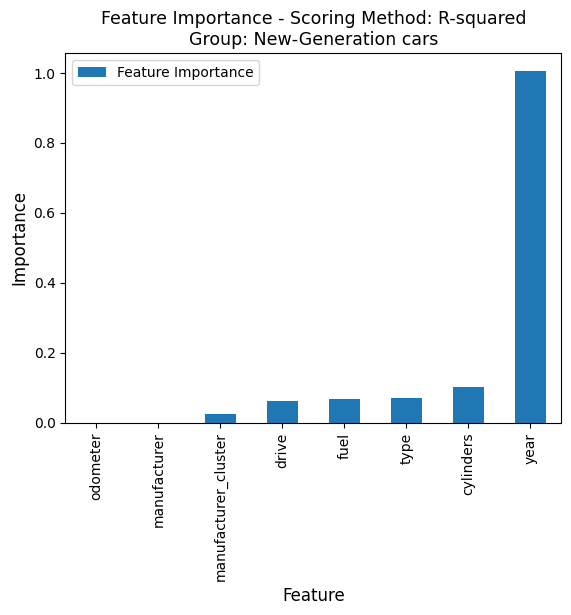

In [148]:
# applying permutation importance strategy on Test data for a specific model using the R-squared scoring method
importance = permutation_importance(Ridge_poly_n, Xn_test, yn_test, n_repeats = 30, random_state = 42, scoring = 'r2')
#inserting results to a dictionary 
dictionaryd = {
    "Feature Importance": importance['importances_mean'],
    "Feature": Xn_test.columns
}
#saving the results to a dataframe
pi_r2_n = pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance')
#plotting the results:
pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance').plot(kind = 'bar')
plt.title('Feature Importance - Scoring Method: R-squared\nGroup: New-Generation cars', fontsize = 12.5)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12);

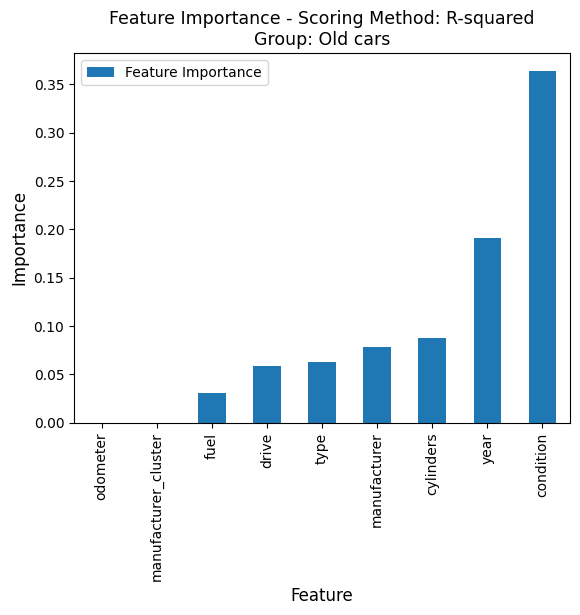

In [149]:
# similarly with the above code I apply permutation importance strategy (negative MSE scoring method) for old cars group:
importance = permutation_importance(Ridge_poly_o_v3, Xo_test, yo_test, n_repeats = 30, random_state = 42, scoring = 'r2')
# inserting results to a dictionary
dictionaryd = {
    "Feature Importance": importance['importances_mean'],
    "Feature": Xo_test.columns
}
#saving the results to a dataframe
pi_r2_o = pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance')
#plotting
pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance').plot(kind = 'bar')
plt.title('Feature Importance - Scoring Method: R-squared\nGroup: Old cars', fontsize = 12.5)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12);

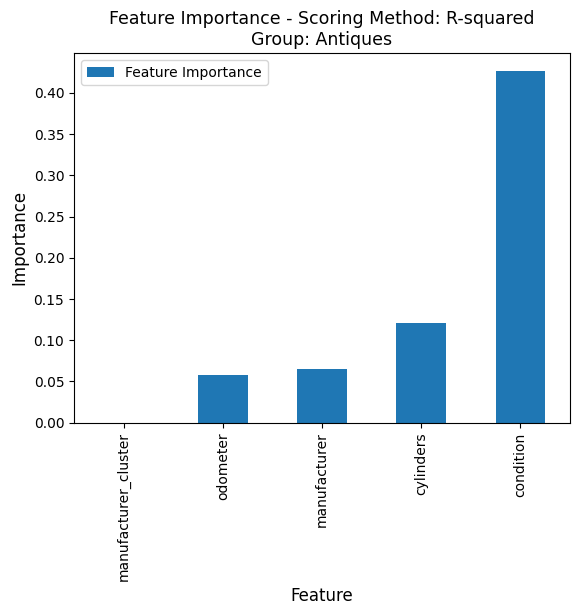

In [150]:
#I apply permutation importance strategy (R-squared scoring method) for antiques group:
importance = permutation_importance(Ridge_poly_a_v2, Xa_test, ya_test, n_repeats = 30, random_state = 42, scoring = 'r2')
# exporting results to a dictionary
dictionaryd = {
    "Feature Importance": importance['importances_mean'],
    "Feature": Xa_test.columns
}
# converting dictionary to a dataframe
pi_r2_a = pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance')
#plotting
pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance').plot(kind = 'bar')
plt.title('Feature Importance - Scoring Method: R-squared\nGroup: Antiques', fontsize = 12.5)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12);

#### Recommendations:

- The client should focus primarily on luxury and premium European brands as they tend to keep or increase their value through time.
- The client should focus on the number of cylinders, which is also crucial. Cars with eight or more cylinders tend to have higher sale prices.
- The client should focus on offroad and convertible cars as they tend to keep (or increase) their value through the years.
- Depending on the group (new-generation cars and old cars), the client should focus on the manufacturing year of the vehicle. For new-generation cars, the higher the year, the higher the sale price. The opposite trend is noticed in the old-cars group.
- Condition plays a crucial role, especially on old cars and antiques. The client should focus on like-new cars and avoid cars with a condition labelled as fair.

#### Next Steps:
- In a next client engagement, we should inform more accurately our client by creating more complex and non-linear models for the old-cars and antiques groups. 
- In addition, we should acquire more accurate and recent data on the subject for future projects.
- Lastly, we should better model the data and insert the features that were not involved in the modelling phase in future analysis.

In [151]:
print('Notebook runs without errors')

Notebook runs without errors
